# Figures

In [1]:
%matplotlib inline
%config InlineBackend.figure_format='retina'

import pandas as pd
import seaborn as sns
from IPython.display import display
from tqdm.auto import tqdm

sns.set_style("whitegrid")
import matplotlib.pyplot as plt
import numpy as np
import os
import re
from itertools import product
import tempfile

In [2]:
def bedl(file):
    try:
        tf = pd.read_csv(file, sep='\t', header=None)
        return tf[2] - tf[1]
    except:
        return np.zeros(0)  # Empty file


def lines(file):
    try:
        tf = pd.read_csv(file, sep='\t', header=None)
        return len(tf)
    except:
        return 0  # Empty file


def d(a, b):
    return a / b if b != 0 else 0


def last_col(file):
    try:
        cols = len(pd.read_csv(file, sep='\t', nrows=1, header=None).columns)
        return pd.read_csv(file, sep='\t', header=None, usecols=[cols - 1])[cols - 1]
    except:
        return np.zeros(0)  # Empty file


def sorted_file(file):
    ts = tempfile.mktemp()
    ! cat {file} | sort -k1,1 -k2,2n -k3,3n > {ts}
    return ts

# Load hg38 peaks


In [3]:
GSE26320_PATH = os.path.expanduser('~/data/2023_GSE26320')
GSE26320_CELLS = ['GM12878', 'HMEC', 'HSMM', 'K562', 'NHEK', 'NHLF', 'H1', 'Huvec', 'HepG2']
MODIFICATIONS = ['H3K4me3', 'H3K27ac', 'H3K4me1', 'H3K27me3', 'H3K36me3']
GSE26320_REPS = ['rep1', 'rep2']

IMMUNE_PATH = os.path.expanduser('~/data/2023_Immune')
IMMUNE_CELLS = ['CD4ABT', 'TCellBB', 'BCell', 'TCell', 'Monocyte', 'PBMC', 'NK', 'CD34', 'CD4', ]  ## Longest first
IMMUNE_REPS = ['rep1', 'rep2', 'rep3', '']

! mkdir -p {GSE26320_PATH}/pics
! mkdir -p {IMMUNE_PATH}/pics

In [4]:
TOOLS = ['MACS2', 'MACS2 broad', 'SPAN', 'SICER']
palette = plt.cm.get_cmap('tab10')
TOOLS_PALETTE = {t: palette(i) for i, t in enumerate(TOOLS)}

In [5]:
def load_peaks(path, suffix, modifications, cells, replicates):
    df = pd.DataFrame(columns=['file', 'modification', 'cell', 'replicate', 'peaks'],
                      dtype=object)
    for f in tqdm(os.listdir(path)):
        if not f.endswith(suffix):
            continue
        cell = next((c for c in cells if c in f), None)
        mod = next((m for m in modifications if m in f), None)
        rep = next((r for r in replicates if r in f), None)
        if cell and mod and rep is not None:
            peaks_path = os.path.join(path, f)
            ps = lines(peaks_path)
            df.loc[len(df)] = (peaks_path, mod, cell, rep, ps)
    return df

In [6]:
def load_peaks_path(path, modifications, cells, replicates):
    df_macs2 = load_peaks(os.path.join(path, 'macs2'), '.narrowPeak', modifications, cells, replicates)
    df_macs2['tool'] = 'MACS2'
    print('MACS2', len(df_macs2))

    df_macs2broad = load_peaks(os.path.join(path, 'macs2'), '.broadPeak', modifications, cells, replicates)
    df_macs2broad['tool'] = 'MACS2 broad'
    print('MACS2 broad', len(df_macs2broad))

    df_sicer = load_peaks(os.path.join(path, 'sicer'), 'summary-FDR0.01', modifications, cells, replicates)
    df_sicer['tool'] = 'SICER'
    print('SICER', len(df_sicer))

    df_span = load_peaks(os.path.join(path, 'span'), '.peak', modifications, cells, replicates)
    # df_span = df_span[['_200_' in f for f in df_span['file']]]
    df_span['tool'] = 'SPAN'
    print('SPAN', len(df_span))

    return pd.concat([df_macs2, df_macs2broad, df_sicer, df_span]).reset_index(drop=True)

In [7]:
df_encode_peaks = load_peaks_path(GSE26320_PATH, MODIFICATIONS, GSE26320_CELLS, GSE26320_REPS)
df_encode_peaks['dataset'] = 'ENCODE'
df_encode_peaks.sample(5)

  0%|          | 0/680 [00:00<?, ?it/s]

MACS2 85


  0%|          | 0/680 [00:00<?, ?it/s]

MACS2 broad 85


  0%|          | 0/85 [00:00<?, ?it/s]

SICER 85


  0%|          | 0/86 [00:00<?, ?it/s]

SPAN 85


file modification   cell  \
58   /home/jetbrains/data/2023_GSE26320/macs2/GSM64...     H3K27me3     H1   
200  /home/jetbrains/data/2023_GSE26320/sicer/GSM64...      H3K4me1   NHEK   
76   /home/jetbrains/data/2023_GSE26320/macs2/GSM64...     H3K36me3   NHLF   
211  /home/jetbrains/data/2023_GSE26320/sicer/GSM64...      H3K4me1   K562   
10   /home/jetbrains/data/2023_GSE26320/macs2/GSM64...      H3K4me3  Huvec   

    replicate  peaks   tool dataset  
58       rep1  15244  MACS2  ENCODE  
200      rep2  70847  SICER  ENCODE  
76       rep1      3  MACS2  ENCODE  
211      rep2  55685  SICER  ENCODE  
10       rep1  28373  MACS2  ENCODE

In [8]:
df_immune_peaks = load_peaks_path(IMMUNE_PATH, MODIFICATIONS, IMMUNE_CELLS, IMMUNE_REPS)
df_immune_peaks['dataset'] = 'Roadmap'
df_immune_peaks.sample(5)

  0%|          | 0/368 [00:00<?, ?it/s]

MACS2 46


  0%|          | 0/368 [00:00<?, ?it/s]

MACS2 broad 46


  0%|          | 0/47 [00:00<?, ?it/s]

SICER 46


  0%|          | 0/50 [00:00<?, ?it/s]

SPAN 46


file modification      cell  \
18   /home/jetbrains/data/2023_Immune/macs2/Monocyt...     H3K36me3  Monocyte   
30   /home/jetbrains/data/2023_Immune/macs2/CD34_H3...     H3K36me3      CD34   
109  /home/jetbrains/data/2023_Immune/sicer/CD34_H3...      H3K27ac      CD34   
108  /home/jetbrains/data/2023_Immune/sicer/BCell_H...      H3K4me1     BCell   
106  /home/jetbrains/data/2023_Immune/sicer/CD4_H3K...      H3K27ac       CD4   

    replicate   peaks   tool  dataset  
18             127115  MACS2  Roadmap  
30       rep1  122980  MACS2  Roadmap  
109             37371  SICER  Roadmap  
108             62076  SICER  Roadmap  
106             37659  SICER  Roadmap

In [144]:
df_peaks = pd.concat([df_encode_peaks, df_immune_peaks]).reset_index(drop=True)

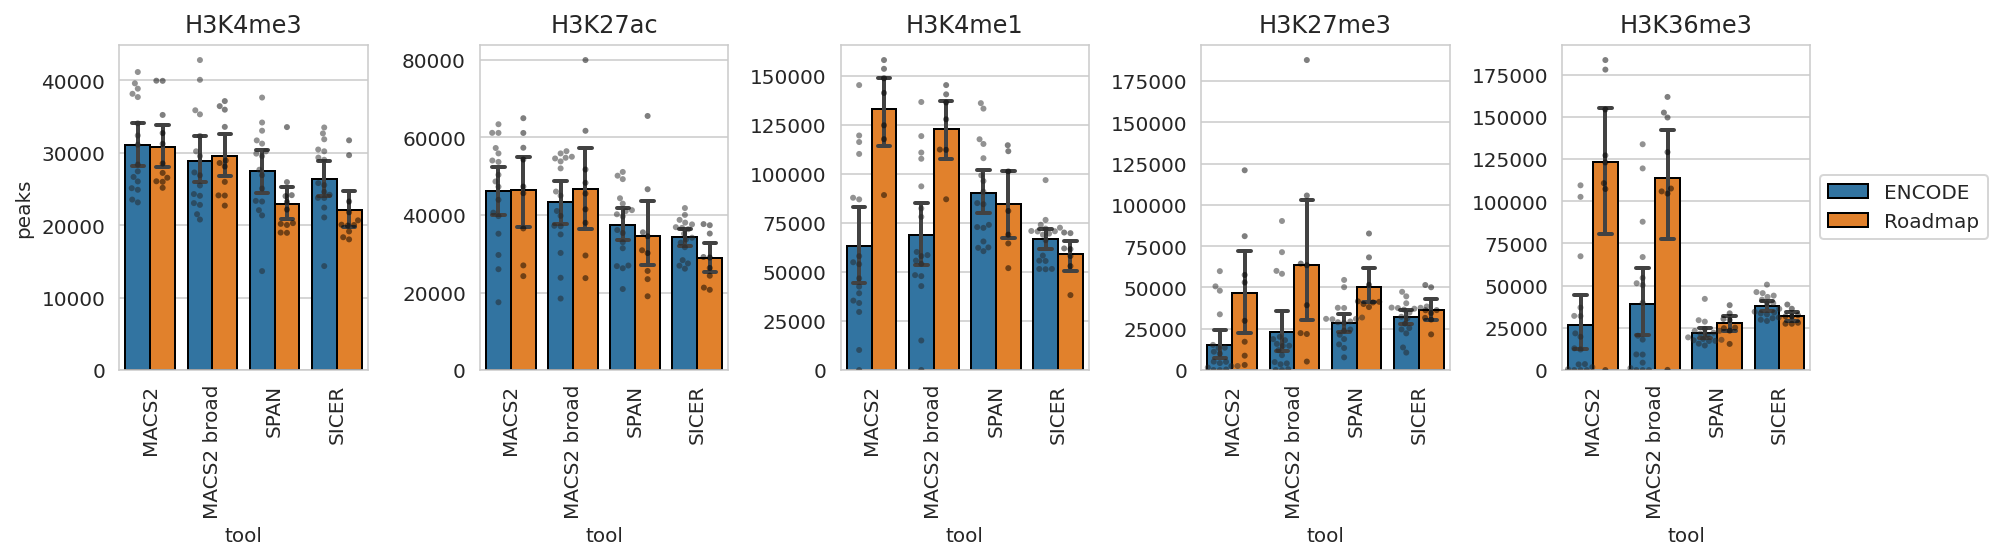

In [442]:
plt.figure(figsize=(14, 4))
axs = [plt.subplot(1, 5, i + 1) for i in range(5)]
for i, m in enumerate(MODIFICATIONS):
    ax = axs[i]
    sns.barplot(data=df_peaks[df_peaks['modification'] == m], x='tool', y='peaks', hue='dataset',
                capsize=.2, errwidth=2, edgecolor="black",
                # palette=TOOLS_PALETTE,
                order=['MACS2', 'MACS2 broad', 'SPAN', 'SICER'],
                hue_order=['ENCODE', 'Roadmap'],
                ax=ax)
    sns.swarmplot(data=df_peaks[df_peaks['modification'] == m], x='tool', y='peaks',  hue='dataset',
                  dodge=True, size=3, palette='dark:black', alpha=0.5, legend=False,
                  order=['MACS2', 'MACS2 broad', 'SPAN', 'SICER'],
                  hue_order=['ENCODE', 'Roadmap'],
                  ax=ax)
    ax.xaxis.set_tick_params(rotation=90)
    ax.title.set_text(m)
    if i > 0:
        ax.set_ylabel(None)
    else:
        ax.set_ylabel('peaks')
    if i < 4:
        ax.legend().set_visible(False)
    else:
        # Put a legend to the right of the current axis
        ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

    # ax.set_ylim(0, 1.9e7)
plt.tight_layout()
# plt.savefig(GSE26320_PATH_HG38 + f'/pics/library_mapped_detailed_all.pdf', bbox_inches='tight', dpi=300)
plt.show()

H3K4me3 ENCODE


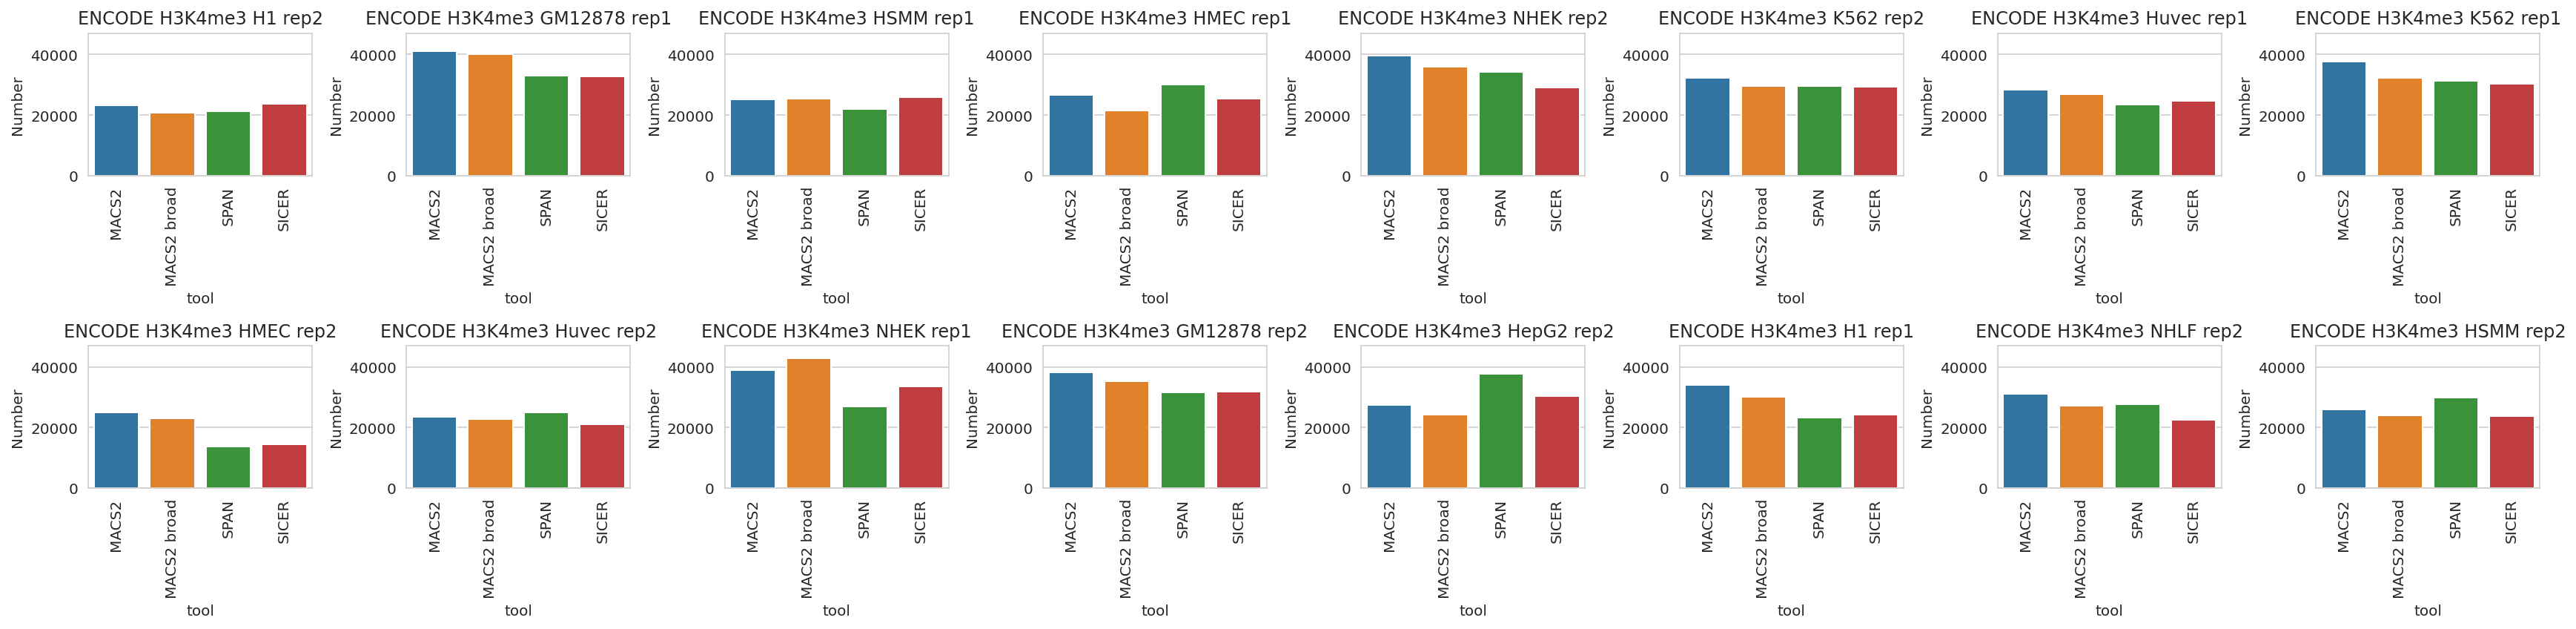

H3K4me3 Roadmap


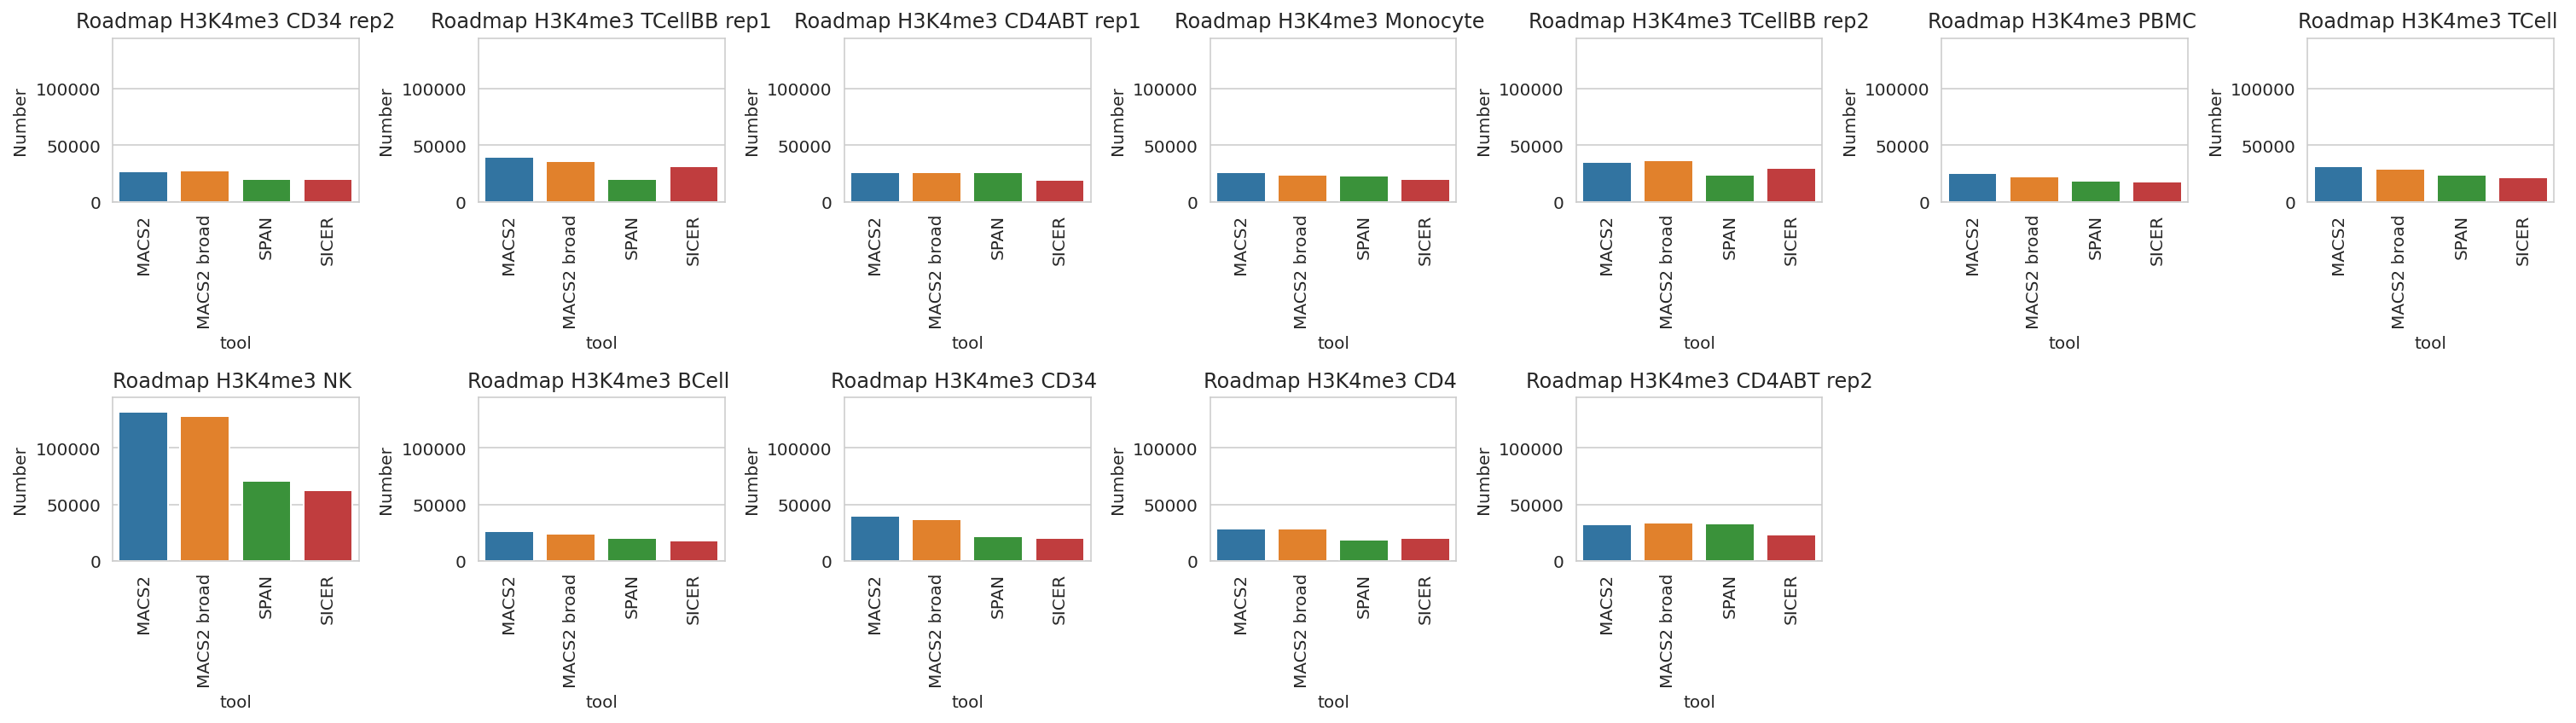

H3K27ac ENCODE


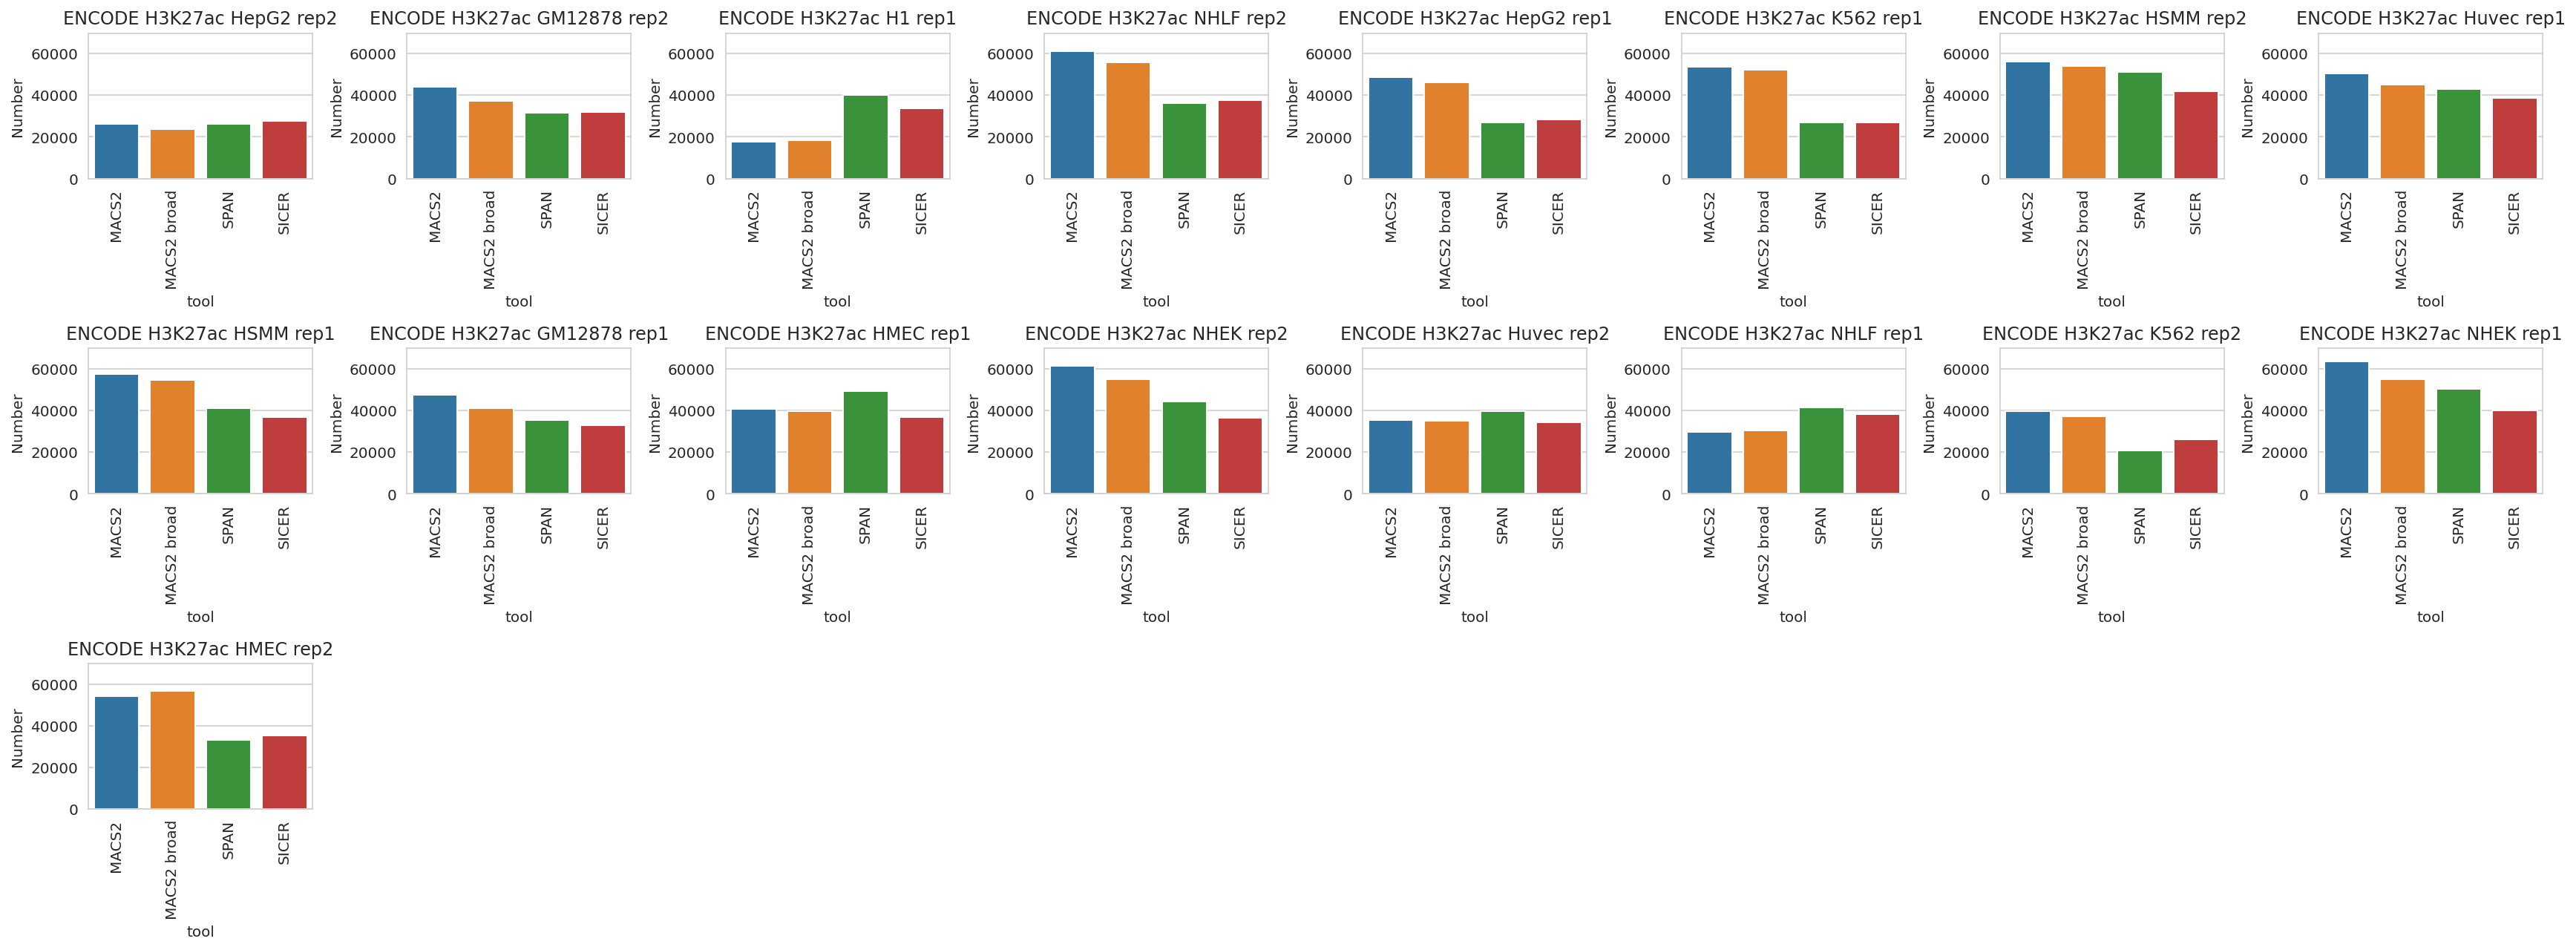

H3K27ac Roadmap


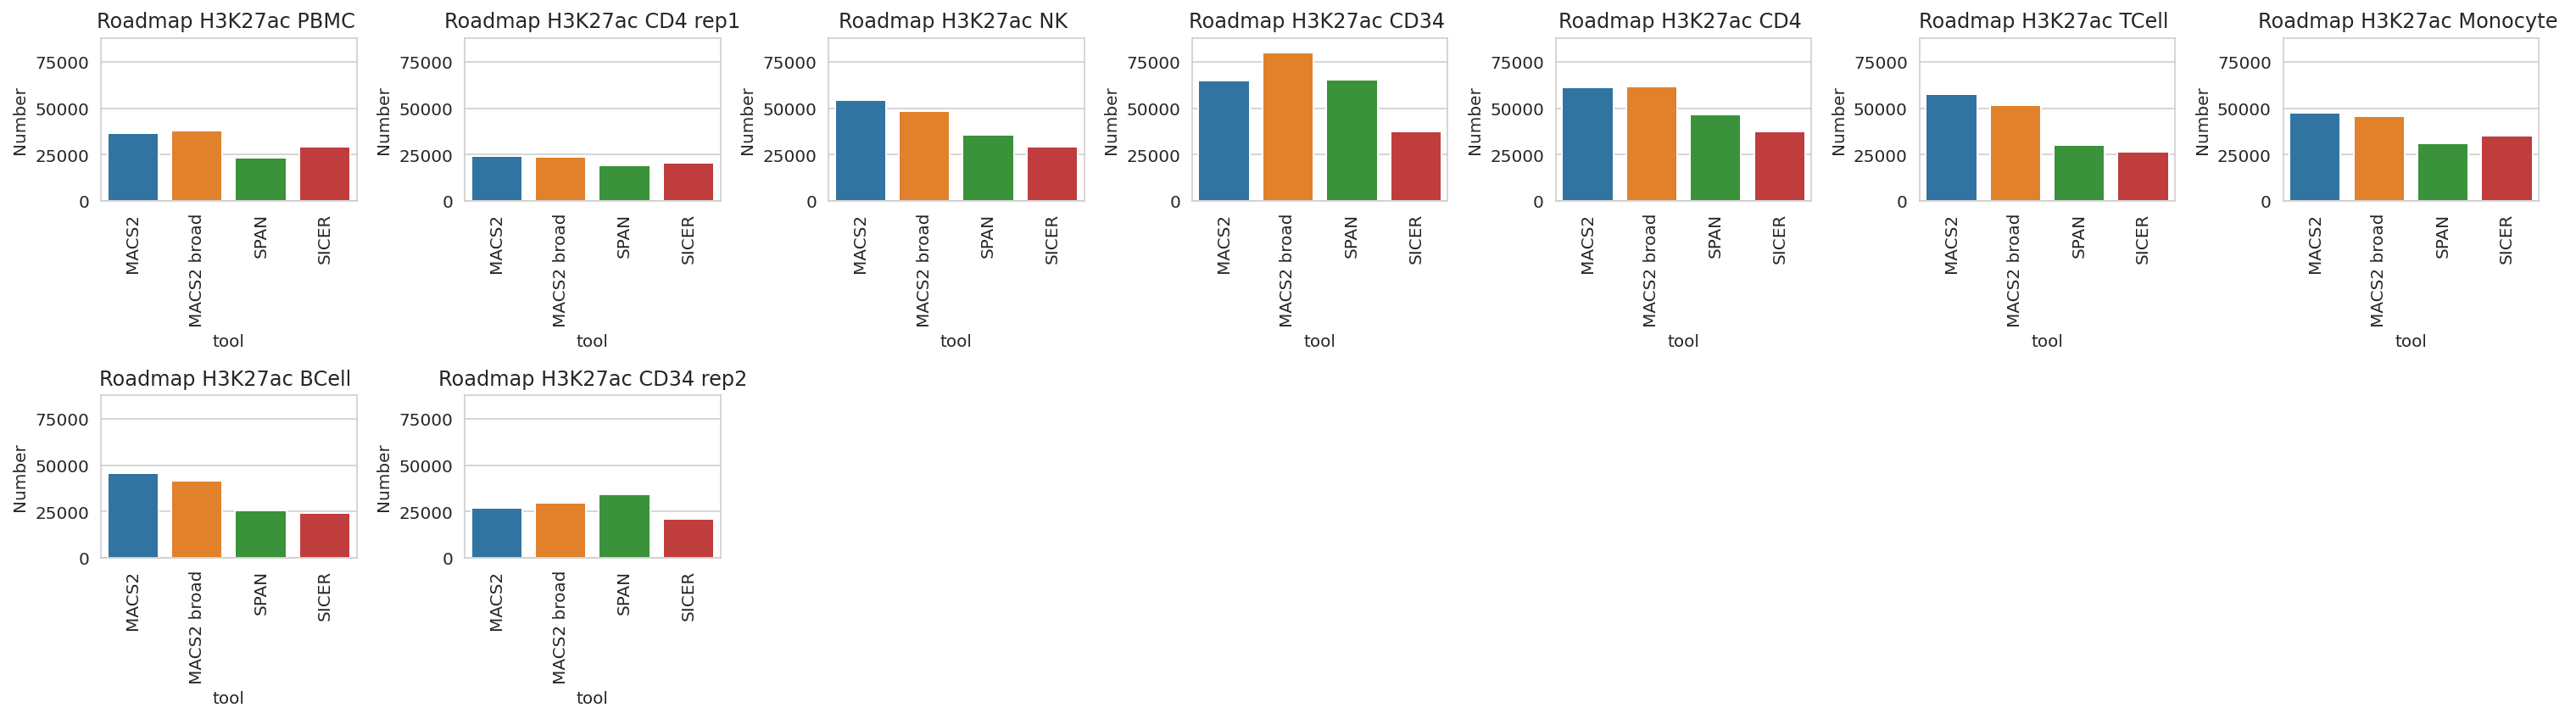

H3K4me1 ENCODE


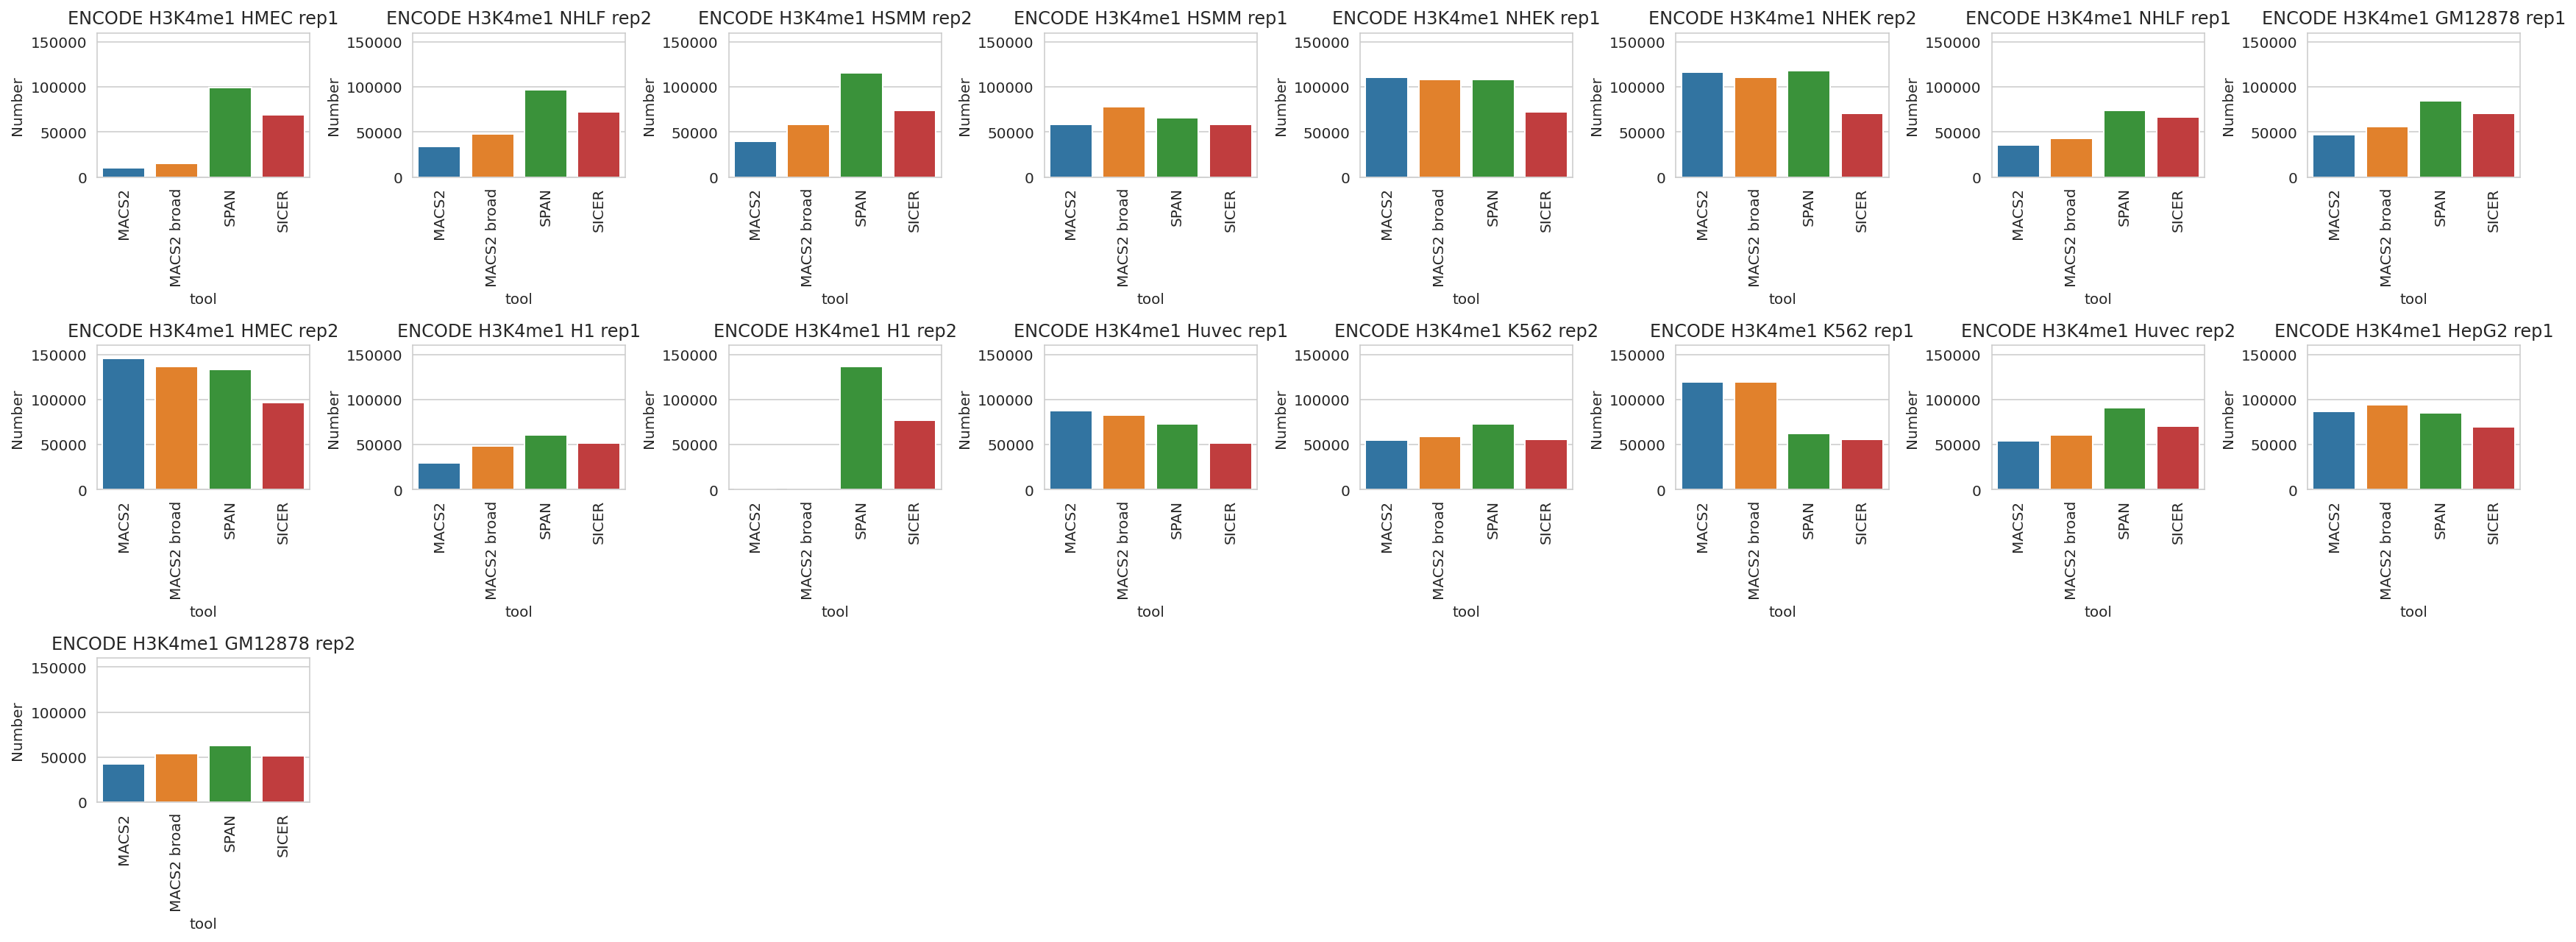

H3K4me1 Roadmap


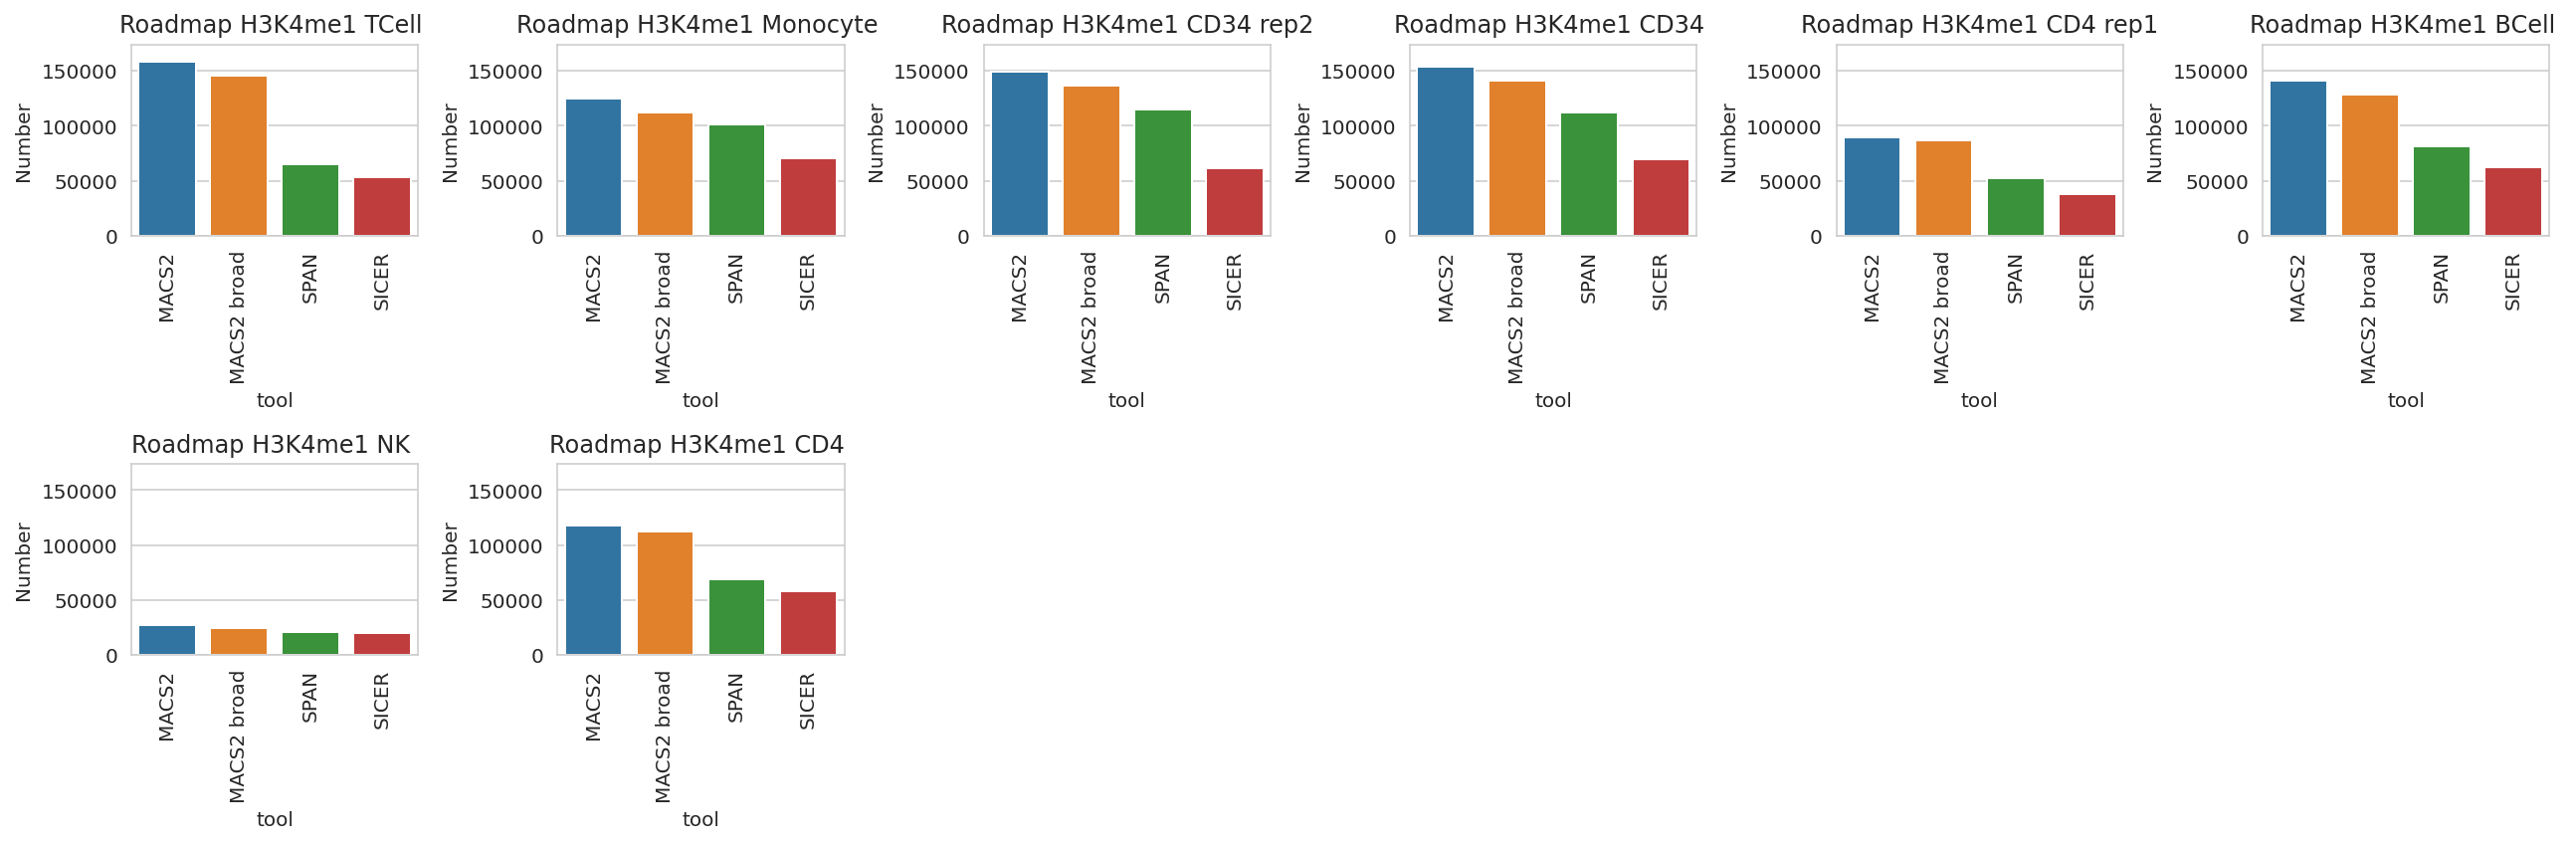

H3K27me3 ENCODE


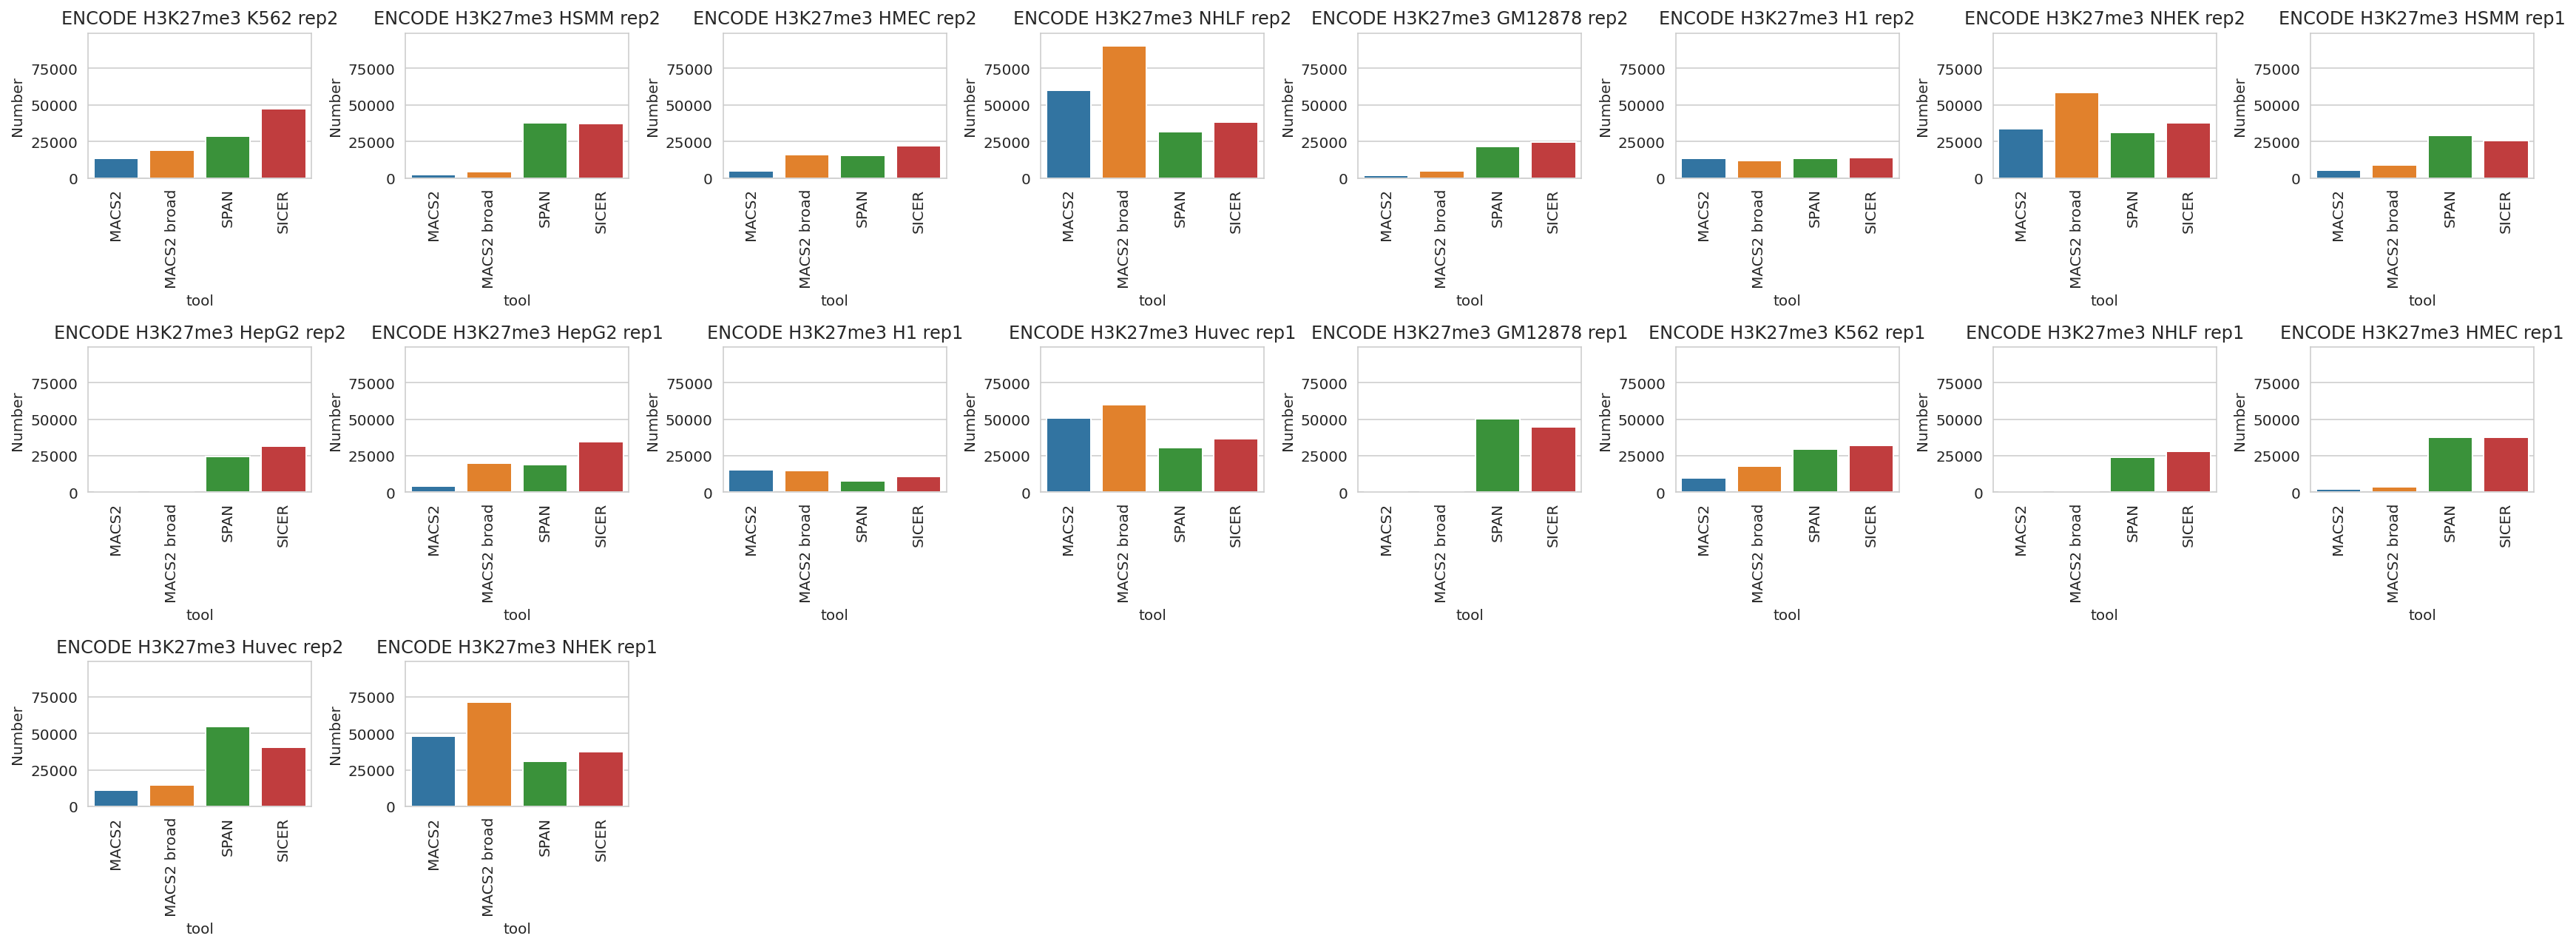

H3K27me3 Roadmap


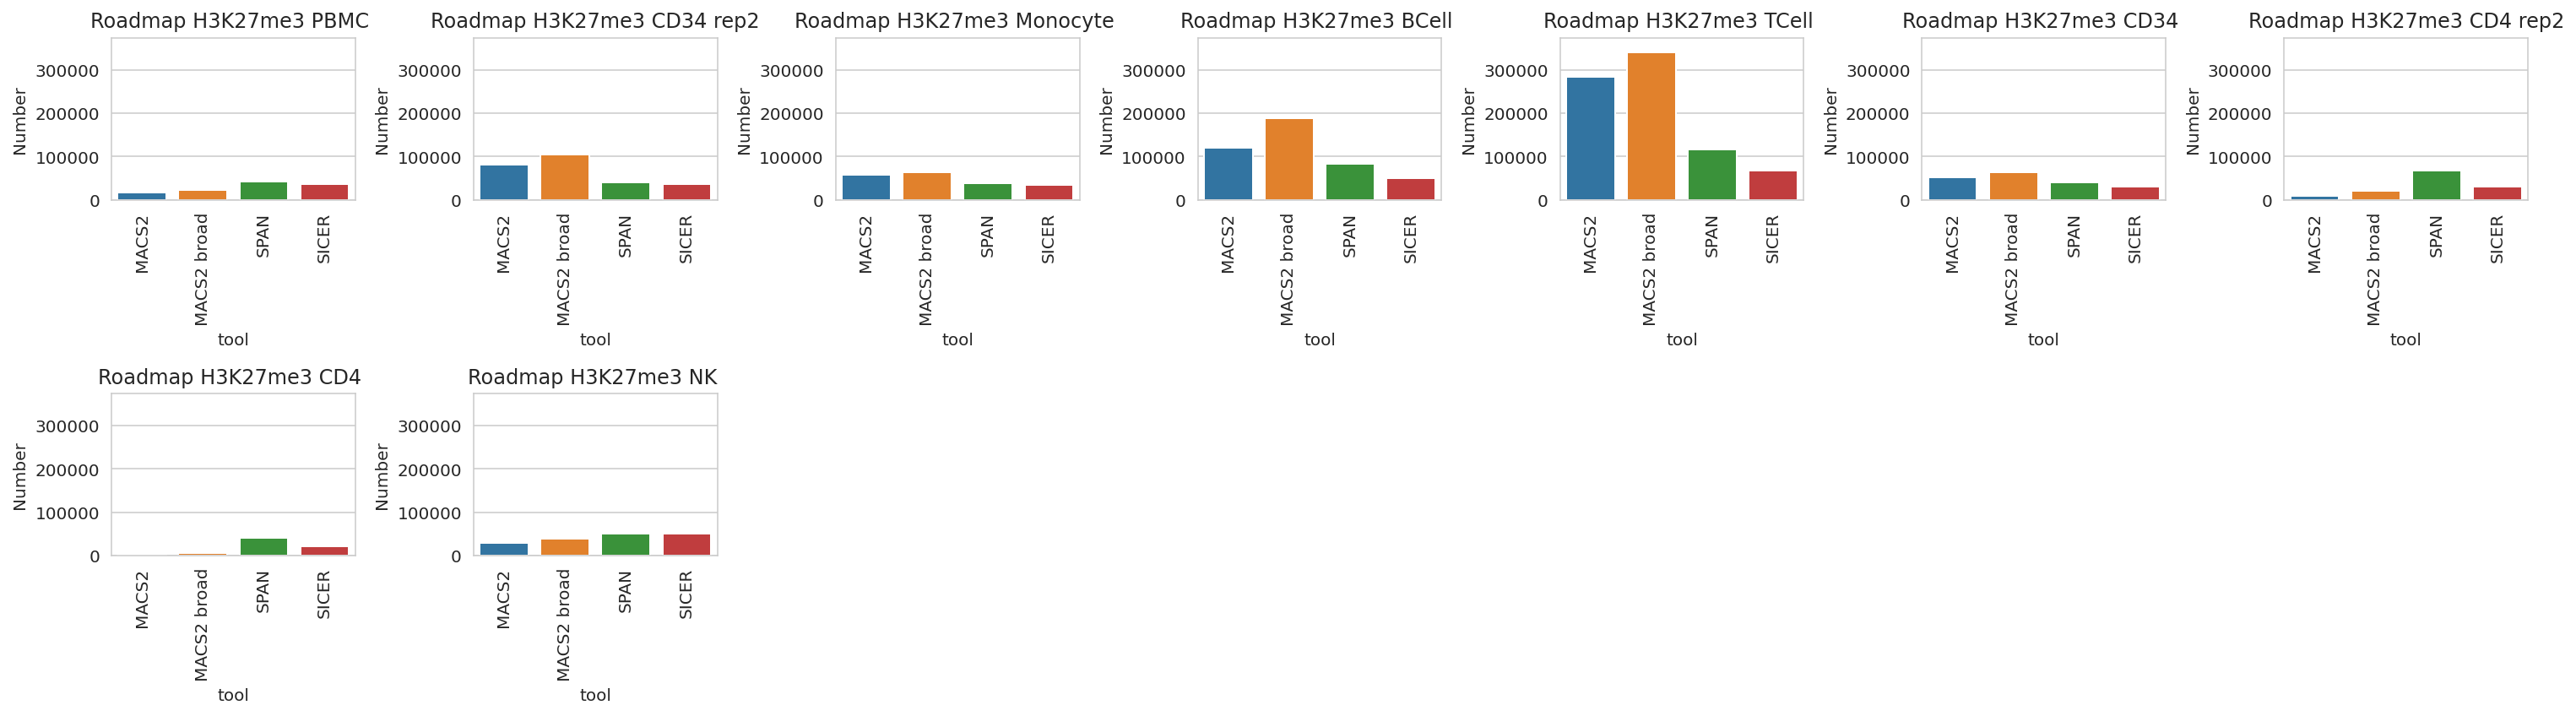

H3K36me3 ENCODE


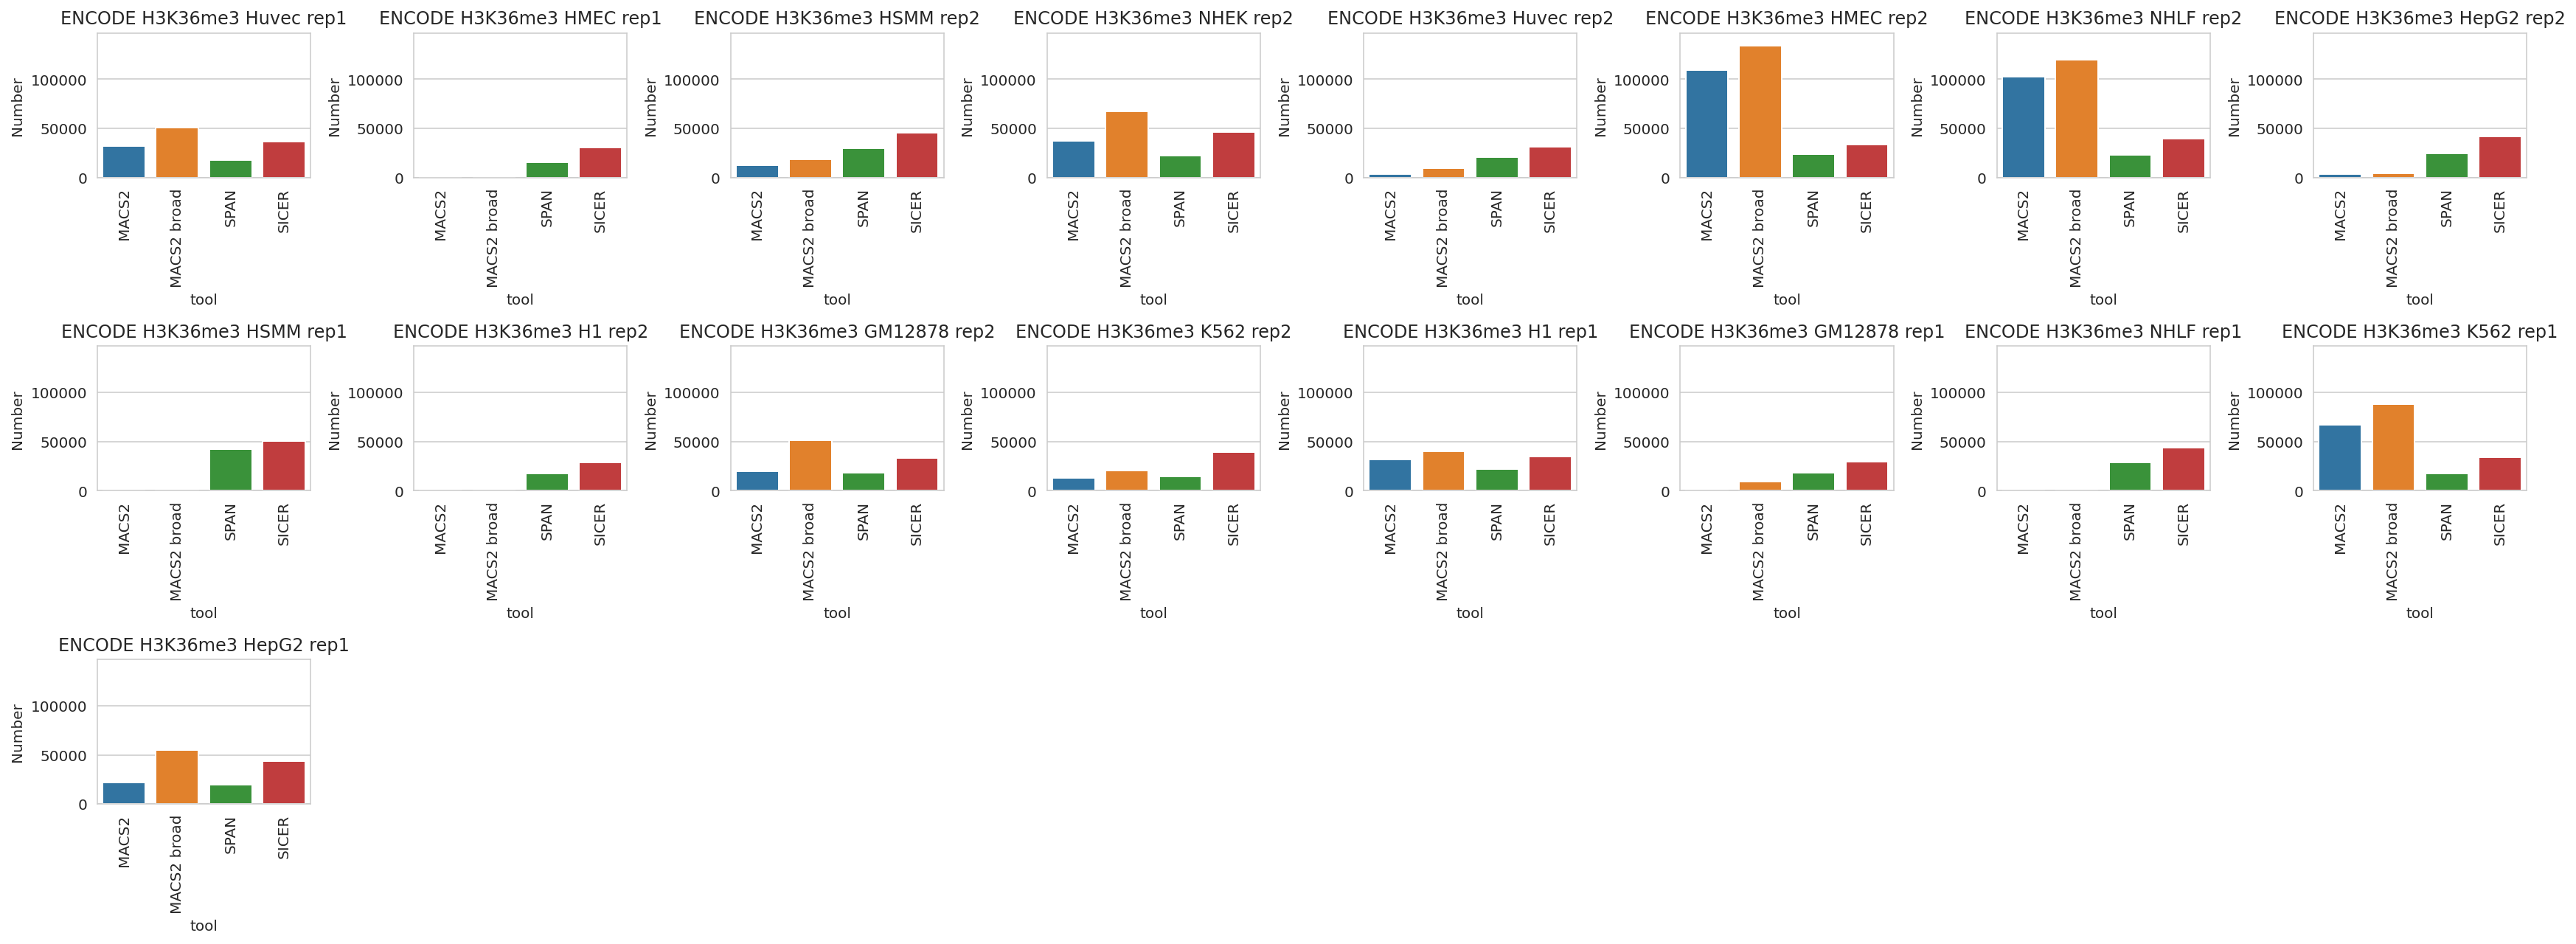

H3K36me3 Roadmap


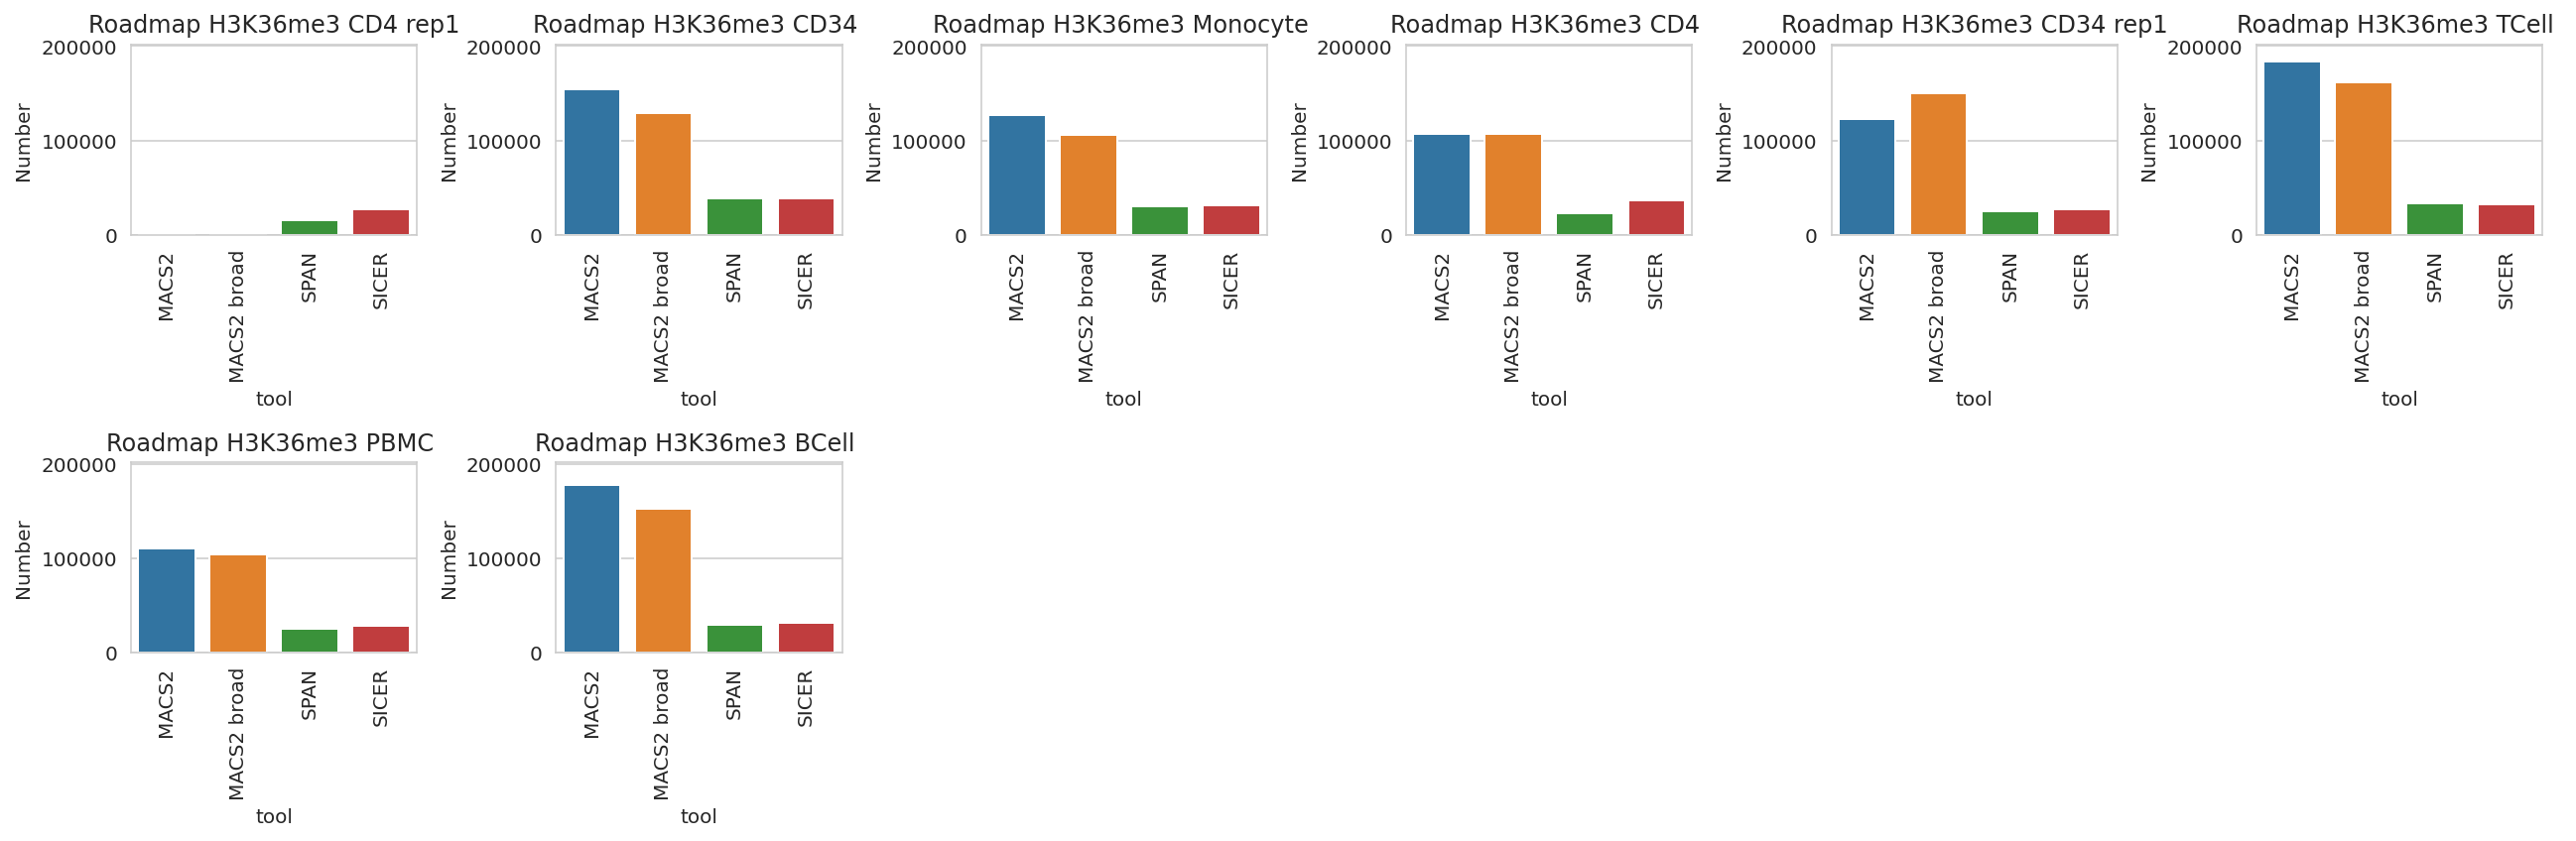

In [147]:
import math
for m, ds in product(MODIFICATIONS, ['ENCODE', 'Roadmap']):
    print(m, ds)
    t = df_peaks[(df_peaks['dataset'] == ds) & (df_peaks['modification'] == m)]
    experiments = [(c, r) for _, (c, r) in t[['cell', 'replicate']].drop_duplicates().iterrows()]
    ncols = int(math.floor(math.sqrt(len(experiments)) + 4))
    nrows = int(math.ceil(len(experiments) / ncols))
    plt.figure(figsize=(3 * ncols, 3 * nrows))
    axs = [plt.subplot(nrows, ncols, i + 1) for i in range(len(experiments))]
    for i, (c, r) in enumerate(experiments):
        ax = axs[i]
        ax.title.set_text(f'{ds} {m} {c} {r}')
        g_results = sns.barplot(data=t[(t['cell'] == c) & (t['replicate']==r)],
                            x='tool', y='peaks',
                            ax=ax,
                            capsize=.2, errwidth=2,
                            order=['MACS2', 'MACS2 broad', 'SPAN', 'SICER']
                            )
        ax.xaxis.set_tick_params(rotation=90)
        ax.set_ylabel('Number')
        ax.set_ylim(0, t['peaks'].max() * 1.1)
    plt.tight_layout()
    plt.show()

In [149]:
# Remove outliers
OUTLIERS = [('H3K4me3', 'NK', ''),
            ('H3K4me1', 'NK', ''),
            ('H3K27me3', 'TCell', '')]
df_peaks = df_peaks.loc[[(m, c, r) not in OUTLIERS
                         for _, (m, c, r) in df_peaks[['modification', 'cell', 'replicate']].iterrows()]].copy()

/home/jetbrains/miniconda3/envs/pubtrends/lib/python3.10/site-packages/seaborn/categorical.py:3544: UserWarning: 5.6% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/jetbrains/miniconda3/envs/pubtrends/lib/python3.10/site-packages/seaborn/categorical.py:3544: UserWarning: 5.6% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


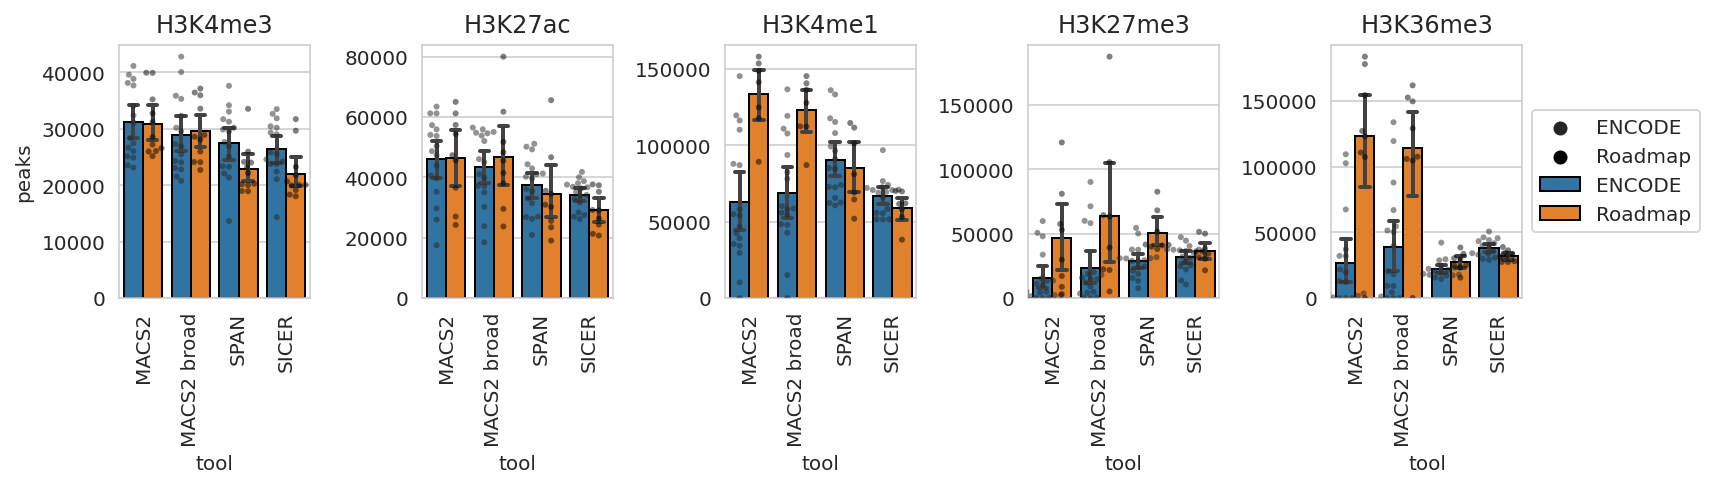

In [443]:
plt.figure(figsize=(12, 3.5))
axs = [plt.subplot(1, 5, i + 1) for i in range(5)]
for i, m in enumerate(MODIFICATIONS):
    ax = axs[i]
    sns.barplot(data=df_peaks[df_peaks['modification'] == m], x='tool', y='peaks', hue='dataset',
                capsize=.2, errwidth=2, edgecolor="black",
                # palette=TOOLS_PALETTE,
                order=['MACS2', 'MACS2 broad', 'SPAN', 'SICER'],
                hue_order=['ENCODE', 'Roadmap'],
                ax=ax)
    sns.swarmplot(data=df_peaks[df_peaks['modification'] == m], x='tool', y='peaks',  hue='dataset',
                  dodge=True, size=3, palette='dark:black', alpha=0.5,
                  order=['MACS2', 'MACS2 broad', 'SPAN', 'SICER'],
                  hue_order=['ENCODE', 'Roadmap'],
                  ax=ax)
    ax.xaxis.set_tick_params(rotation=90)
    ax.title.set_text(m)
    if i > 0:
        ax.set_ylabel(None)
    else:
        ax.set_ylabel('peaks')
    if i < len(axs) -1:
        ax.legend().set_visible(False)
    else:
        # Put a legend to the right of the current axis
        ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

    # ax.set_ylim(0, 1.9e7)
plt.tight_layout()
# plt.savefig(GSE26320_PATH_HG38 + f'/pics/library_mapped_detailed_all.pdf', bbox_inches='tight', dpi=300)
plt.show()

ENCODE only


/tmp/ipykernel_2375599/2360411747.py:12: FutureWarning: Passing `palette` without assigning `hue` is deprecated.
  sns.swarmplot(data=df_peaks[(df_peaks['dataset'] == 'ENCODE') & (df_peaks['modification'] == m)], x='tool', y='peaks',
/tmp/ipykernel_2375599/2360411747.py:12: FutureWarning: Passing `palette` without assigning `hue` is deprecated.
  sns.swarmplot(data=df_peaks[(df_peaks['dataset'] == 'ENCODE') & (df_peaks['modification'] == m)], x='tool', y='peaks',
/tmp/ipykernel_2375599/2360411747.py:12: FutureWarning: Passing `palette` without assigning `hue` is deprecated.
  sns.swarmplot(data=df_peaks[(df_peaks['dataset'] == 'ENCODE') & (df_peaks['modification'] == m)], x='tool', y='peaks',
/tmp/ipykernel_2375599/2360411747.py:12: FutureWarning: Passing `palette` without assigning `hue` is deprecated.
  sns.swarmplot(data=df_peaks[(df_peaks['dataset'] == 'ENCODE') & (df_peaks['modification'] == m)], x='tool', y='peaks',
/tmp/ipykernel_2375599/2360411747.py:12: FutureWarning: Passing 

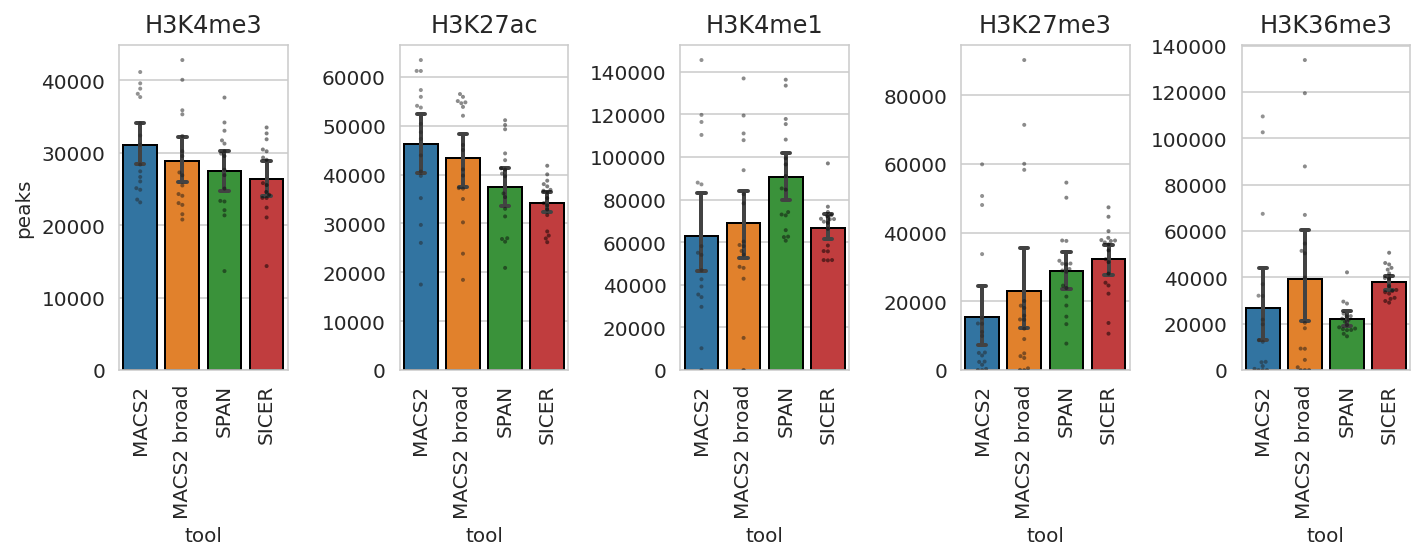

In [507]:
print('ENCODE only')
plt.figure(figsize=(10, 4))
axs = [plt.subplot(1, 5, i + 1) for i in range(5)]
for i, m in enumerate(MODIFICATIONS):
    ax = axs[i]
    sns.barplot(data=df_peaks[(df_peaks['dataset'] == 'ENCODE') & (df_peaks['modification'] == m)], x='tool', y='peaks',
                # showfliers=False,
                capsize=.2, errwidth=2, edgecolor="black",
                palette=TOOLS_PALETTE,
                order=['MACS2', 'MACS2 broad', 'SPAN', 'SICER'],
                ax=ax)
    sns.swarmplot(data=df_peaks[(df_peaks['dataset'] == 'ENCODE') & (df_peaks['modification'] == m)], x='tool', y='peaks',
                  size=2, palette='dark:black', alpha=0.5,
                  order=['MACS2', 'MACS2 broad', 'SPAN', 'SICER'], legend=False,
                  ax=ax)
    ax.xaxis.set_tick_params(rotation=90)
    ax.title.set_text(m)
    if i > 0:
        ax.set_ylabel(None)
    # ax.set_ylim(0, 1)
plt.tight_layout()
# plt.savefig(GSE26320_PATH_HG38 + f'/pics/library_mapped_detailed_all.pdf', bbox_inches='tight', dpi=300)
plt.show()

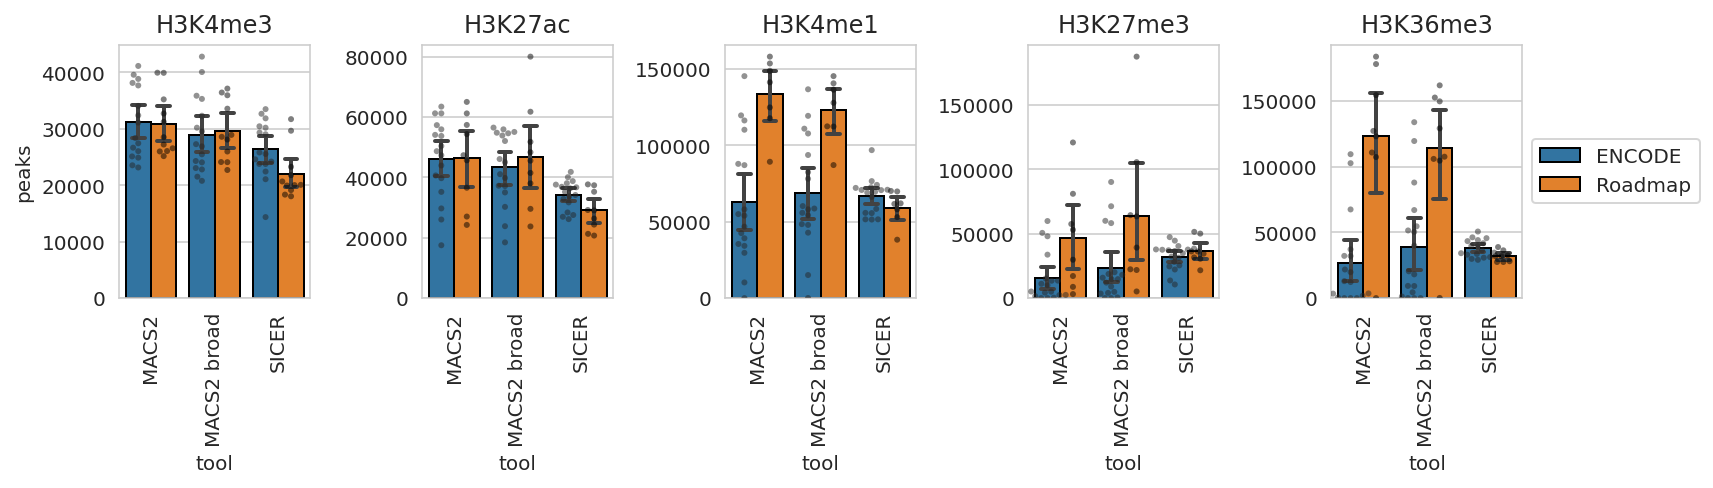

In [444]:
plt.figure(figsize=(12, 3.5))
axs = [plt.subplot(1, 5, i + 1) for i in range(5)]
for i, m in enumerate(MODIFICATIONS):
    ax = axs[i]
    sns.barplot(data=df_peaks[df_peaks['modification'] == m], x='tool', y='peaks', hue='dataset',
                capsize=.2, errwidth=2, edgecolor="black",
                # palette=TOOLS_PALETTE,
                order=['MACS2', 'MACS2 broad', 'SICER'],
                hue_order=['ENCODE', 'Roadmap'],
                ax=ax)
    sns.swarmplot(data=df_peaks[df_peaks['modification'] == m], x='tool', y='peaks',  hue='dataset',
                  dodge=True, size=3, palette='dark:black', alpha=0.5, legend=False,
                  order=['MACS2', 'MACS2 broad', 'SICER'],
                  hue_order=['ENCODE', 'Roadmap'],
                  ax=ax)
    ax.xaxis.set_tick_params(rotation=90)
    ax.title.set_text(m)
    if i > 0:
        ax.set_ylabel(None)
    else:
        ax.set_ylabel('peaks')
    if i < len(axs) -1:
        ax.legend().set_visible(False)
    else:
        # Put a legend to the right of the current axis
        ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

    # ax.set_ylim(0, 1.9e7)
plt.tight_layout()
# plt.savefig(GSE26320_PATH_HG38 + f'/pics/library_mapped_detailed_all.pdf', bbox_inches='tight', dpi=300)
plt.show()

In [152]:
df_peaks['ds_c_r'] = df_peaks['dataset'] + ' ' + df_peaks['cell'] + ' ' + df_peaks['replicate']
print('H3K4me1 MACS2 broad ENCODE < 60k peaks')
g1 = df_peaks[(df_peaks['modification'] == 'H3K4me1') & 
              (df_peaks['dataset'] == 'ENCODE') & 
              (df_peaks['tool'] == 'MACS2 broad') & 
              (df_peaks['peaks'] < 60_000)].copy()
display(g1)

print('H3K4me1 MACS2 broad ENCODE > 80k peaks')
g2 = df_peaks[(df_peaks['modification'] == 'H3K4me1') &
              (df_peaks['dataset'] == 'ENCODE') &
              (df_peaks['tool'] == 'MACS2 broad') &
              (df_peaks['peaks'] > 80_000)].copy()

display(g2)

g1_ds_c_r = set(g1['ds_c_r'])
g2_ds_c_r = set(g2['ds_c_r'])

H3K4me1 MACS2 broad ENCODE < 60k peaks


file modification     cell  \
108  /home/jetbrains/data/2023_GSE26320/macs2/GSM64...      H3K4me1  GM12878   
115  /home/jetbrains/data/2023_GSE26320/macs2/GSM64...      H3K4me1     HSMM   
124  /home/jetbrains/data/2023_GSE26320/macs2/GSM64...      H3K4me1     HMEC   
129  /home/jetbrains/data/2023_GSE26320/macs2/GSM64...      H3K4me1     NHLF   
130  /home/jetbrains/data/2023_GSE26320/macs2/GSM64...      H3K4me1  GM12878   
142  /home/jetbrains/data/2023_GSE26320/macs2/GSM64...      H3K4me1     NHLF   
144  /home/jetbrains/data/2023_GSE26320/macs2/GSM64...      H3K4me1       H1   
148  /home/jetbrains/data/2023_GSE26320/macs2/GSM64...      H3K4me1     K562   
161  /home/jetbrains/data/2023_GSE26320/macs2/GSM64...      H3K4me1       H1   

    replicate  peaks         tool dataset               ds_c_r  
108      rep1  55876  MACS2 broad  ENCODE  ENCODE GM12878 rep1  
115      rep2  58165  MACS2 broad  ENCODE     ENCODE HSMM rep2  
124      rep1  15099  MACS2 broad  ENCODE     ENCODE HMEC rep1  
129      rep1  42869  MACS2 broad  ENCODE     ENCODE NHLF rep1  
130      rep2  54232  MACS2 broad  ENCODE  ENCODE GM12878 rep2  
142      rep2  47946  MACS2 broad  ENCODE     ENCODE NHLF rep2  
144      rep1  48462  MACS2 broad  ENCODE       ENCODE H1 rep1  
148      rep2  58678  MACS2 broad  ENCODE     ENCODE K562 rep2  
161      rep2     62  MACS2 broad  ENCODE       ENCODE H1 rep2

H3K4me1 MACS2 broad ENCODE > 80k peaks


file modification   cell  \
86   /home/jetbrains/data/2023_GSE26320/macs2/GSM64...      H3K4me1  Huvec   
93   /home/jetbrains/data/2023_GSE26320/macs2/GSM64...      H3K4me1   NHEK   
112  /home/jetbrains/data/2023_GSE26320/macs2/GSM64...      H3K4me1   K562   
119  /home/jetbrains/data/2023_GSE26320/macs2/GSM64...      H3K4me1   HMEC   
141  /home/jetbrains/data/2023_GSE26320/macs2/GSM64...      H3K4me1   NHEK   
167  /home/jetbrains/data/2023_GSE26320/macs2/GSM64...      H3K4me1  HepG2   

    replicate   peaks         tool dataset             ds_c_r  
86       rep1   82501  MACS2 broad  ENCODE  ENCODE Huvec rep1  
93       rep1  107843  MACS2 broad  ENCODE   ENCODE NHEK rep1  
112      rep1  119404  MACS2 broad  ENCODE   ENCODE K562 rep1  
119      rep2  136806  MACS2 broad  ENCODE   ENCODE HMEC rep2  
141      rep2  111005  MACS2 broad  ENCODE   ENCODE NHEK rep2  
167      rep1   93762  MACS2 broad  ENCODE  ENCODE HepG2 rep1

Peaks


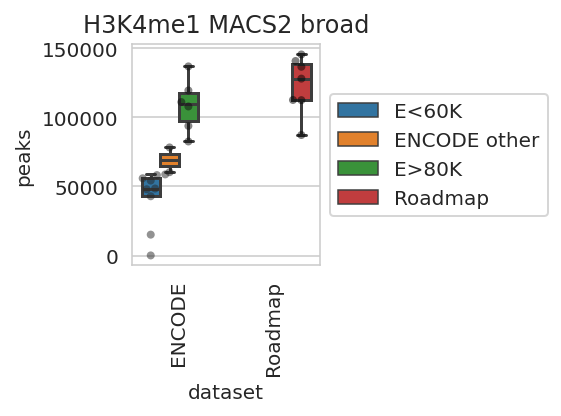

In [445]:
print('Peaks')
plt.figure(figsize=(4, 3))
ax = plt.axes()
t = df_peaks[(df_peaks['modification'] == 'H3K4me1') & (df_peaks['tool'] == 'MACS2 broad')]
sns.boxplot(data=t, x='dataset', y='peaks',
            hue=['E<60K' if dscr in g1_ds_c_r else 'E>80K' if dscr in g2_ds_c_r else
            'ENCODE other' if 'ENCODE' in dscr else 'Roadmap' for dscr in t['ds_c_r']],
            hue_order=['E<60K', 'ENCODE other', 'E>80K', 'Roadmap'],
            showfliers=False,
            ax=ax)
sns.swarmplot(data=t, x='dataset', y='peaks',
              hue=['E<60K' if dscr in g1_ds_c_r else 'E>80K' if dscr in g2_ds_c_r else
              'ENCODE other' if 'ENCODE' in dscr else 'Roadmap' for dscr in t['ds_c_r']],
              hue_order=['E<60K', 'ENCODE other', 'E>80K', 'Roadmap'],
              dodge=True, size=4, palette='dark:black', alpha=0.5, legend=False,
              ax=ax)

sns.move_legend(ax, loc='center left', bbox_to_anchor=(1, 0.5))
ax.title.set_text('H3K4me1 MACS2 broad')
ax.xaxis.set_tick_params(rotation=90)

plt.tight_layout()
plt.show()

# Lengths

In [17]:
print('Load lengths')
ts = []
for dataset, mod, cell, rep, file, tool in tqdm(zip(
        df_peaks['dataset'], df_peaks['modification'], df_peaks['cell'], df_peaks['replicate'], df_peaks['file'],
        df_peaks['tool']
)):
    lengths = bedl(file)
    t = pd.DataFrame(dict(length=lengths))
    t = t.sample(min(len(t), 10_000)).copy()
    t['dataset'] = dataset
    t['modification'] = mod
    t['cell'] = cell
    t['replicate'] = rep
    t['tool'] = tool
    t['footprint'] = sum(lengths)
    t['ds_c_r'] = dataset + ' ' + cell + ' ' + rep
    ts.append(t)
df_lens = pd.concat(ts).reset_index(drop=True)
del ts, t
df_lens.sample(10)

Load lengths


0it [00:00, ?it/s]

length  dataset modification     cell replicate         tool  \
913646    741.0   ENCODE      H3K4me3    Huvec      rep2  MACS2 broad   
3452331   305.0  Roadmap     H3K27me3     CD34                  MACS2   
2871796  3255.0   ENCODE     H3K27me3     NHEK      rep2         SPAN   
1308764   784.0   ENCODE     H3K36me3     K562      rep2  MACS2 broad   
1369045   271.0   ENCODE     H3K27me3       H1      rep2  MACS2 broad   
47687    1677.0   ENCODE      H3K27ac  GM12878      rep2        MACS2   
2644250   758.0   ENCODE      H3K4me3     NHEK      rep1         SPAN   
742857    252.0   ENCODE     H3K36me3     NHEK      rep2  MACS2 broad   
763705    228.0   ENCODE      H3K27ac     NHEK      rep2  MACS2 broad   
1836471  3999.0   ENCODE      H3K27ac  GM12878      rep1        SICER   

         footprint               ds_c_r  
913646    19373611    ENCODE Huvec rep2  
3452331   29118068        Roadmap CD34   
2871796  318777755     ENCODE NHEK rep2  
1308764   10646591     ENCODE K562 rep2  
1369045   17324414       ENCODE H1 rep2  
47687     38095017  ENCODE GM12878 rep2  
2644250   48944562     ENCODE NHEK rep1  
742857    32652182     ENCODE NHEK rep2  
763705    49103047     ENCODE NHEK rep2  
1836471  124120539  ENCODE GM12878 rep1

In [18]:
# for ds in ['ENCODE', 'Roadmap']:
#     print(ds)
#     plt.figure(figsize=(18, 3))    
#     axs = [plt.subplot(1, 5, i + 1) for i in range(5)]
#     for i, m in enumerate(MODIFICATIONS):
#         ax = axs[i]
#         g_results = sns.histplot(data=df_lens[(df_lens['dataset'] == ds) & (df_lens['modification'] == m)], 
#                                  x='length', hue='tool', ax=ax,
#                                  stat='density', common_bins=False, common_norm=False,
#                                  bins=50, kde=True, log_scale=True, alpha=0.2,
#                                  palette=TOOLS_PALETTE,
#                                  hue_order=TOOLS)
#         g_results.set(xscale='log')
#         g_results.set_ylim(0, 3)
#         g_results.set_xlim(1e2, 7e4)
#         ax.title.set_text(m)
#         if i < len(axs) - 1:
#             ax.legend().set_visible(False)
#         else:
#             sns.move_legend(ax, loc='center left', bbox_to_anchor=(1, 0.5))
#     plt.tight_layout()
#     plt.show()    
#     

H3K4me3


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


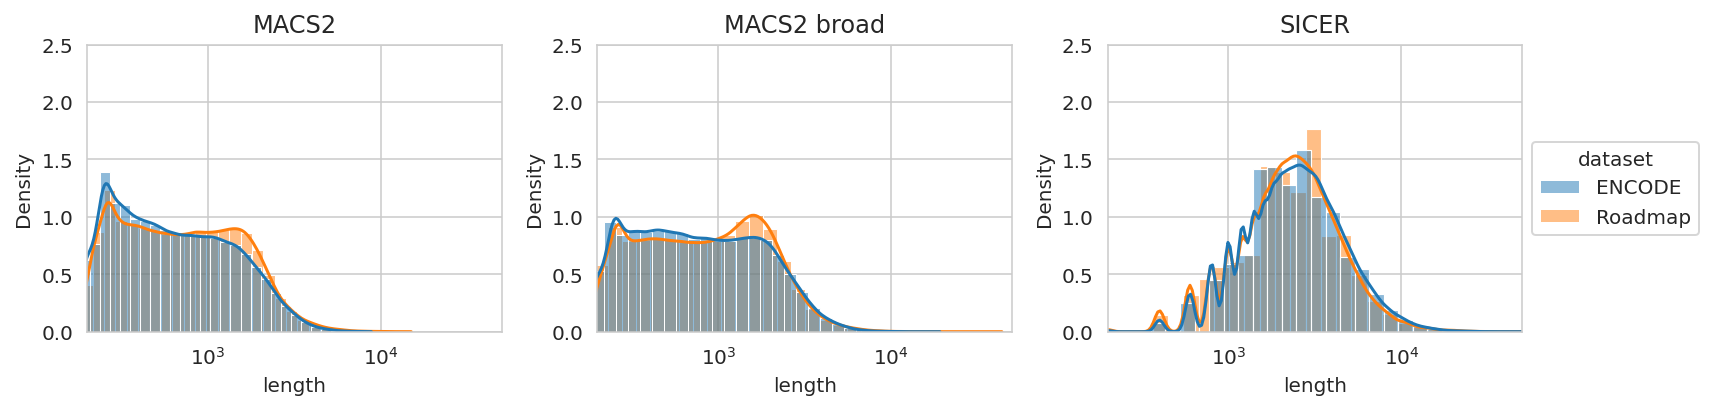

H3K27ac


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


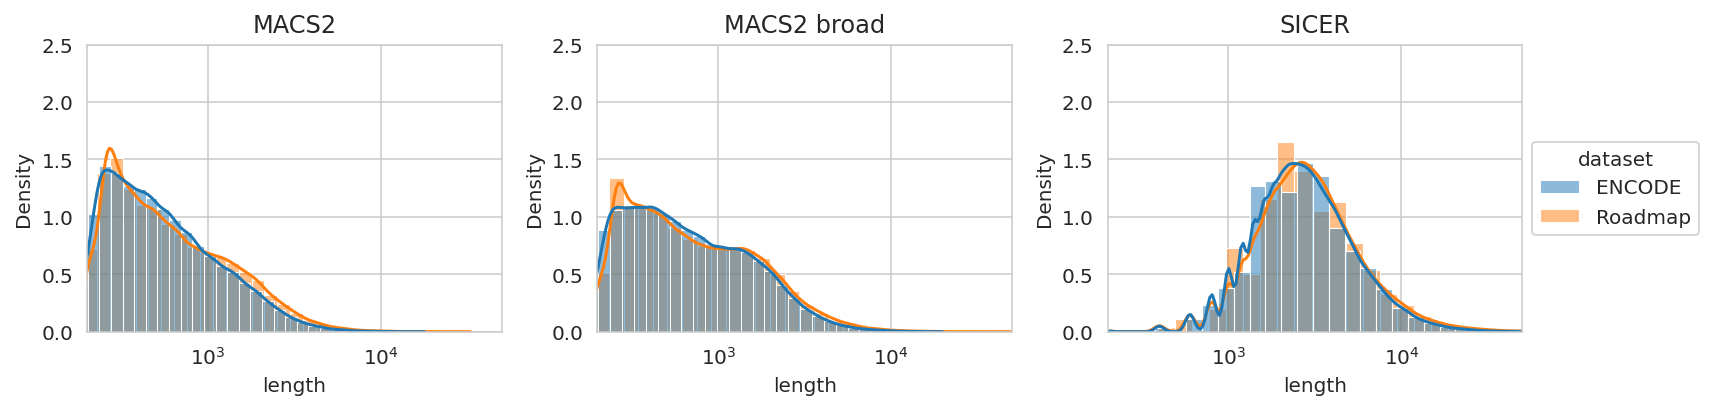

H3K4me1


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


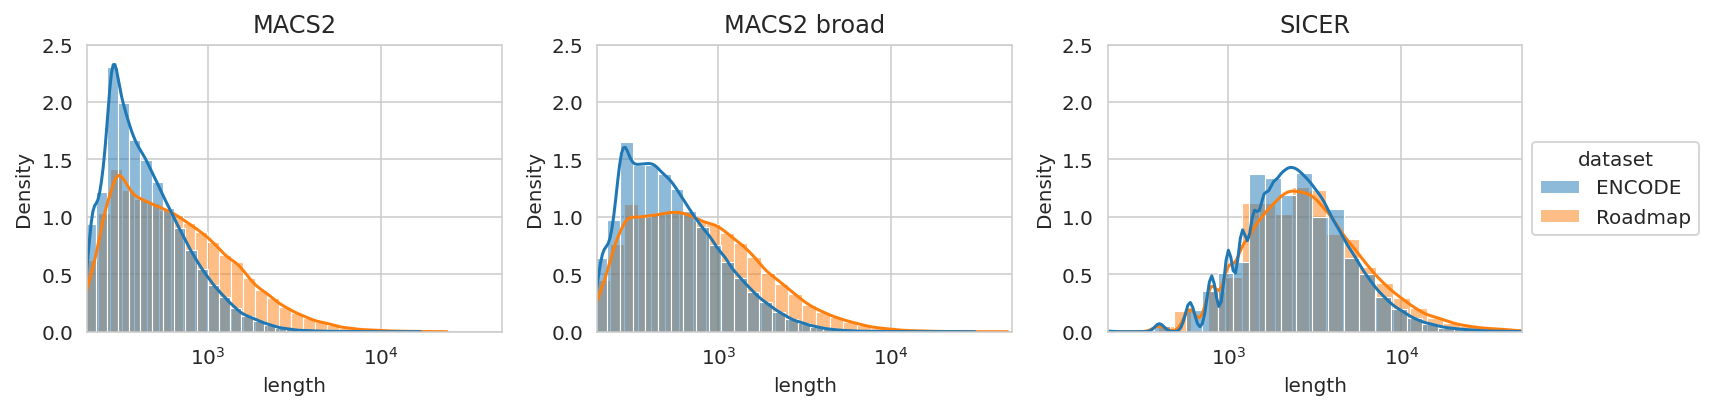

H3K27me3


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


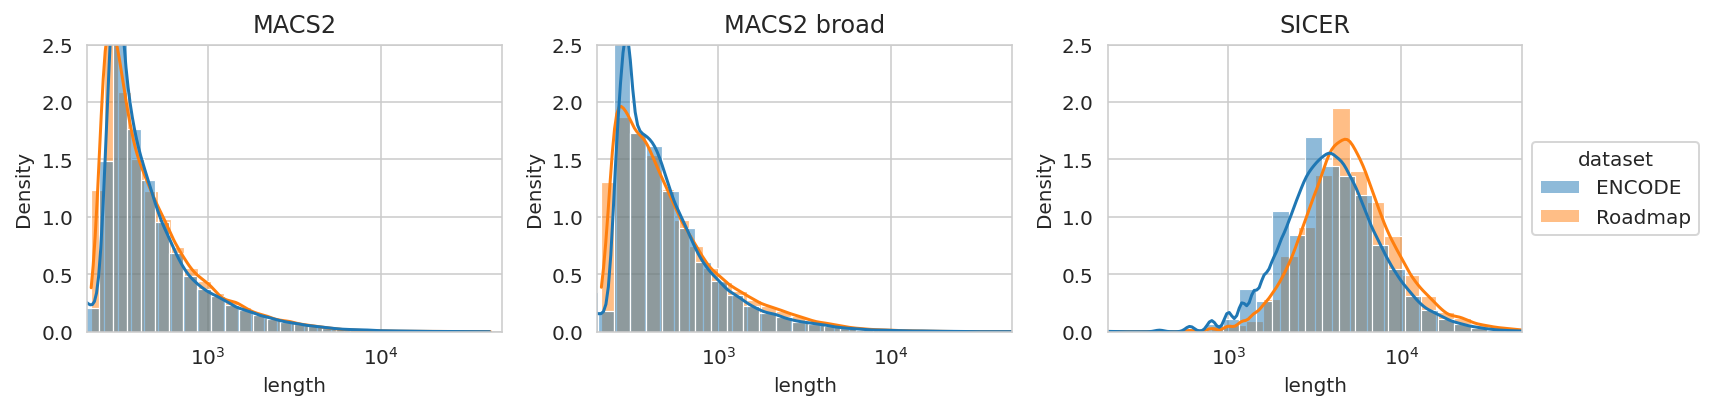

H3K36me3


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


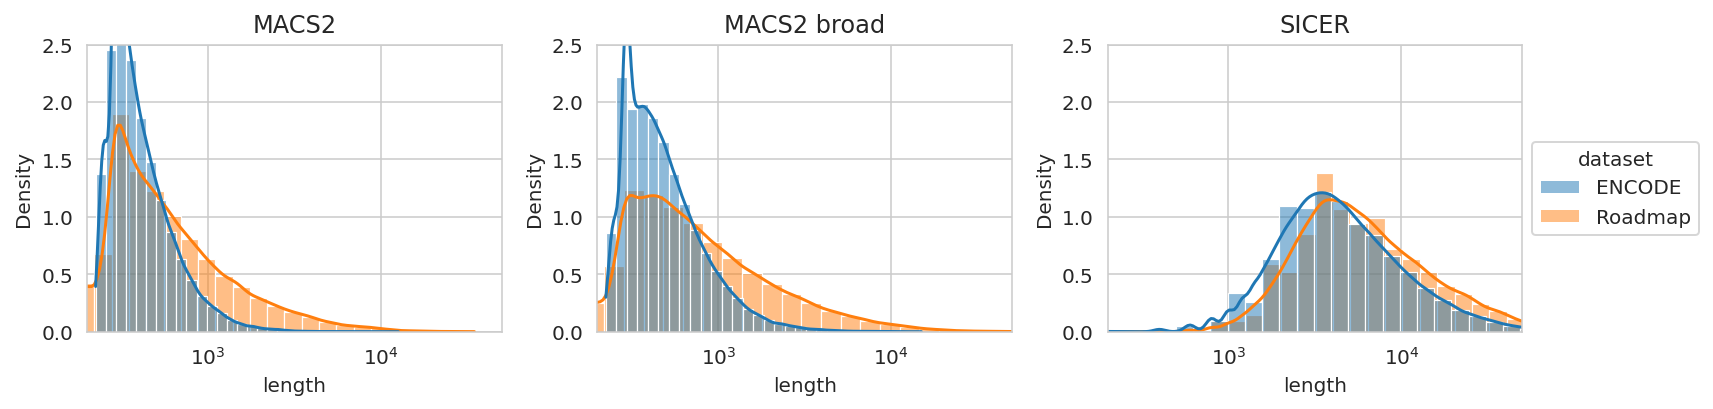

In [19]:
for m in ['H3K4me3', 'H3K27ac', 'H3K4me1', 'H3K27me3', 'H3K36me3']:
    print(m)
    plt.figure(figsize=(12, 3))
    axs = [plt.subplot(1, 3, i + 1) for i in range(3)]
    for i, tool in enumerate(['MACS2', 'MACS2 broad', 'SICER']):
        ax = axs[i]
        g_results = sns.histplot(data=df_lens[(df_lens['modification'] == m) & (df_lens['tool'] == tool)],
                                 x='length', hue='dataset', ax=ax,
                                 stat='density', common_bins=False, common_norm=False,
                                 bins=30, kde=True, log_scale=True, alpha=0.5,
                                 # palette=TOOLS_PALETTE,
                                 )
        g_results.set(xscale='log')
        g_results.set_ylim(0, 2.5)
        g_results.set_xlim(200, 5e4)
        ax.title.set_text(f'{tool}')
        if i < len(axs) - 1:
            ax.legend().set_visible(False)
        else:
            sns.move_legend(ax, loc='center left', bbox_to_anchor=(1, 0.5))
    plt.tight_layout()
    plt.show()

# plt.savefig(f'{GSE26320_PATH_HG38}/pics/H3K27ac_wiggle_mix_lengths.pdf', bbox_inches='tight', dpi=300)

H3K4me3


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


H3K27ac


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


H3K4me1


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


H3K27me3


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


H3K36me3


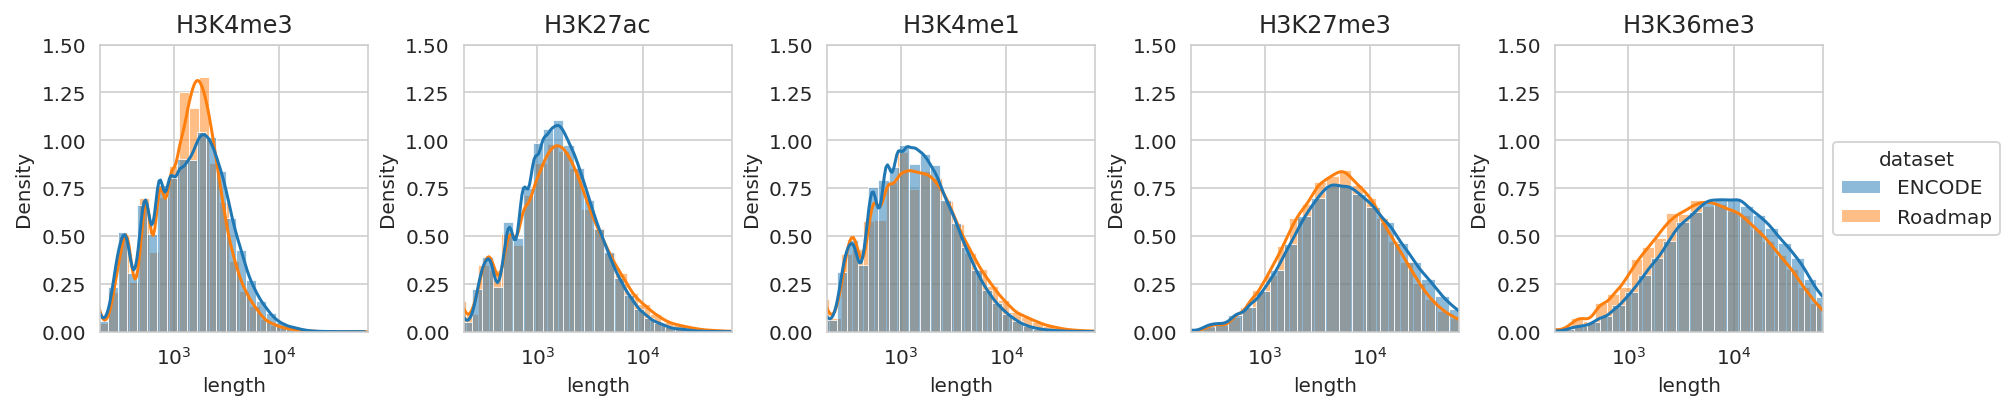

In [20]:
plt.figure(figsize=(14, 3))
axs = [plt.subplot(1, 5, i + 1) for i in range(5)]
for i, m in enumerate(['H3K4me3', 'H3K27ac', 'H3K4me1', 'H3K27me3', 'H3K36me3']):
    print(m)
    ax = axs[i]
    g_results = sns.histplot(data=df_lens[(df_lens['modification'] == m) & (df_lens['tool'] == 'SPAN')],
                             x='length', hue='dataset', ax=ax,
                             stat='density', common_bins=False, common_norm=False,
                             bins=30, kde=True, log_scale=True, alpha=0.5,
                             # palette=TOOLS_PALETTE,
                             )
    g_results.set(xscale='log')
    g_results.set_ylim(0, 1.5)
    g_results.set_xlim(200, 7e4)
    ax.title.set_text(m)
    if i < len(axs) - 1:
        ax.legend().set_visible(False)
    else:
        sns.move_legend(ax, loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.show()

# plt.savefig(f'{GSE26320_PATH_HG38}/pics/H3K27ac_wiggle_mix_lengths.pdf', bbox_inches='tight', dpi=300)

In [21]:
# df_lens['cell_rep'] = df_lens['cell'] + ' ' + df_lens['replicate']
# 
# for m in MODIFICATIONS:
#     print(m)
#     plt.figure(figsize=(24, 12))
#     t = list(df_lens[df_lens['modification'] == m].groupby(['dataset', 'cell_rep']))
#     plots = len(t)
#     ncols = int(math.ceil(math.sqrt(plots)))
#     nrows = int(math.ceil(plots / ncols))
#     axs = [plt.subplot(nrows, ncols, i + 1) for i in range(plots)]
# 
#     for i, ((ds, cellrep), dt) in enumerate(t):
#         ax = axs[i]
#         sns.histplot(data=dt,
#                      x='length', hue='tool', 
#                      stat='density', common_bins=False, common_norm=False,
#                      bins=30, kde=True, log_scale=True, alpha=0.5,
#                      palette=TOOLS_PALETTE,
#                      ax=ax)
#         
#         ax.set_title(f'{ds} {cellrep}')
#         ax.set(xscale='log')
#         ax.set_ylim(0, 2.5)
#         ax.set_xlim(200, 7e4)
#         if (i + 1) == plots:
#             sns.move_legend(ax, loc='center left', bbox_to_anchor=(1, 0.5))
#         else:
#             ax.legend().set_visible(False)
#         if i % ncols != 0:
#             ax.set_ylabel(None)
#         if i < ncols:
#             # ax.set_xticks([], minor=False)
#             # ax.set_xticklabels([])
#             ax.set_xlabel(None)
#     plt.tight_layout()
#     plt.show()

## Average length

In [22]:
df_lens_aggr = df_lens[
    ['dataset', 'modification', 'cell', 'replicate', 'tool', 'length', 'footprint']
].groupby(['dataset', 'modification', 'cell', 'replicate', 'tool']).agg('mean').reset_index().drop_duplicates()
df_lens_aggr['ds_c_r'] = df_lens_aggr['dataset'] + ' ' + df_lens_aggr['cell'] + ' ' + df_lens_aggr['replicate']
df_lens_aggr.sample(3)

dataset modification     cell replicate         tool    length  \
211   ENCODE      H3K4me1       H1      rep1  MACS2 broad  383.5430   
230   ENCODE      H3K4me1     HSMM      rep2        MACS2  366.9310   
498  Roadmap      H3K4me3  TCellBB      rep1        MACS2  654.1744   

      footprint                ds_c_r  
211  18531892.0        ENCODE H1 rep1  
230  14446943.0      ENCODE HSMM rep2  
498  26147373.0  Roadmap TCellBB rep1

H3K4me3
H3K27ac
H3K4me1
H3K27me3
H3K36me3


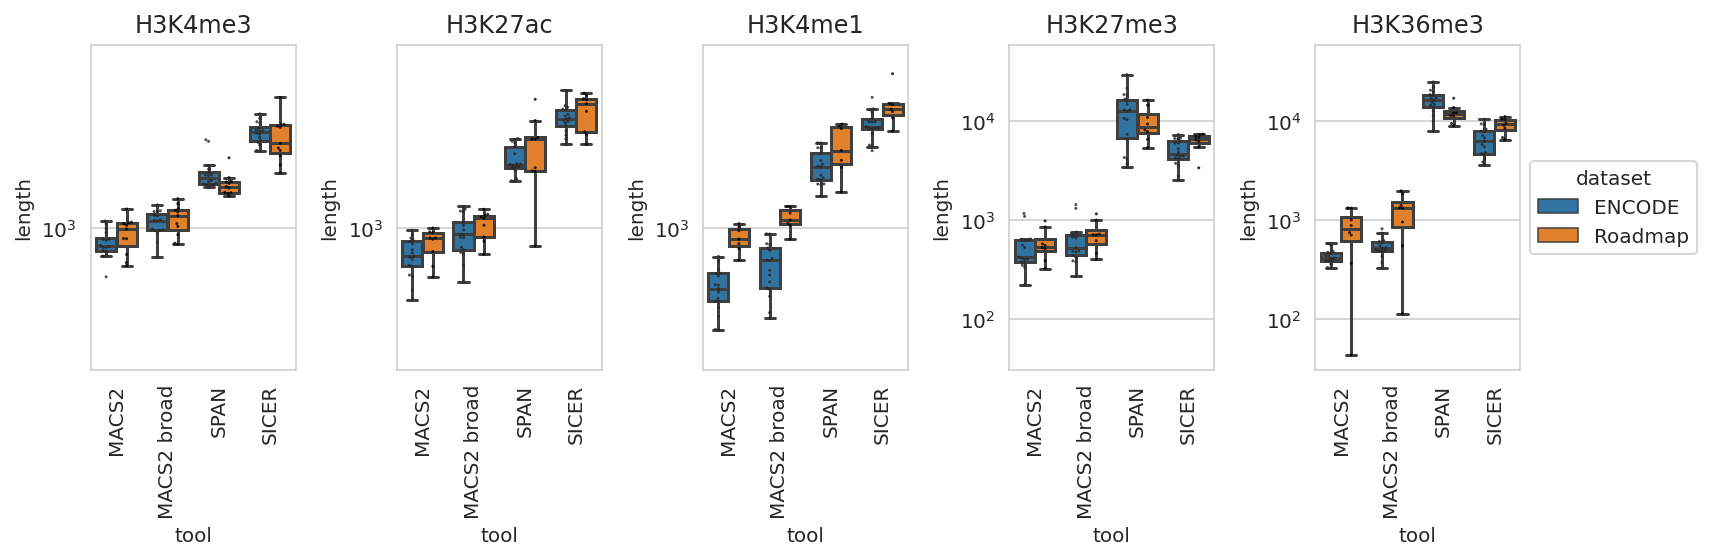

In [446]:
plt.figure(figsize=(12, 4))
axs = [plt.subplot(1, 5, i + 1) for i in range(5)]
for i, m in enumerate(['H3K4me3', 'H3K27ac', 'H3K4me1', 'H3K27me3', 'H3K36me3']):
    print(m)
    ax = axs[i]
    t = df_lens_aggr[df_lens_aggr['modification'] == m].copy()
    sns.boxplot(data=t, x='tool', y='length', hue='dataset',
                showfliers=False,
                order=['MACS2', 'MACS2 broad', 'SPAN', 'SICER'],
                hue_order=['ENCODE', 'Roadmap'],
                ax=ax)
    sns.swarmplot(data=t, x='tool', y='length', hue='dataset',
                  dodge=True, size=1.5, palette='dark:black', alpha=0.8, legend=False,
                  order=['MACS2', 'MACS2 broad', 'SPAN','SICER'],
                  hue_order=['ENCODE', 'Roadmap'],
                  ax=ax)
    ax.title.set_text(m)
    if i < len(axs) - 1:
        ax.legend().set_visible(False)
    else:
        sns.move_legend(ax, loc='center left', bbox_to_anchor=(1, 0.5))
    if m not in ['H3K27me3', 'H3K36me3']:
        ax.set_ylim(bottom=200, top=8e3)
    else:
        ax.set_ylim(bottom=30, top=6e4)
    ax.set(yscale='log')
    ax.xaxis.set_tick_params(rotation=90)

plt.tight_layout()
plt.show()

H3K4me3
H3K27ac
H3K4me1
H3K27me3
H3K36me3


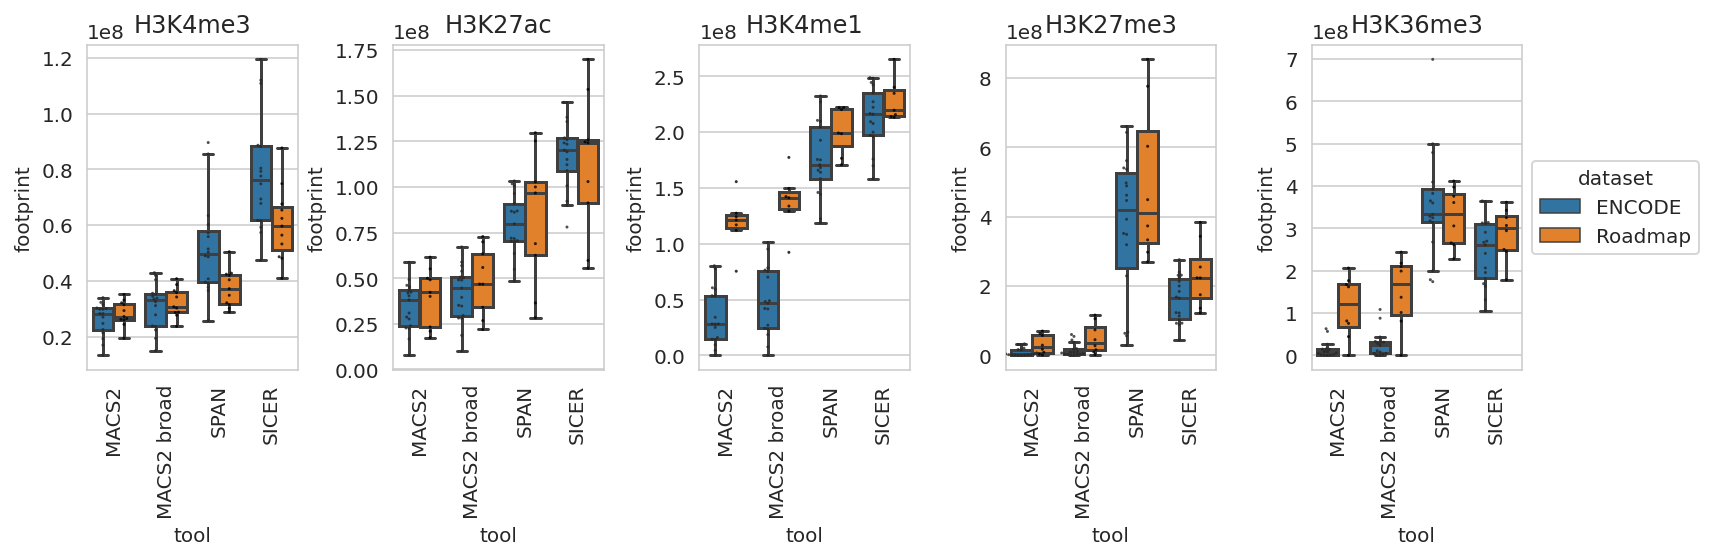

In [447]:
plt.figure(figsize=(12, 4))
axs = [plt.subplot(1, 5, i + 1) for i in range(5)]
for i, m in enumerate(['H3K4me3', 'H3K27ac', 'H3K4me1', 'H3K27me3', 'H3K36me3']):
    print(m)
    ax = axs[i]
    sns.boxplot(data=df_lens_aggr[df_lens_aggr['modification'] == m], x='tool', y='footprint', hue='dataset',
                showfliers=False,
                order=['MACS2', 'MACS2 broad', 'SPAN', 'SICER'],
                hue_order=['ENCODE', 'Roadmap'],
                ax=ax)
    sns.swarmplot(data=df_lens_aggr[df_lens_aggr['modification'] == m], x='tool', y='footprint', hue='dataset',
                  dodge=True, size=1.5, palette='dark:black', alpha=0.8, legend=False,
                  order=['MACS2', 'MACS2 broad', 'SPAN','SICER'],
                  hue_order=['ENCODE', 'Roadmap'],
                  ax=ax)
    ax.title.set_text(m)
    # ax.set(yscale='log')

    if i < len(axs) - 1:
        ax.legend().set_visible(False)
    else:
        sns.move_legend(ax, loc='center left', bbox_to_anchor=(1, 0.5))
    # if m not in ['H3K27me3', 'H3K36me3']:
    #     ax.set_ylim(1, 4e3)
    # else:
    #     ax.set_ylim(1, 1.7e4)
    ax.xaxis.set_tick_params(rotation=90)

plt.tight_layout()
plt.show()

H3K4me3
H3K27ac
H3K4me1
H3K36me3


/home/jetbrains/miniconda3/envs/pubtrends/lib/python3.10/site-packages/seaborn/categorical.py:3544: UserWarning: 6.7% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


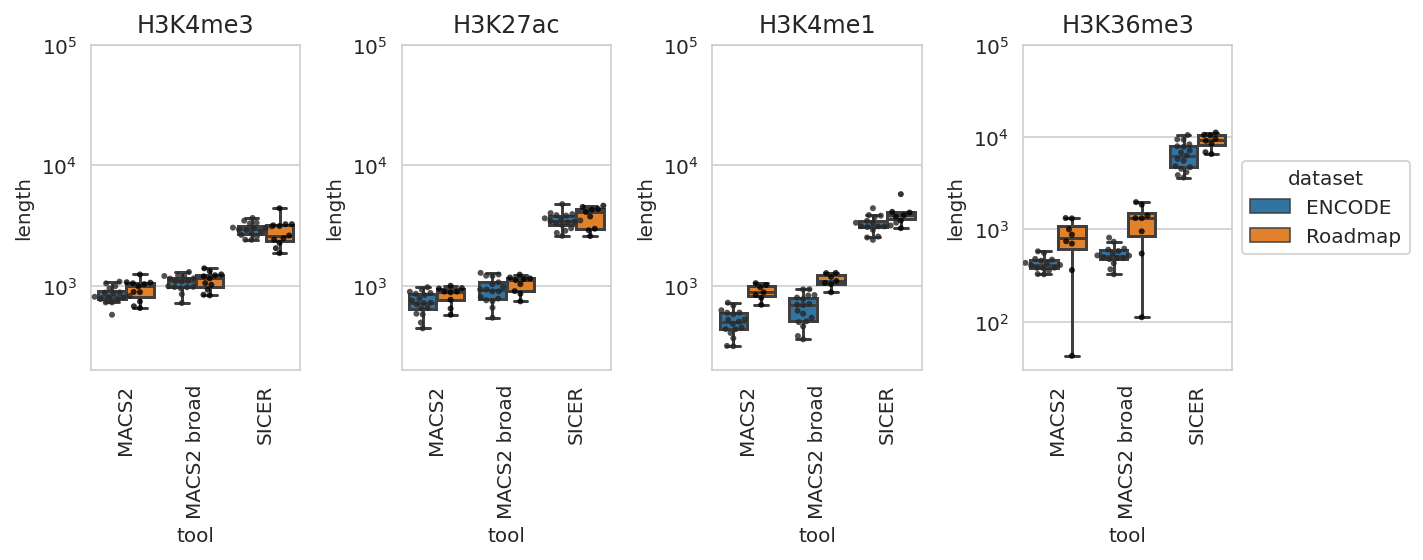

In [448]:
plt.figure(figsize=(10, 4))
axs = [plt.subplot(1, 4, i + 1) for i in range(4)]
for i, m in enumerate(['H3K4me3', 'H3K27ac', 'H3K4me1', 'H3K36me3']):
    print(m)
    ax = axs[i]
    sns.boxplot(data=df_lens_aggr[df_lens_aggr['modification'] == m], x='tool', y='length', hue='dataset',
                showfliers=False,
                order=['MACS2', 'MACS2 broad', 'SICER'],
                hue_order=['ENCODE', 'Roadmap'],
                ax=ax)
    sns.swarmplot(data=df_lens_aggr[df_lens_aggr['modification'] == m], x='tool', y='length', hue='dataset',
                  dodge=True, size=3,
                  palette='dark:black', alpha=0.8, legend=False,
                  order=['MACS2', 'MACS2 broad', 'SICER'],
                  hue_order=['ENCODE', 'Roadmap'],
                  ax=ax)
    ax.title.set_text(m)
    # ax.set(yscale='log')

    if i < len(axs) - 1:
        ax.legend().set_visible(False)
    else:
        sns.move_legend(ax, loc='center left', bbox_to_anchor=(1, 0.5))
    if m not in ['H3K27me3', 'H3K36me3']:
        ax.set_ylim(bottom=200, top=1e5)
    else:
        ax.set_ylim(bottom=30, top=1e5)
    ax.set(yscale='log')
    ax.xaxis.set_tick_params(rotation=90)

plt.tight_layout()
plt.show()

## BAMs

In [26]:
def load_bams(path, modifications, cells, replicates, control='Input'):
    df_bams = pd.DataFrame(columns=['bam_file', 'modification', 'cell', 'replicate', 'reads'], dtype=object)
    for f in tqdm(os.listdir(path)):
        if not f.endswith('.bam'):
            continue
        cell = next((c for c in cells if c in f), None)
        rep = next((r for r in replicates if r in f), None)
        mod = next((m for m in modifications if m in f), None)
        if mod is None and control is not None and control in f:
            mod = 'Control'
        if cell and mod and rep is not None:
            file = os.path.join(path, f)
            reads = ! samtools view -F 0x04 -c {file}
            reads = int(reads[0])
            df_bams.loc[len(df_bams)] = (file, mod, cell, rep, reads)
    return df_bams

In [27]:
df_encode_bams = load_bams(GSE26320_PATH + '/bams', MODIFICATIONS, GSE26320_CELLS, GSE26320_REPS, 'Input')
df_encode_bams['dataset'] = 'ENCODE'
df_immune_bams = load_bams(IMMUNE_PATH + '/bams', MODIFICATIONS, IMMUNE_CELLS, IMMUNE_REPS, 'Control')
df_immune_bams['dataset'] = 'Roadmap'

df_bams = pd.concat([df_encode_bams, df_immune_bams]).reset_index(drop=True)

  0%|          | 0/206 [00:00<?, ?it/s]

  0%|          | 0/113 [00:00<?, ?it/s]

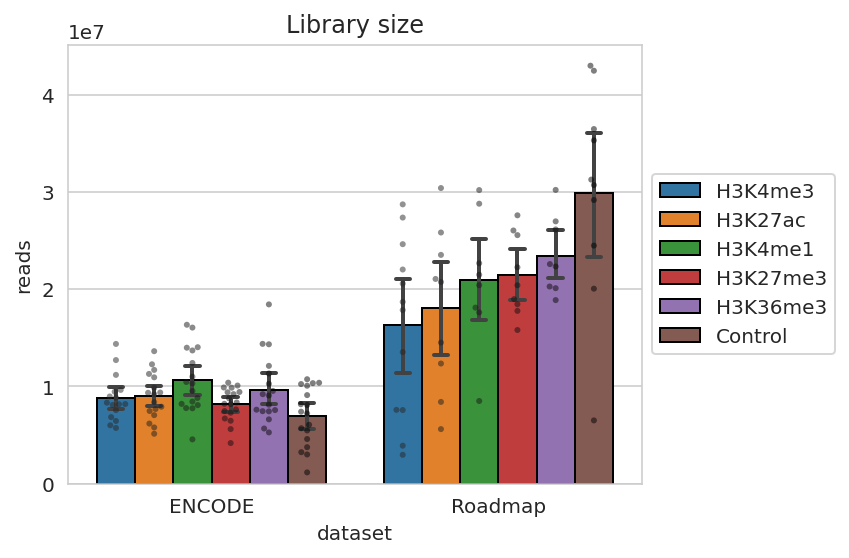

In [440]:
plt.figure(figsize=(6, 4))
ax = plt.axes()
sns.barplot(data=df_bams, hue='modification', x='dataset', y='reads',
            capsize=.05, errwidth=2, edgecolor="black",
            hue_order=MODIFICATIONS+['Control'],
            ax=ax)
sns.swarmplot(data=df_bams, hue='modification', x='dataset', y='reads',
              dodge=True, size=3, palette='dark:black', alpha=0.5, legend=False,
              hue_order=MODIFICATIONS+['Control'],
              ax=ax)
ax.set_title('Library size')
# Put a legend to the right of the current axis
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.tight_layout()
plt.show()

In [30]:
df_peaks_lens = pd.merge(df_peaks[['dataset', 'modification', 'cell', 'replicate', 'tool', 'peaks']],
                         df_bams[['dataset', 'modification', 'cell', 'replicate', 'reads']],
                         on=['dataset', 'modification', 'cell', 'replicate'], how='inner')
df_peaks_lens = pd.merge(df_peaks_lens,
                         df_lens_aggr[['dataset', 'modification', 'cell', 'replicate', 'tool', 'length', 'footprint']],
                         on=['dataset', 'modification', 'cell', 'replicate', 'tool'], how='inner')
df_peaks_lens.sample(3)

dataset modification   cell replicate         tool  peaks     reads  \
69    ENCODE     H3K36me3   HMEC      rep1         SPAN  15662   7610194   
463  Roadmap      H3K4me3  BCell            MACS2 broad  24118  24648172   
51    ENCODE      H3K27ac   NHLF      rep2         SPAN  36132   7681380   

         length    footprint  
69   25074.0383  392641860.0  
463   1198.9267   28781483.0  
51    1976.9134   70555198.0



peaks vs length


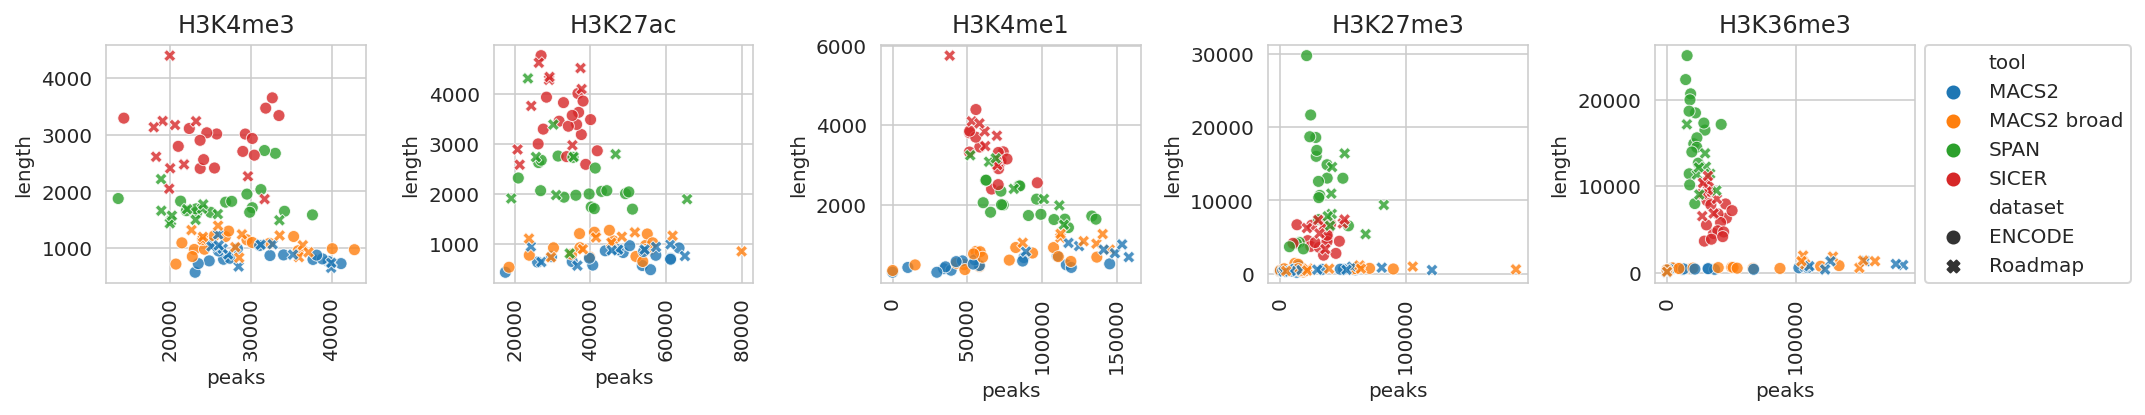



peaks vs reads


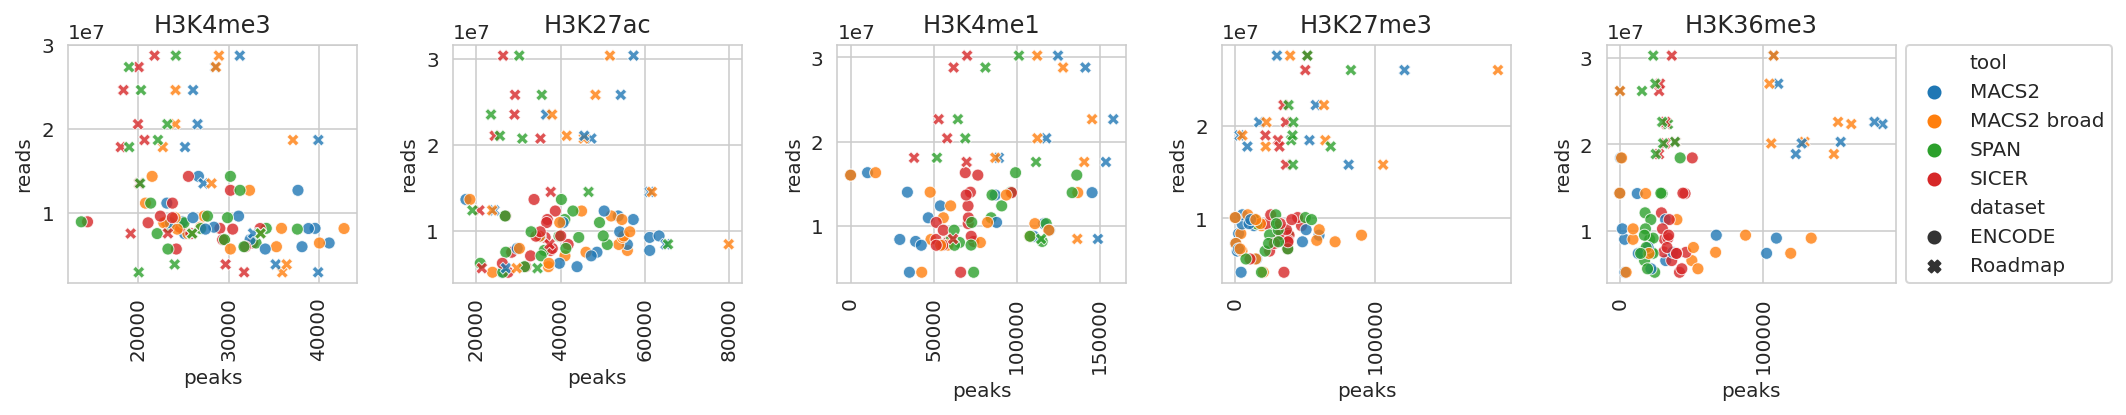

In [31]:
for x, y in [('peaks', 'length'), ('peaks', 'reads')]:
    print(f'\n\n{x} vs {y}')
    plt.figure(figsize=(15, 3))
    axs = [plt.subplot(1, 5, i + 1) for i in range(5)]
    for i, m in enumerate(['H3K4me3', 'H3K27ac', 'H3K4me1', 'H3K27me3', 'H3K36me3']):
        ax = axs[i]
        sns.scatterplot(
            df_peaks_lens[df_peaks_lens['modification'] == m], x=x, y=y, hue='tool', 
            alpha=0.8,
            style='dataset',
            palette=TOOLS_PALETTE,
            hue_order=TOOLS,
            ax = ax)
        ax.title.set_text(m)
        if i < len(axs) - 1:
            ax.legend().set_visible(False)
        else:
            sns.move_legend(ax, loc='center left', bbox_to_anchor=(1, 0.5))
        if x != 'reads':
            ax.xaxis.set_tick_params(rotation=90)
    plt.tight_layout()
    plt.show()



peaks vs length


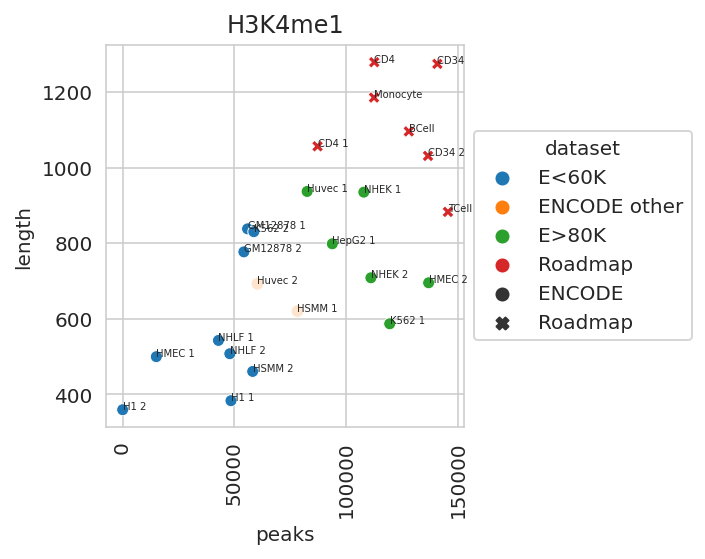



peaks vs reads


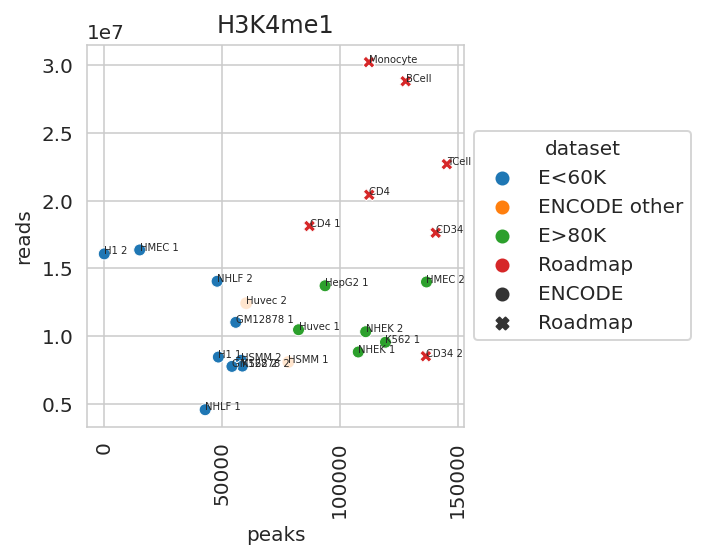

In [32]:
for x, y in [('peaks', 'length'), ('peaks', 'reads')]:
    print(f'\n\n{x} vs {y}')
    plt.figure(figsize=(5, 4))
    ax = plt.axes()
    tt = df_peaks_lens[(df_peaks_lens['modification'] == 'H3K4me1') & (df_peaks_lens['tool'] == 'MACS2 broad')].copy()
    tt['ds_c_r'] = tt['dataset'] + ' ' + tt['cell'] + ' ' + tt['replicate']
    sns.scatterplot(
        tt, x=x, y=y, 
        style='dataset',
        hue=['E<60K' if dscr in g1_ds_c_r else 'E>80K' if dscr in g2_ds_c_r else
        'ENCODE other' if 'ENCODE' in dscr else 'Roadmap' for dscr in tt['ds_c_r']],
        alpha=[1 if dscr in g1_ds_c_r or dscr in g2_ds_c_r or 'Roadmap' in dscr else 0.2 for dscr in tt['ds_c_r']],
        ax = ax)
    for xv, yv, cell, rep in zip(tt[x], tt[y], tt['cell'], tt['replicate']):
        rep = '1' if rep == 'rep1' else '2' if rep == 'rep2' else ''
        ax.text(xv, yv, f'{cell} {rep}', fontsize = 5)
    ax.title.set_text('H3K4me1')
    sns.move_legend(ax, loc='center left', bbox_to_anchor=(1, 0.5))
    if x != 'reads':
        ax.xaxis.set_tick_params(rotation=90)
    plt.tight_layout()
    plt.show()

# BigWigs

In [33]:
CHROM_SIZES = {
    c: s for _, (c, s) in pd.read_csv(os.path.join(GSE26320_PATH, 'hg38.chrom.sizes'),
                                      sep='\t', names=['chr', 'size']).iterrows() if '_' not in c
}


def load_bws(path, modification, cells, replicates, control='Input'):
    df_bws = pd.DataFrame(columns=['file', 'modification', 'cell', 'replicate'], dtype=object)
    for f in tqdm(os.listdir(path)):
        if '.bw' not in f:
            continue
        mod = next((m for m in modification if m in f), None)
        if mod is None and control is not None and control in f:
            mod = 'Control'
        cell = next((c for c in cells if c in f), None)
        rep = next((r for r in replicates if r in f), None)
        if mod and cell and rep is not None:
            df_bws.loc[len(df_bws)] = ((os.path.join(path, f)), mod, cell, rep)
    return df_bws

In [34]:
encode_bws = load_bws(GSE26320_PATH + '/bw', MODIFICATIONS, GSE26320_CELLS, GSE26320_REPS, 'Input')
encode_bws['dataset'] = 'ENCODE'
display(encode_bws.sample(3))

immune_bws = load_bws(IMMUNE_PATH + '/bw', MODIFICATIONS, IMMUNE_CELLS, IMMUNE_REPS, 'Control')
immune_bws['dataset'] = 'Roadmap'
display(immune_bws.sample(3))
all_bws = pd.concat([encode_bws, immune_bws]).reset_index(drop=False)

  0%|          | 0/103 [00:00<?, ?it/s]

file modification   cell  \
22  /home/jetbrains/data/2023_GSE26320/bw/GSM64644...      H3K4me1   K562   
27  /home/jetbrains/data/2023_GSE26320/bw/GSM64636...      H3K4me1  HepG2   
93  /home/jetbrains/data/2023_GSE26320/bw/GSM64639...     H3K36me3   HSMM   

   replicate dataset  
22      rep1  ENCODE  
27      rep1  ENCODE  
93      rep2  ENCODE

  0%|          | 0/56 [00:00<?, ?it/s]

file modification   cell  \
51  /home/jetbrains/data/2023_Immune/bw/NK_H3K27ac...      H3K27ac     NK   
5   /home/jetbrains/data/2023_Immune/bw/CD4_H3K27m...     H3K27me3    CD4   
10  /home/jetbrains/data/2023_Immune/bw/TCell_H3K4...      H3K4me1  TCell   

   replicate  dataset  
51            Roadmap  
5             Roadmap  
10            Roadmap

In [170]:
import pyBigWig

total_coverages = {}
ts = []
for _, (ds, m, c, r) in tqdm(list(all_bws[['dataset', 'modification', 'cell', 'replicate']].iterrows())):
    print(ds, m, c, r)
    t = all_bws[(all_bws['modification'] == m) &
                (all_bws['cell'] == c) &
                (all_bws['replicate'] == r) &
                (all_bws['dataset'] == ds)]
    if len(t) == 0:
        continue
    bw_path = t['file'].values[0]
    # print(bw_path)
    
    try:
        with pyBigWig.open(bw_path) as bw:
            total_coverage = sum(bw.stats(chr, exact=True, type='sum')[0] for chr in CHROM_SIZES.keys() if '_' not in chr)
            print('Total coverage', total_coverage)
            # Multiplier to align BAM coverage with BigWig estimation
            total_coverage *= 1.1e-2
            total_coverages[(ds, m, c, r)] = total_coverage
    except Exception:
        pass
        # print('ERROR')

total_coverages_df = pd.DataFrame([(ds, m, c, r, n) for (ds, m, c, r), n in total_coverages.items()],
                                  columns=['dataset', 'modification', 'cell', 'replicate', 'reads'])
total_coverages_df.sample(5)

  0%|          | 0/159 [00:00<?, ?it/s]

ENCODE Control HSMM rep1
Total coverage 894815013.0
ENCODE H3K4me1 GM12878 rep1
Total coverage 1068252750.0
ENCODE H3K4me3 NHLF rep2
Total coverage 751052700.0
ENCODE H3K27me3 HepG2 rep2
Total coverage 469869319.0
ENCODE H3K27ac K562 rep2
Total coverage 407297750.0
ENCODE H3K27ac NHLF rep2
Total coverage 605669500.0
ENCODE H3K27ac HepG2 rep1
Total coverage 592156369.0
ENCODE H3K27me3 NHLF rep2
Total coverage 654364600.0
ENCODE H3K4me1 NHLF rep1
Total coverage 369591300.0
ENCODE H3K27ac NHLF rep1
Total coverage 642197319.0
ENCODE H3K4me1 HMEC rep2
Total coverage 1111280200.0
ENCODE H3K27me3 HSMM rep2
Total coverage 684649207.0
ENCODE H3K27ac HepG2 rep2
Total coverage 417082519.0
ENCODE H3K36me3 HepG2 rep1
Total coverage 472956238.0
ENCODE H3K36me3 Huvec rep1
Total coverage 598335100.0
ENCODE H3K36me3 HMEC rep1
Total coverage 633591700.0
ENCODE H3K27ac NHEK rep2
Total coverage 734185750.0
ENCODE H3K36me3 HMEC rep2
Total coverage 763466200.0
ENCODE Control GM12878 rep1
Total coverage 5629

dataset modification   cell replicate        reads
13  ENCODE     H3K36me3  HepG2      rep1  5202518.618
4   ENCODE      H3K27ac   K562      rep2  4480275.250
22  ENCODE      H3K4me1   K562      rep1  8563729.218
99  ENCODE      H3K4me1   NHEK      rep2  9428946.109
24  ENCODE      Control   NHLF      rep2  7373894.616

In [36]:
# Prepare BAM files
WD = os.path.expanduser('~/data/2023_wiggle')

BLACKLIST_PATH = WD + '/hg38-blacklist.v2.bed'
blacklist_df = pd.read_csv(BLACKLIST_PATH, sep='\t', header=None)
blacklist_df.rename({0: 'chr', 1: 'start', 2: 'end'}, axis=1, inplace=True)
blacklist_df

chr     start       end                   3
0    chr10         0     45700     Low Mappability
1    chr10  38481300  38596500  High Signal Region
2    chr10  38782600  38967900  High Signal Region
3    chr10  39901300  41712900  High Signal Region
4    chr10  41838900  42107300  High Signal Region
..     ...       ...       ...                 ...
631   chrY   4343800   4345800  High Signal Region
632   chrY  10246200  11041200  High Signal Region
633   chrY  11072100  11335300  High Signal Region
634   chrY  11486600  11757800  High Signal Region
635   chrY  26637300  57227400  High Signal Region

[636 rows x 4 columns]

In [37]:
def collect_bw_stats(bw_path, control_bw_path, chrom_sizes, blacklist, region, top_regions, work_regions, resolution):
    print('Prepare chromosome indexes')
    chr_indx = {}
    indx = 0
    for chr, chr_size in chrom_sizes.items():
        if '_' in chr:
            continue
        bins = int(math.floor(chr_size / region))
        chr_indx[chr] = (indx, indx + bins)
        indx += bins
    chromosomes = list(chr_indx.keys())

    print('Compute coverage in regions')
    region_coverages = np.zeros(indx)
    with pyBigWig.open(bw_path) as bw:
        for chr, (istart, iend) in chr_indx.items():
            region_coverages[istart: iend] = \
                np.array([x or 0 for x in bw.stats(chr, 1, CHROM_SIZES[chr], nBins=iend - istart, exact=True, type='sum')])
    
    print('Processing blacklisted regions')
    blacklist_marked = 0
    for chr, start, end in zip(blacklist['chr'], blacklist['start'], blacklist['end']):
        if chr not in chr_indx:
            continue
        offset = chr_indx[chr][0]
        for x in range(int(math.floor(start / region)), int(math.ceil(end / region)) + 1):
            region_coverages[min(x - offset, len(region_coverages) - 1)] = 0
            blacklist_marked += 1
    print(f'Marked {blacklist_marked} / {len(region_coverages)} bins as blacklist')

    if top_regions > len(region_coverages):
        raise Exception(f'Too many top regions {top_regions} > {len(region_coverages)}')
    
    print('Split by chromosomes')
    chr_xs = [[] for _ in range(len(chr_indx))]  # Create new array for each chromosome index
    ichr = 0
    for x in np.sort(np.argpartition(region_coverages, -top_regions)[-top_regions:]):
        while chr_indx[chromosomes[ichr]][1] < x:
            ichr += 1
        chr_xs[ichr].append(x)

    print('Collect final regions')
    peaks = []
    for ichr, xs in enumerate(chr_xs):
        chr = chromosomes[ichr]
        offset = chr_indx[chr][0]
        for i, x in enumerate(xs):
            peaks.append((chr, (x - offset) * region, (x + 1 - offset) * region))
    df = pd.DataFrame(peaks, columns=['chromosome', 'start', 'end'])
    if len(df) > work_regions:
        print(f'Pick {work_regions} / {top_regions} uniform regions for computation speedup')
        step = int(math.ceil(len(df) / float(work_regions)))
        df = df.iloc[range(0, len(df), step)].copy()
    
    print('Collecting bigwig stats')
    sums, means, stds, control_sums, control_means, control_stds = [], [], [], [], [], []
    with pyBigWig.open(bw_path) as bw:
        with pyBigWig.open(control_bw_path) as cbw: 
            for _, (chr, start, end) in df.iterrows():
                stats = np.array(bw.stats(
                    chr, start, end, nBins=int(math.ceil((end - start) / resolution)), exact=True, type='sum'))
                sums.append(np.sum(stats))
                means.append(np.mean(stats))
                stds.append(np.std(stats))
                control_stats = np.array(cbw.stats(
                    chr, start, end, nBins=int(math.ceil((end - start) / resolution)), exact=True, type='sum'))
                control_sums.append(np.sum(control_stats))
                control_means.append(np.mean(control_stats))
                control_stds.append(np.std(control_stats))
    df['sum'] = sums
    df['mean'] = means
    df['std'] = stds
    df['control_sum'] = control_sums
    df['control_mean'] = control_means
    df['control_std'] = control_stds
    return df

In [593]:
REGION = 10_000
TOP_REGIONS = 50_000
WORK_REGIONS = 1000
RESOLUTION = 50

# Compute on top chromosomes for speed
chrom_sizes_part = {f'chr{i + 1}': CHROM_SIZES[f'chr{i + 1}'] for i in range(3)}

ts = []
for _, (bw_path, ds, m, c, r) in tqdm(list(all_bws[['file', 'dataset', 'modification', 'cell', 'replicate']].iterrows())):
    # if not (ds == 'Roadmap' and c in ['TCell', 'BCell', 'Monocyte']):
    #     continue
    if m == 'Control':
        continue
    cr = r
    ct = all_bws[(all_bws['modification'] == 'Control') &
                 (all_bws['cell'] == c) &
                 (all_bws['replicate'] == cr) &
                 (all_bws['dataset'] == ds)]
    # Control can be different for Roadmap
    if len(ct) == 0:
        cr = ''
        ct = all_bws[(all_bws['modification'] == 'Control') &
                     (all_bws['cell'] == c) &
                     (all_bws['replicate'] == cr) &  
                     (all_bws['dataset'] == ds)]
    if len(ct) == 0:
        continue
    print(ds, m, c, r, bw_path)
    cbw_path = ct['file'].values[0]
    print(bw_path, cbw_path)
    df = collect_bw_stats(bw_path, cbw_path, chrom_sizes_part, blacklist_df, REGION, TOP_REGIONS, WORK_REGIONS, RESOLUTION)
    df['dataset'] = ds
    df['modification'] = m
    df['cell'] = c
    df['replicate'] = r
    df['control_replicate'] = cr
    df['rpkm'] = df['sum'] / ((REGION / 1e3) * ((total_coverages[(ds, m, c, r)]) / 1e6))
    df['control_reads'] = total_coverages[(ds, 'Control', c, cr)]
    df['control_rpkm'] = df['control_sum'] / ((REGION / 1e3) * ((total_coverages[(ds, 'Control', c, cr)]) / 1e6))
    df['signal_to_control'] = [d(s, c) for s, c in zip(df['rpkm'], df['control_rpkm'])] 
    ts.append(df)
df_bw_stats = pd.concat(ts).reset_index(drop=True)
df_bw_stats.sample(5)

  0%|          | 0/159 [00:00<?, ?it/s]

ENCODE H3K4me1 GM12878 rep1 /home/jetbrains/data/2023_GSE26320/bw/GSM646322_GM12878_H3K4me1_rep1.bw
/home/jetbrains/data/2023_GSE26320/bw/GSM646322_GM12878_H3K4me1_rep1.bw /home/jetbrains/data/2023_GSE26320/bw/GSM646332_GM12878_Input_rep1.bw
Prepare chromosome indexes
Compute coverage in regions
Processing blacklisted regions
Marked 3864 / 68943 bins as blacklist
Split by chromosomes
Collect final regions
Pick 1000 / 50000 uniform regions for computation speedup
ENCODE H3K4me3 NHLF rep2 /home/jetbrains/data/2023_GSE26320/bw/GSM646487_NHLF_H3K4me3_rep2.bw
/home/jetbrains/data/2023_GSE26320/bw/GSM646487_NHLF_H3K4me3_rep2.bw /home/jetbrains/data/2023_GSE26320/bw/GSM646493_NHLF_Input_rep2.bw
Prepare chromosome indexes
Compute coverage in regions
Processing blacklisted regions
Marked 3864 / 68943 bins as blacklist
Split by chromosomes
Collect final regions
Pick 1000 / 50000 uniform regions for computation speedup
ENCODE H3K27me3 HepG2 rep2 /home/jetbrains/data/2023_GSE26320/bw/GSM646358_Hep

chromosome      start        end      sum    mean         std  \
9728        chr3    9310000    9320000   7150.0   35.75   63.122401   
64136       chr1   79270000   79280000   1100.0    5.50   15.644488   
34978       chr3  184260000  184270000  21750.0  108.75  133.363929   
33003       chr1    2430000    2440000    800.0    4.00   13.564660   
4397        chr2   27810000   27820000   2300.0   11.50   33.432768   

       control_sum  control_mean  control_std dataset modification   cell  \
9728        2800.0         14.00    29.223278  ENCODE      H3K4me1   HMEC   
64136       3000.0         15.00    26.457513  ENCODE     H3K27me3     H1   
34978       2900.0         14.50    29.828677  ENCODE     H3K27me3  Huvec   
33003       2050.0         10.25    21.964460  ENCODE      H3K4me3   HSMM   
4397        2850.0         14.25    28.007811  ENCODE      H3K27ac   NHLF   

      replicate control_replicate        rpkm  control_reads  control_rpkm  \
9728       rep2              rep2   58.491099   9.518548e+06     29.416253   
64136      rep1              rep1   23.577223   9.008538e+06     33.301742   
34978      rep1              rep1  240.667931   1.066723e+07     27.186073   
33003      rep1              rep1   12.031331   9.842965e+06     20.827057   
4397       rep2              rep2   34.522278   7.373895e+06     38.649861   

       signal_to_control  
9728            1.988394  
64136           0.707988  
34978           8.852618  
33003           0.577678  
4397            0.893206

In [594]:
df_bw_stats['std_mean'] = [d(std, mean) for std, mean in zip(df_bw_stats['std'], df_bw_stats['mean'])]
df_bw_stats['control_std_mean'] =\
    [d(std, mean) for std, mean in zip(df_bw_stats['control_std'], df_bw_stats['control_mean'])]
df_bw_stats['signal_to_control_std_mean'] =\
    [d(std, cstd) for std, cstd in zip(df_bw_stats['std_mean'], df_bw_stats['control_std_mean'])]

## Aggregation / percentiles

In [595]:
print('Assign groups by coverage percentiles individually in each track')
ts = []
for (ds, m, c, r), group in df_bw_stats.groupby(['dataset', 'modification', 'cell', 'replicate']):
    group = group.sort_values(by=['mean'], ascending=False)
    group['percentile'] = [10 * int(10.0 * i / len(group)) for i in range(len(group))]
    total_coverage = df_bams[(df_bams['dataset'] == ds) & 
                             (df_bams['modification'] == m) & 
                             (df_bams['cell'] == c) & 
                             (df_bams['replicate'] == r)]['reads'].values[0]
    ts.append(group)
df_bw_stats_perc = pd.concat(ts).reset_index(drop=True)
del ts
df_bw_stats_perc.sample(5)

Assign groups by coverage percentiles individually in each track


chromosome      start        end     sum   mean        std  \
21662        chr3   65460000   65470000  1200.0   6.00  16.248077   
121210       chr3  184940000  184950000  4450.0  22.25  34.167785   
120551       chr1   64770000   64780000  4650.0  23.25  34.233573   
53115        chr1  205220000  205230000  6500.0  32.50  60.981555   
10743        chr2  156270000  156280000   650.0   3.25  12.326293   

        control_sum  control_mean  control_std  dataset  ... replicate  \
21662         600.0          3.00    12.884099   ENCODE  ...      rep1   
121210      15350.0         76.75    63.811735  Roadmap  ...      rep2   
120551      13900.0         69.50    67.042897  Roadmap  ...             
53115        2000.0         10.00    22.912878   ENCODE  ...      rep2   
10743         450.0          2.25    10.365206   ENCODE  ...      rep2   

       control_replicate       rpkm control_reads  control_rpkm  \
21662               rep1  19.647814  3.322365e+06     18.059427   
121210                    35.201848  4.015509e+07     38.226784   
120551                    26.629964  4.015509e+07     34.615785   
53115               rep2  79.743755  5.933448e+06     33.707214   
10743               rep2   9.483348  3.893332e+06     11.558223   

        signal_to_control  std_mean  control_std_mean  \
21662            1.087953  2.708013          4.294700   
121210           0.920869  1.535631          0.831423   
120551           0.769301  1.472412          0.964646   
53115            2.365777  1.876356          2.291288   
10743            0.820485  3.792706          4.606758   

        signal_to_control_std_mean  percentile  
21662                     0.630548          60  
121210                    1.846990          20  
120551                    1.526375          50  
53115                     0.818909          10  
10743                     0.823292          70  

[5 rows x 22 columns]

In [596]:
print('Compute Signal-to-noise ratio')
t = df_bw_stats_perc[
    ['dataset', 'modification', 'cell', 'replicate', 'percentile', 'mean']
].groupby(['dataset', 'modification', 'cell', 'replicate', 'percentile']).agg('mean').reset_index()
ts = []
for (ds, m, c, r), dt in t.groupby(['dataset', 'modification', 'cell', 'replicate']):
    snr = dt[dt['percentile'] <= 10]['mean'].mean() / dt[dt['percentile'] >= 80]['mean'].mean()
    ts.append((ds, m, c, r, snr))
df_snr = pd.DataFrame(ts, columns=['dataset', 'modification', 'cell', 'replicate', 'signal_to_noise'])
df_snr['ds_c_r'] = df_snr['dataset'] + ' ' + df_snr['cell'] + ' ' + df_snr['replicate']
df_snr.sample(3)

Compute Signal-to-noise ratio


dataset modification  cell replicate  signal_to_noise            ds_c_r
74    ENCODE      H3K4me3  HMEC      rep2         5.019739  ENCODE HMEC rep2
55    ENCODE      H3K4me1    H1      rep2         4.946604    ENCODE H1 rep2
100  Roadmap     H3K27me3    NK                   4.337466       Roadmap NK

Signal-to-noise


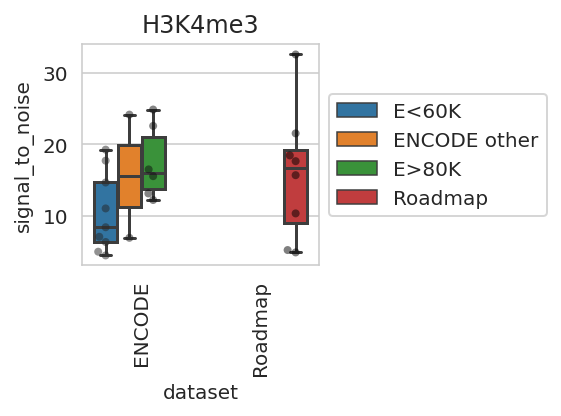

In [597]:
print('Signal-to-noise')
plt.figure(figsize=(4, 3))
ax = plt.axes()
t = df_snr[(df_snr['modification'] == 'H3K4me1')]
sns.boxplot(data=t, x='dataset', y='signal_to_noise',
            hue=['E<60K' if dscr in g1_ds_c_r else 'E>80K' if dscr in g2_ds_c_r else 
            'ENCODE other' if 'ENCODE' in dscr else 'Roadmap' for dscr in t['ds_c_r']],
            hue_order=['E<60K', 'ENCODE other', 'E>80K', 'Roadmap'],
            showfliers=False,
            ax=ax)
sns.swarmplot(data=t, x='dataset', y='signal_to_noise',
              hue=['E<60K' if dscr in g1_ds_c_r else 'E>80K' if dscr in g2_ds_c_r else
              'ENCODE other' if 'ENCODE' in dscr else 'Roadmap' for dscr in t['ds_c_r']],
              hue_order=['E<60K', 'ENCODE other', 'E>80K', 'Roadmap'],
              dodge=True, size=4, alpha=0.5, palette='dark:black', legend=False,
              ax=ax)

sns.move_legend(ax, loc='center left', bbox_to_anchor=(1, 0.5))
ax.title.set_text(m)
ax.xaxis.set_tick_params(rotation=90)

plt.tight_layout()
plt.show()

In [598]:
print('Pick only top covered regions, where most of the peaks are located')
df_bw_stats_signal_aggr = df_bw_stats_perc[df_bw_stats_perc['percentile'] <= 10][
    ['dataset', 'modification', 'cell', 'replicate', 'sum', 'mean', 'std', 'rpkm', 'std_mean', 'signal_to_control', 
     'control_reads', 'control_sum', 'control_mean', 'control_std', 'control_rpkm', 'control_std_mean', 'signal_to_control_std_mean']
].groupby(['dataset', 'modification', 'cell', 'replicate']).agg('mean').reset_index()
df_bw_stats_signal_aggr['ds_c_r'] = df_bw_stats_signal_aggr['dataset'] + ' ' + \
                                    df_bw_stats_signal_aggr['cell'] + ' ' + df_bw_stats_signal_aggr['replicate']
df_bw_stats_signal_aggr.sample(3)

Pick only top covered regions, where most of the peaks are located


dataset modification   cell replicate      sum      mean        std  \
87   Roadmap      H3K27ac   CD34      rep2   3675.5   18.3775  36.944582   
8     ENCODE      H3K27ac  HepG2      rep2   9071.5   45.3575  89.137290   
106  Roadmap     H3K36me3    CD4            24791.0  123.9550  96.054566   

           rpkm  std_mean  signal_to_control  control_reads  control_sum  \
87    70.176374  2.066831           2.181225   4.015509e+07     13735.00   
8    197.726297  2.312695           7.401643   1.071726e+06       414.50   
106   87.827118  0.821783           2.407425   3.967016e+07     14936.25   

     control_mean  control_std  control_rpkm  control_std_mean  \
87       68.67500    62.775131     34.204878          0.942879   
8         2.07250     9.533096     38.675937          5.805301   
106      74.68125    66.285163     37.651095          0.909523   

     signal_to_control_std_mean             ds_c_r  
87                     2.230812  Roadmap CD34 rep2  
8                      0.427545  ENCODE HepG2 rep2  
106                    0.913807       Roadmap CD4

In [ ]:
df_bw_stats_signal_snr_aggr = pd.merge(df_snr.drop('ds_c_r', axis=1),
                                       df_bw_stats_signal_aggr,
                                       on=['dataset', 'modification', 'cell', 'replicate'], how='inner')

ENCODE


/tmp/ipykernel_2375599/1958819393.py:17: FutureWarning: Passing `palette` without assigning `hue` is deprecated.
  sns.swarmplot(data=tt, x='modification', y=y,
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
/tmp/ipykernel_2375599/1958819393.py:17: FutureWarning: Passing `palette` without assigning `hue` is deprecated.
  sns.swarmplot(data=tt, x='modification', y=y,
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
/tmp/ipykernel_2375599/1958819393.py:17: FutureWarning: Passing `palette` without assigning `hue` is deprecated.
  sns.swarmplot(data=tt, x='modification', y=y,
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
/tmp/ipykernel_2375599/1958819393.py:17: Futur

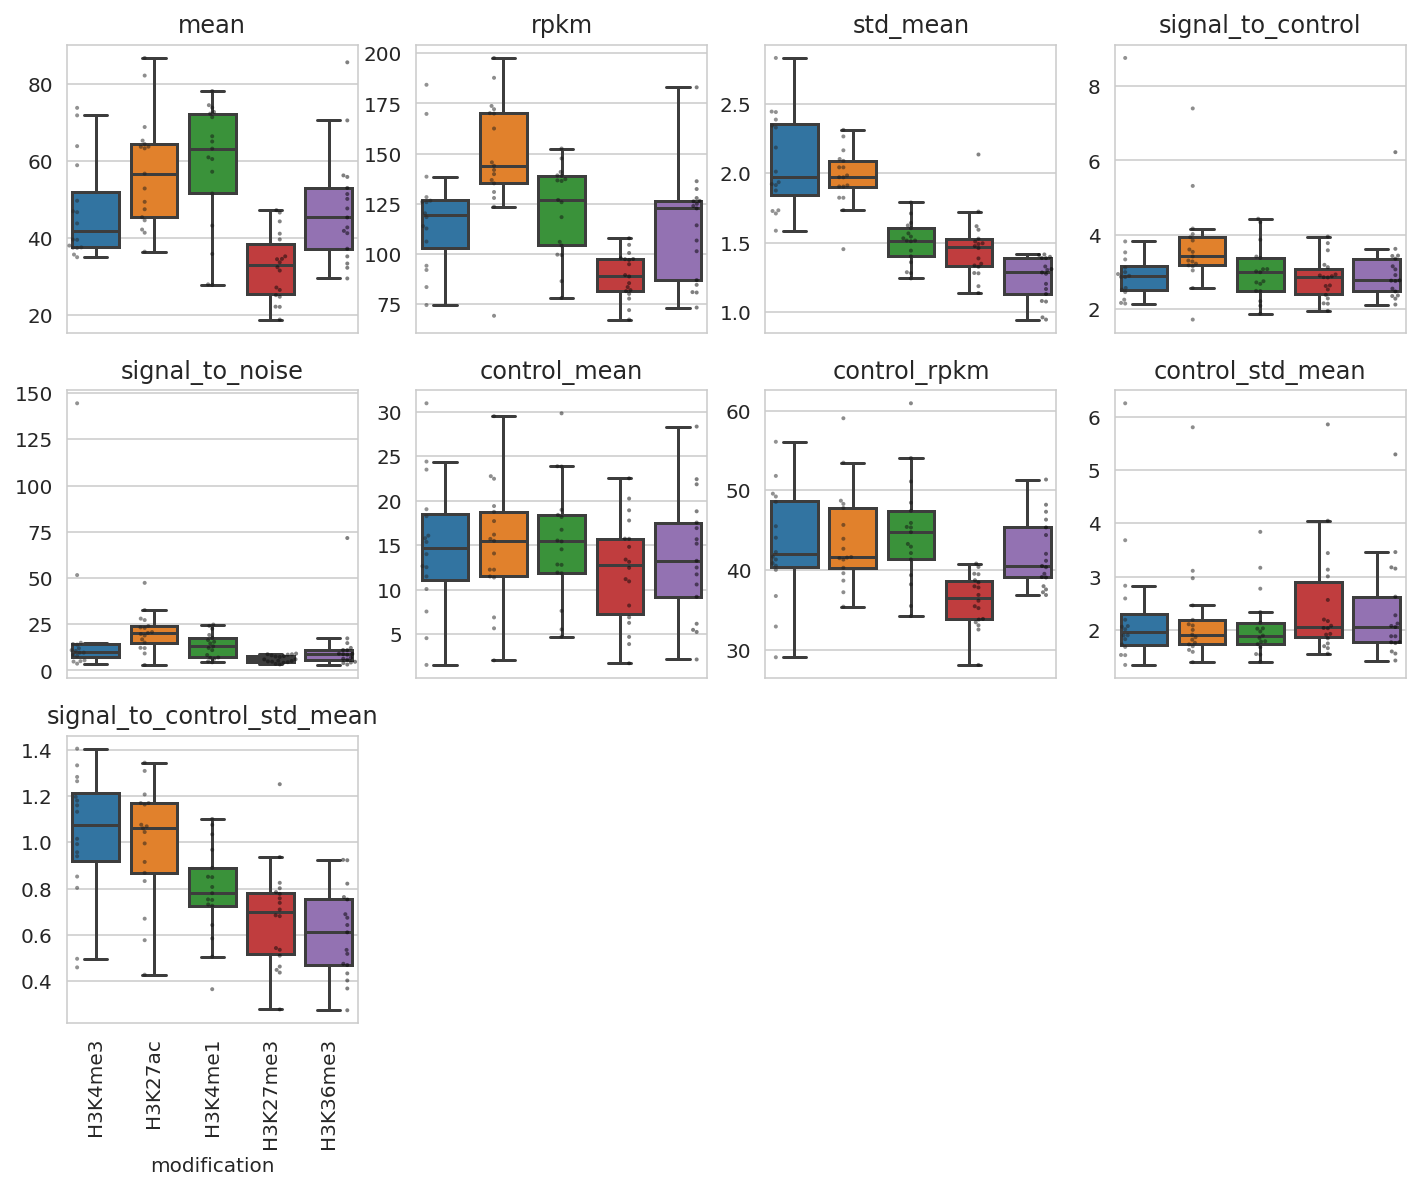

<Figure size 288x216 with 0 Axes>

<Figure size 288x216 with 0 Axes>

<Figure size 288x216 with 0 Axes>

<Figure size 288x216 with 0 Axes>

<Figure size 288x216 with 0 Axes>

<Figure size 288x216 with 0 Axes>

<Figure size 288x216 with 0 Axes>

<Figure size 288x216 with 0 Axes>

<Figure size 288x216 with 0 Axes>

Roadmap


/tmp/ipykernel_2375599/1958819393.py:17: FutureWarning: Passing `palette` without assigning `hue` is deprecated.
  sns.swarmplot(data=tt, x='modification', y=y,
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
/tmp/ipykernel_2375599/1958819393.py:17: FutureWarning: Passing `palette` without assigning `hue` is deprecated.
  sns.swarmplot(data=tt, x='modification', y=y,
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
/tmp/ipykernel_2375599/1958819393.py:17: FutureWarning: Passing `palette` without assigning `hue` is deprecated.
  sns.swarmplot(data=tt, x='modification', y=y,
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
/tmp/ipykernel_2375599/1958819393.py:17: Futur

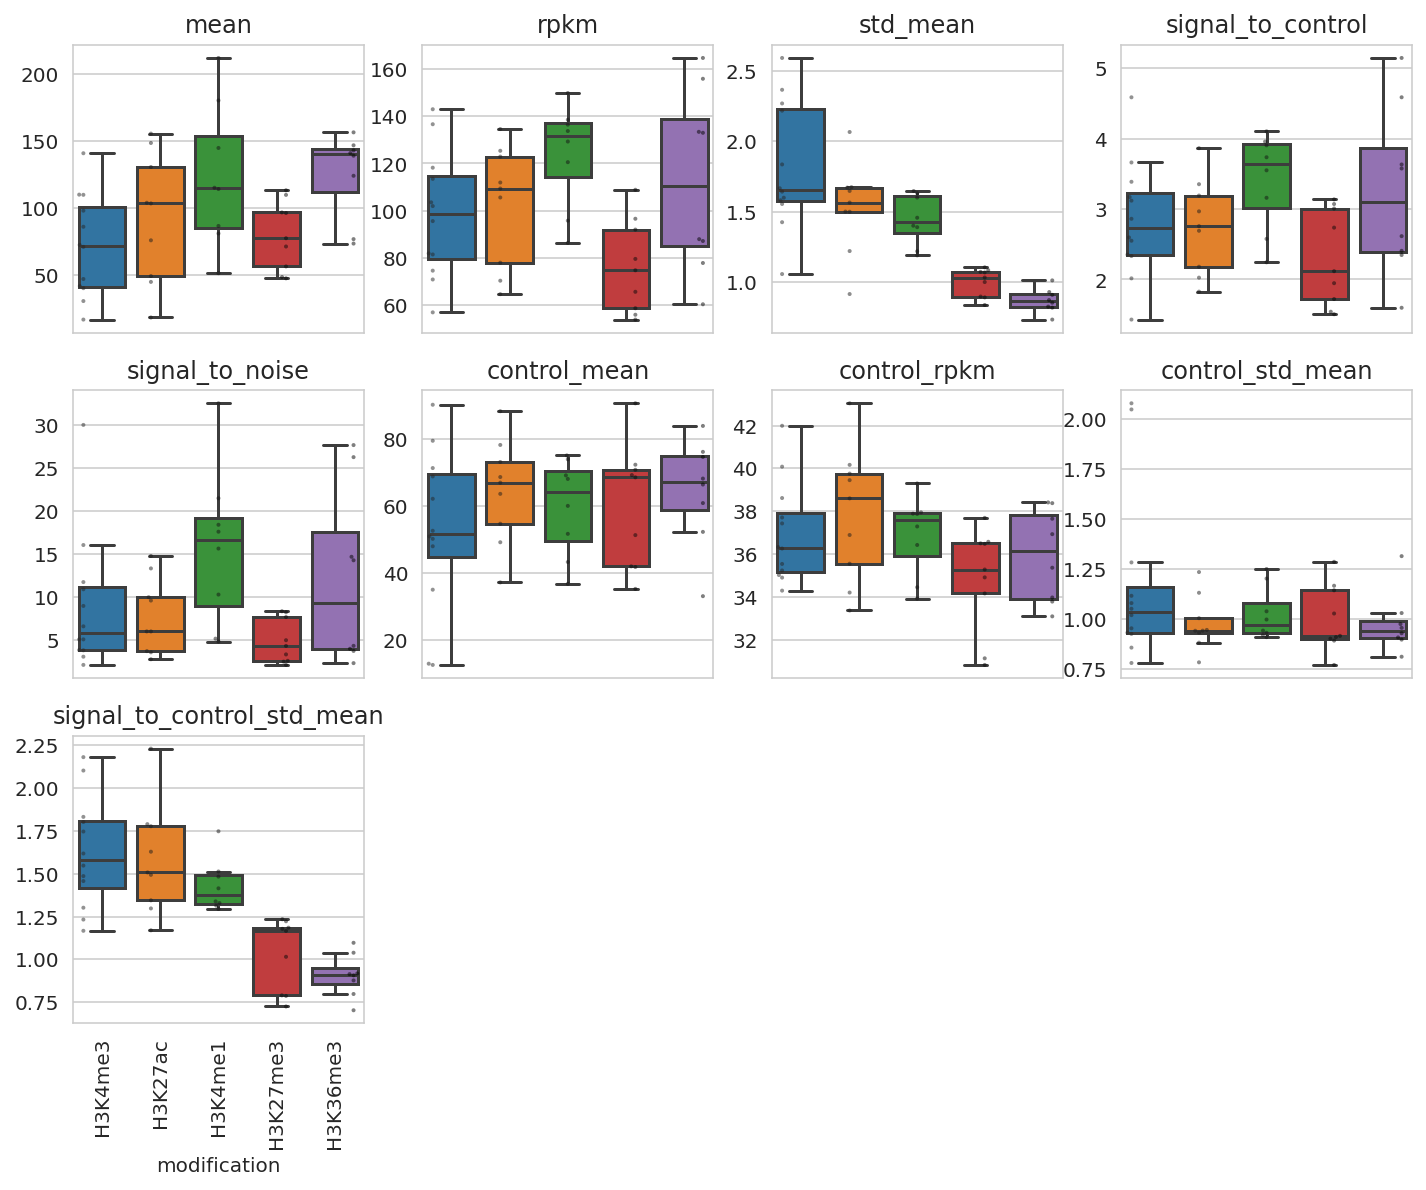

<Figure size 288x216 with 0 Axes>

<Figure size 288x216 with 0 Axes>

<Figure size 288x216 with 0 Axes>

<Figure size 288x216 with 0 Axes>

<Figure size 288x216 with 0 Axes>

<Figure size 288x216 with 0 Axes>

<Figure size 288x216 with 0 Axes>

<Figure size 288x216 with 0 Axes>

<Figure size 288x216 with 0 Axes>

In [620]:
features = ['mean', 'rpkm', 'std_mean', 'signal_to_control', 'signal_to_noise',
            'control_mean', 'control_rpkm', 'control_std_mean', 'signal_to_control_std_mean']
for ds in ['ENCODE', 'Roadmap']:
    print(ds)
    ncols = int(math.ceil(math.sqrt(len(features) + 3)))
    nrows = int(math.ceil(len(features) / ncols))
    plt.figure(figsize=(3 * ncols, 3 * nrows))
    axs = [plt.subplot(nrows, ncols, i + 1) for i in range(len(features))]
    for i, y in enumerate(features):
        ax = axs[i]
        plt.figure(figsize=(4, 3))
        tt = df_bw_stats_signal_snr_aggr[(df_bw_stats_signal_snr_aggr['dataset'] == ds)]
        sns.boxplot(data=tt, x='modification', y=y,
                    order=MODIFICATIONS,
                    showfliers=False,
                    ax=ax)
        sns.swarmplot(data=tt, x='modification', y=y,
                      dodge=True, size=2, alpha=0.5, palette='dark:black', legend=False,
                      order=MODIFICATIONS,
                      ax=ax)
        ax.title.set_text(y)
        ax.set_ylabel(None)
        if i / ncols < nrows - 1:
            ax.set_xlabel(None)
            ax.set_xticks([], minor=False)
            ax.set_xticklabels([])
        ax.xaxis.set_tick_params(rotation=90)
        if i % nrows == -1:
            sns.move_legend(ax, loc='center left', bbox_to_anchor=(1, 0.5))
        else:
            ax.legend().set_visible(False)

    plt.tight_layout()
    plt.show()

# Analyze vs peaks number / length

In [599]:
df_aggr = pd.merge(df_bw_stats_signal_snr_aggr,
                   df_peaks_lens,
                   on=['dataset', 'modification', 'cell', 'replicate'], how='inner')
df_aggr['reads_min'] = [min(s, c) for s, c in zip(df_aggr['reads'], df_aggr['control_reads'])]
df_aggr.sample(3)

dataset modification  cell replicate  signal_to_noise       sum      mean  \
182  ENCODE     H3K36me3  K562      rep1         8.960724   9525.25  47.62625   
230  ENCODE      H3K4me1  HSMM      rep2        19.213986  10303.50  51.51750   
121  ENCODE     H3K27me3  K562      rep2         7.523706   6903.00  34.51500   

           std        rpkm  std_mean  ...  control_rpkm  control_std_mean  \
182  55.658360  114.159856  1.284710  ...     51.352689          1.420822   
230  72.609145  137.189918  1.543261  ...     51.102410          2.133109   
121  49.181559   97.267999  1.495113  ...     40.389699          2.027700   

     signal_to_control_std_mean            ds_c_r   tool  peaks    reads  \
182                    0.922102  ENCODE K562 rep1  MACS2  67417  9543326   
230                    0.731207  ENCODE HSMM rep2  MACS2  39204  8208396   
121                    0.757635  ENCODE K562 rep2   SPAN  28634  9211786   

         length    footprint    reads_min  
182    385.5405   26091123.0  9543326.000  
230    366.9310   14446943.0  4671991.016  
121  18584.2332  536410449.0  6505990.535  

[3 rows x 25 columns]

In [600]:
df_aggr[['dataset', 'modification', 'cell', 'replicate']].drop_duplicates().groupby(['dataset', 'modification']).size()

dataset  modification
ENCODE   H3K27ac         17
         H3K27me3        18
         H3K36me3        17
         H3K4me1         17
         H3K4me3         16
Roadmap  H3K27ac          9
         H3K27me3         8
         H3K36me3         8
         H3K4me1          7
         H3K4me3         11
dtype: int64

In [601]:
TOOL = 'MACS2 broad'

Full


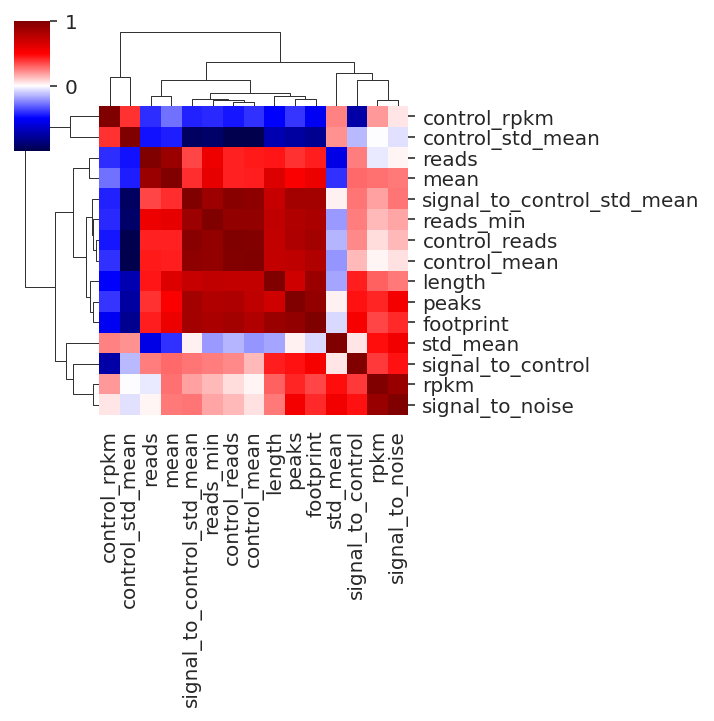

In [602]:
tt = df_aggr[(df_aggr['modification'] == 'H3K4me1') & (df_aggr['tool'] == TOOL)]
features = ['peaks', 'length', 'footprint',
            'reads', 'mean', 'rpkm', 'std_mean',
            'control_reads', 'control_mean', 'control_rpkm', 'control_std_mean',
            'reads_min',
            'signal_to_noise', 'signal_to_control', 'signal_to_control_std_mean']
print('Full')
sns.clustermap(tt[features].corr(method='spearman'),
               col_cluster=True, row_cluster=True,
               figsize=(5, 5),
               cmap=plt.cm.seismic)
plt.show()

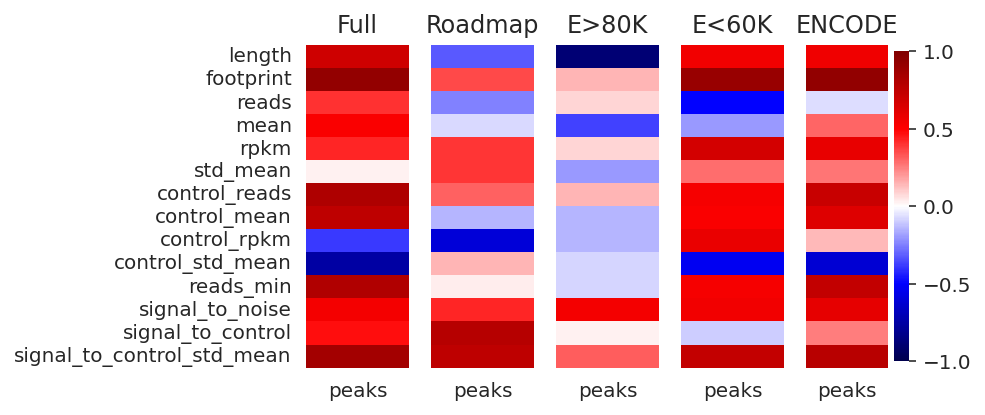

In [603]:
plt.figure(figsize=(7, 3))
axs = [plt.subplot(1, 5, i+1) for i in range(5)]
ax = axs[0]
sns.heatmap(tt[features].corr(method='spearman')[['peaks']].iloc[1:,], cmap=plt.cm.seismic, 
            vmin=-1, vmax=1, cbar=False, ax=ax)
ax.set_title('Full')

ax = axs[1]
sns.heatmap(tt[tt['dataset'] == 'Roadmap'][features].corr(method='spearman')[['peaks']].iloc[1:,], cmap=plt.cm.seismic, 
            vmin=-1, vmax=1, cbar=False, ax=ax)
ax.set_title('Roadmap')
ax.set_ylabel(None)
ax.set_yticks([], minor=False)
ax.set_yticklabels([])

ax = axs[2]
sns.heatmap(tt[tt['ds_c_r'].isin(g2_ds_c_r)][features].corr(method='spearman')[['peaks']].iloc[1:,], cmap=plt.cm.seismic, 
            vmin=-1, vmax=1, cbar=False, ax=ax)
ax.set_title('E>80K')
ax.set_ylabel(None)
ax.set_yticks([], minor=False)
ax.set_yticklabels([])

ax = axs[3]
sns.heatmap(tt[tt['ds_c_r'].isin(g1_ds_c_r)][features].corr(method='spearman')[['peaks']].iloc[1:,], cmap=plt.cm.seismic, 
            vmin=-1, vmax=1, cbar=False, ax=ax)
ax.set_title('E<60K')
ax.set_ylabel(None)
ax.set_yticks([], minor=False)
ax.set_yticklabels([])

ax = axs[4]
sns.heatmap(tt[tt['dataset'] == 'ENCODE'][features].corr(method='spearman')[['peaks']].iloc[1:,], cmap=plt.cm.seismic,
            vmin=-1, vmax=1, ax=ax)
ax.set_title('ENCODE')
ax.set_ylabel(None)
ax.set_yticks([], minor=False)
ax.set_yticklabels([])


plt.tight_layout()
plt.show()

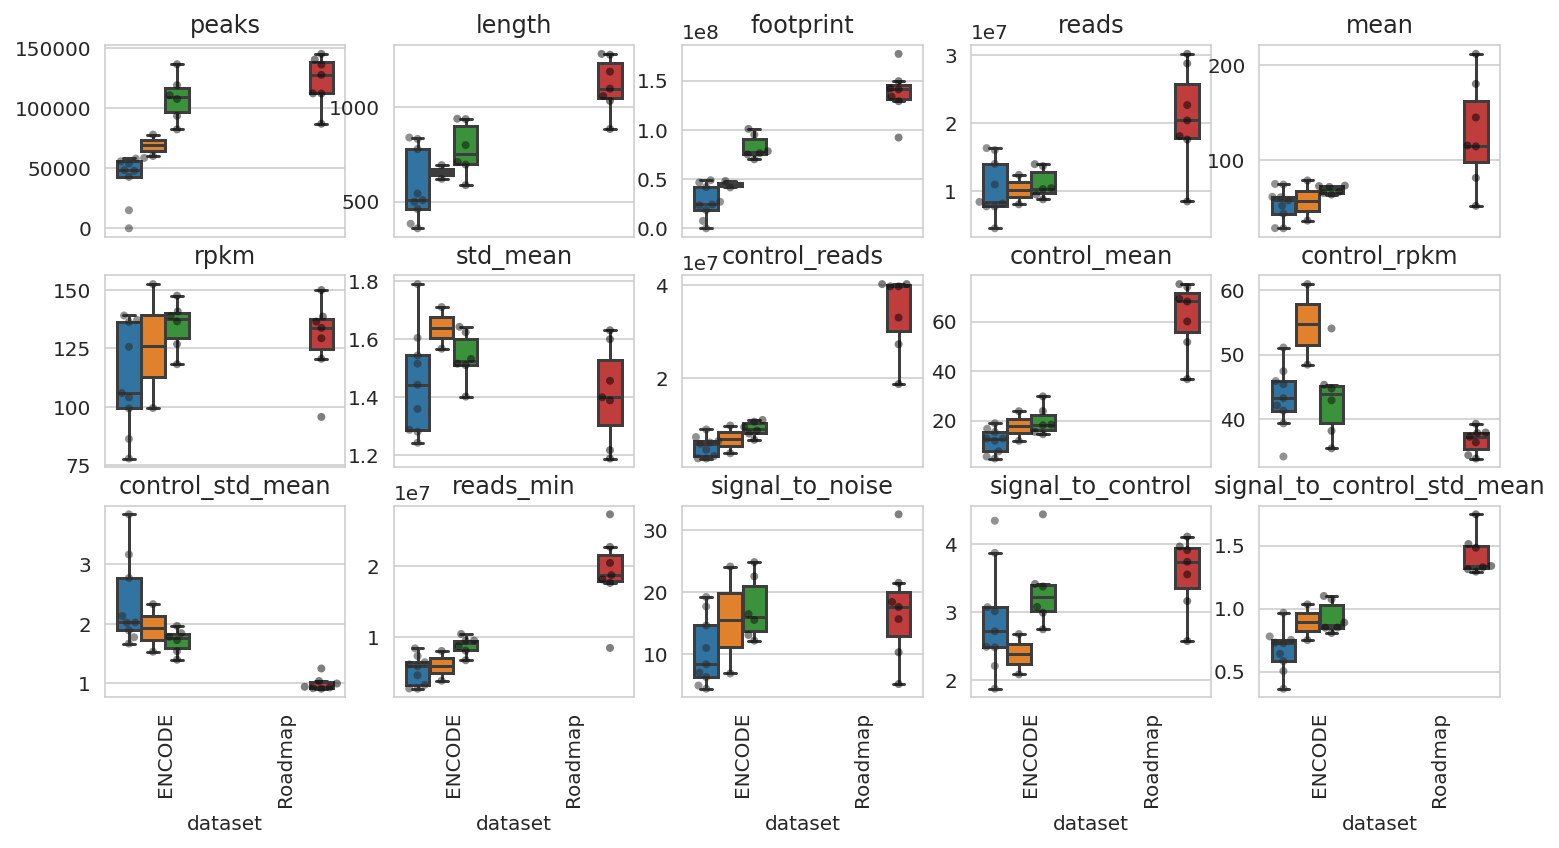

<Figure size 288x216 with 0 Axes>

<Figure size 288x216 with 0 Axes>

<Figure size 288x216 with 0 Axes>

<Figure size 288x216 with 0 Axes>

<Figure size 288x216 with 0 Axes>

<Figure size 288x216 with 0 Axes>

<Figure size 288x216 with 0 Axes>

<Figure size 288x216 with 0 Axes>

<Figure size 288x216 with 0 Axes>

<Figure size 288x216 with 0 Axes>

<Figure size 288x216 with 0 Axes>

<Figure size 288x216 with 0 Axes>

<Figure size 288x216 with 0 Axes>

<Figure size 288x216 with 0 Axes>

<Figure size 288x216 with 0 Axes>

In [604]:
ncols = int(math.ceil(math.sqrt(len(features) + 3)))
nrows = int(math.ceil(len(features) / ncols))
plt.figure(figsize=(2.5 * ncols, 2 * nrows))
axs = [plt.subplot(nrows, ncols, i + 1) for i in range(len(features))]
for i, y in enumerate(features):
    ax = axs[i]
    plt.figure(figsize=(4, 3))
    sns.boxplot(data=tt, x='dataset', y=y,
                hue=['E<60K' if dscr in g1_ds_c_r else 'E>80K' if dscr in g2_ds_c_r else
                'ENCODE other' if 'ENCODE' in dscr else 'Roadmap' for dscr in tt['ds_c_r']],
                hue_order=['E<60K', 'ENCODE other', 'E>80K', 'Roadmap'],
                showfliers=False,
                ax=ax)
    sns.swarmplot(data=tt, x='dataset', y=y,
                  hue=['E<60K' if dscr in g1_ds_c_r else 'E>80K' if dscr in g2_ds_c_r else
                  'ENCODE other' if 'ENCODE' in dscr else 'Roadmap' for dscr in tt['ds_c_r']],
                  hue_order=['E<60K', 'ENCODE other', 'E>80K', 'Roadmap'],
                  dodge=True, size=4, alpha=0.5, palette='dark:black', legend=False,
                  ax=ax)
    ax.title.set_text(y)
    ax.set_ylabel(None)
    if i / ncols < nrows - 1:
        ax.set_xlabel(None)
        ax.set_xticks([], minor=False)
        ax.set_xticklabels([])
    ax.xaxis.set_tick_params(rotation=90)
    if i % nrows == -1:
        sns.move_legend(ax, loc='center left', bbox_to_anchor=(1, 0.5))
    else:
        ax.legend().set_visible(False)
    
plt.tight_layout()
plt.show()

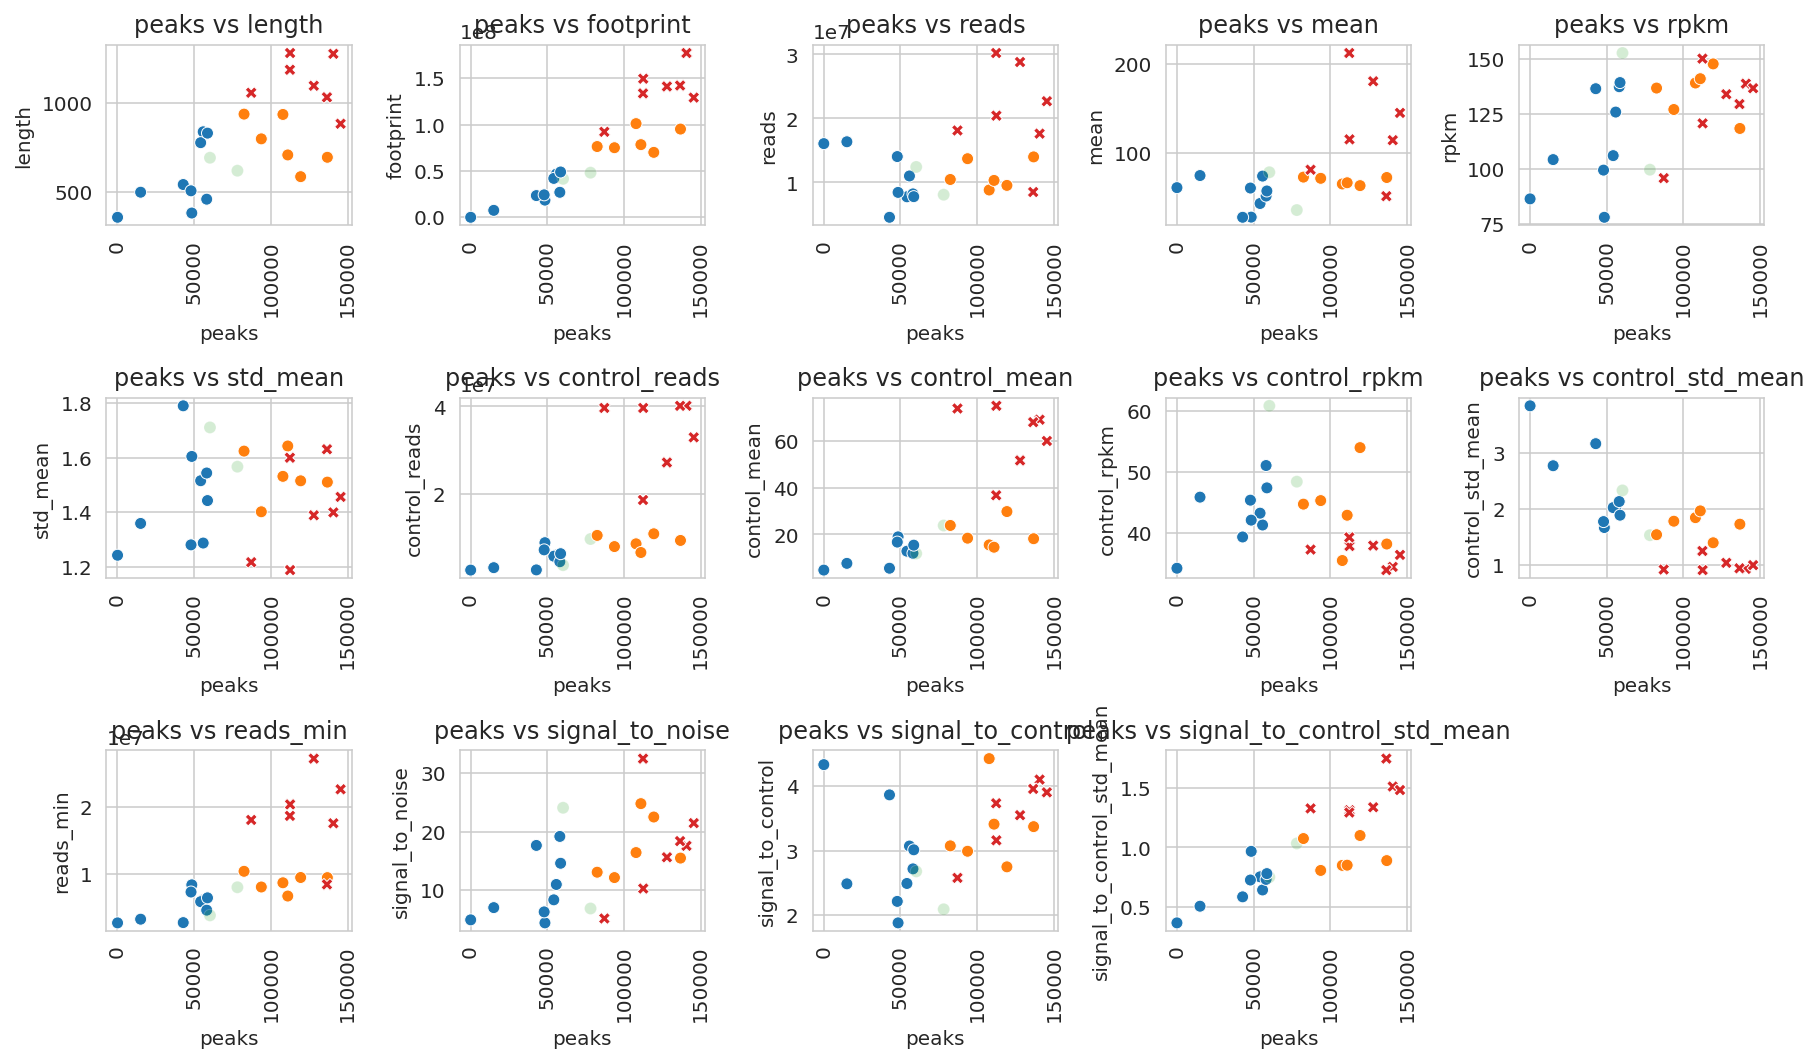

In [605]:
ncols = int(math.ceil(math.sqrt(len(features) + 3)))
nrows = int(math.ceil(len(features) / ncols))
plt.figure(figsize=(2.5 * ncols, 2.5 * nrows))
axs = [plt.subplot(nrows, ncols, i + 1) for i in range(len(features) - 1)]
for i, y in enumerate(f for f in features if f!='peaks'):
    ax = axs[i]
    tt = df_aggr[(df_aggr['modification'] == 'H3K4me1') & (df_aggr['tool'] == TOOL)].copy()
    tt['ds_c_r'] = tt['dataset'] + ' ' + tt['cell'] + ' ' + tt['replicate']
    sns.scatterplot(
        tt, x='peaks', y=y,
        style='dataset',
        hue=['E<60K' if dscr in g1_ds_c_r else 'E>80K' if dscr in g2_ds_c_r else
        'ENCODE other' if 'ENCODE' in dscr else 'Roadmap' for dscr in tt['ds_c_r']],
        alpha=[1 if dscr in g1_ds_c_r or dscr in g2_ds_c_r or 'Roadmap' in dscr else 0.2 for dscr in tt['ds_c_r']],
        ax = ax)
    ax.title.set_text(f'peaks vs {y}')
    ax.xaxis.set_tick_params(rotation=90)
    if i % nrows == -1:
        sns.move_legend(ax, loc='center left', bbox_to_anchor=(1, 0.5))
    else:
        ax.legend().set_visible(False)
plt.tight_layout()
plt.show()



peaks vs signal_to_control_std_mean
Correlation 0.8530434782608695, p 1.1860330601994243e-07


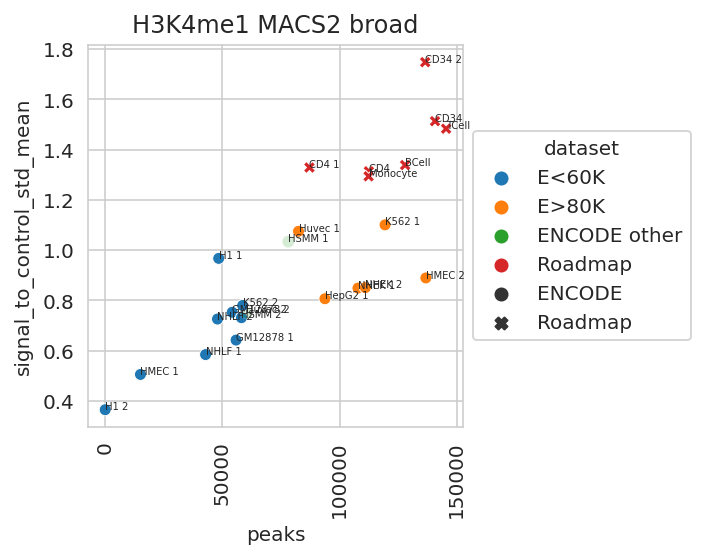



peaks vs reads_min
Correlation 0.8086956521739129, p 1.7332836728352724e-06


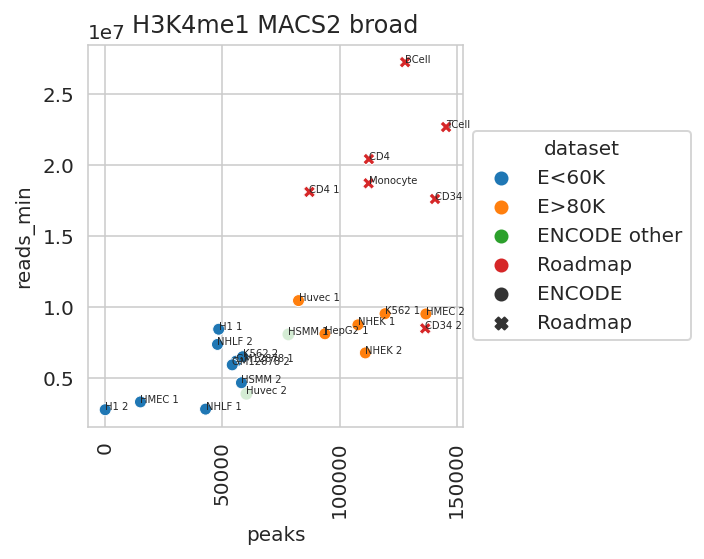



peaks vs std_mean
Correlation 0.03043478260869565, p 0.8877339355759605


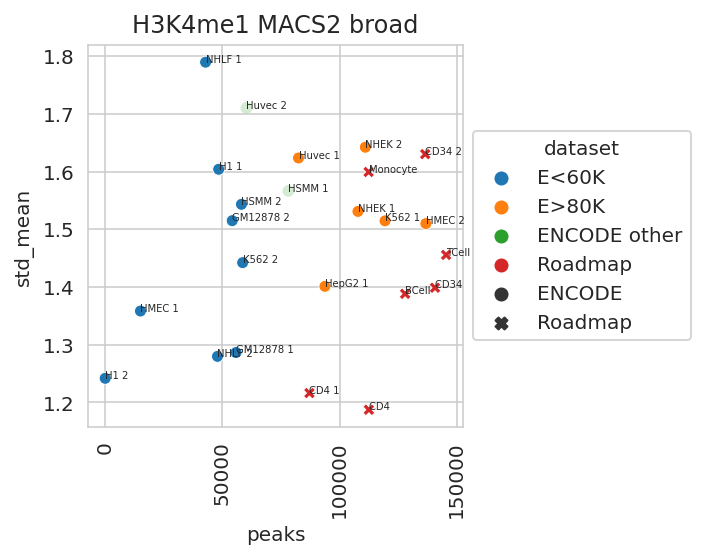

In [621]:
from scipy.stats import spearmanr 
for x, y in [('peaks', 'signal_to_control_std_mean'), ('peaks', 'reads_min'), ('peaks', 'std_mean')]:
    print(f'\n\n{x} vs {y}')
    plt.figure(figsize=(5, 4))
    ax = plt.axes()
    tt = df_aggr[(df_aggr['modification'] == 'H3K4me1') & (df_aggr['tool'] == TOOL)].copy()
    tt['ds_c_r'] = tt['dataset'] + ' ' + tt['cell'] + ' ' + tt['replicate']
    sns.scatterplot(
        tt, x=x, y=y,
        style='dataset',
        hue=['E<60K' if dscr in g1_ds_c_r else 'E>80K' if dscr in g2_ds_c_r else
        'ENCODE other' if 'ENCODE' in dscr else 'Roadmap' for dscr in tt['ds_c_r']],
        alpha=[1 if dscr in g1_ds_c_r or dscr in g2_ds_c_r or 'Roadmap' in dscr else 0.2 for dscr in tt['ds_c_r']],
        ax = ax)
    for xv, yv, cell, rep in zip(tt[x], tt[y], tt['cell'], tt['replicate']):
        rep = '1' if rep == 'rep1' else '2' if rep == 'rep2' else ''
        ax.text(xv, yv, f'{cell} {rep}', fontsize = 5)
    corr, p = spearmanr(tt[x], tt[y])
    print(f'Correlation {corr}, p {p}')
    ax.title.set_text(f'H3K4me1 {TOOL}')
    sns.move_legend(ax, loc='center left', bbox_to_anchor=(1, 0.5))
    if x != 'reads':
        ax.xaxis.set_tick_params(rotation=90)
    plt.tight_layout()
    plt.show()

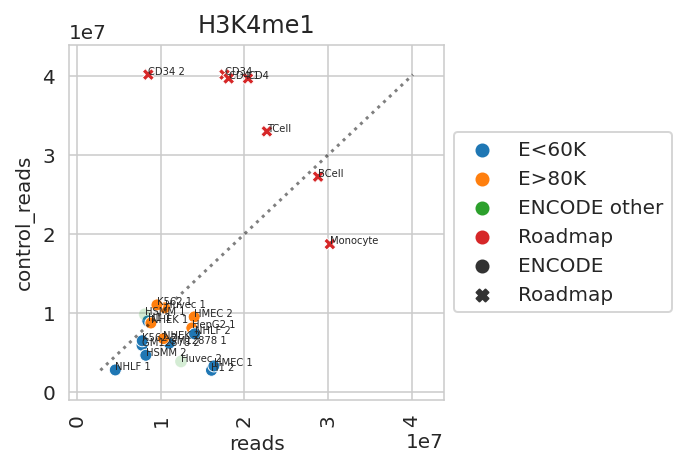

In [607]:
for (x, y) in [('reads', 'control_reads')]:
    plt.figure(figsize=(5, 3.5))
    ax = plt.axes()
    tt = df_aggr[(df_aggr['modification'] == 'H3K4me1') & (df_aggr['tool'] == TOOL)].copy()
    tt['ds_c_r'] = tt['dataset'] + ' ' + tt['cell'] + ' ' + tt['replicate']
    sns.scatterplot(
        tt, x=x, y=y,
        style='dataset',
        hue=['E<60K' if dscr in g1_ds_c_r else 'E>80K' if dscr in g2_ds_c_r else
        'ENCODE other' if 'ENCODE' in dscr else 'Roadmap' for dscr in tt['ds_c_r']],
        alpha=[1 if dscr in g1_ds_c_r or dscr in g2_ds_c_r or 'Roadmap' in dscr else 0.2 for dscr in tt['ds_c_r']],
        ax = ax)
    for xv, yv, cell, rep in zip(tt[x], tt[y], tt['cell'], tt['replicate']):
        rep = '1' if rep == 'rep1' else '2' if rep == 'rep2' else ''
        ax.text(xv, yv, f'{cell} {rep}', fontsize = 5)
    minr = min(tt[x].min(), tt[y].min())
    maxr = max(tt[x].max(), tt[y].max())
    sns.lineplot(x=[minr, maxr], y=[minr, maxr], color='black', ax=ax, alpha=0.5, linestyle='dotted')
    ax.set_xlim(minr - 0.1 * (maxr - minr), maxr + 0.1 * (maxr - minr))
    ax.set_ylim(minr - 0.1 * (maxr - minr), maxr + 0.1 * (maxr - minr))
    ax.title.set_text('H3K4me1')
    sns.move_legend(ax, loc='center left', bbox_to_anchor=(1, 0.5))
    ax.xaxis.set_tick_params(rotation=90)
    plt.tight_layout()
    plt.show()

In [608]:
t_h1 = df_aggr[(df_aggr['modification'] == 'H3K4me1') & (df_aggr['cell'] == 'HMEC') & (df_aggr['tool'] == 'MACS2 broad')].copy()
t_h1.sort_values(by=['peaks'], inplace=True)
t_h1[['replicate'] + features]

replicate   peaks    length   footprint     reads      mean        rpkm  \
219      rep1   15099  499.9892   7524484.0  16351916  74.47875  104.111970   
223      rep2  136806  695.4093  95219662.0  13989144  72.27375  118.248141   

     std_mean  control_reads  control_mean  control_rpkm  control_std_mean  \
219  1.358437    3322364.617       7.62625     45.908567          2.771376   
223  1.509866    9518547.599      18.18250     38.204358          1.729498   

       reads_min  signal_to_noise  signal_to_control  \
219  3322364.617         7.037916           2.484662   
223  9518547.599        15.509388           3.373837   

     signal_to_control_std_mean  
219                    0.505384  
223                    0.889403

H3K4me1 MACS2 broad


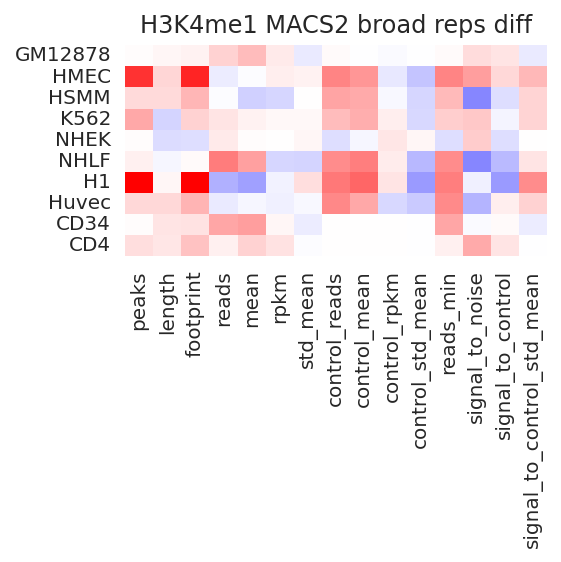

In [609]:
for m in ['H3K4me1']:
# for m in ['H3K27ac', 'H3K4me1']:
    print(m, TOOL)
    ts = []
    # for cell in ['HMEC']:
    for cell in GSE26320_CELLS + IMMUNE_CELLS:
        tt = df_aggr[(df_aggr['modification'] == m) & (df_aggr['cell'] == cell) & (df_aggr['tool'] == TOOL)].copy()
        if len(tt) != 2:
            continue
        tt.sort_values(by=['peaks'], inplace=True)
        tt = pd.DataFrame([[(tt[f].values[1] - tt[f].values[0]) / (tt[f].values[1] + tt[f].values[0]) for f in features]], 
                          columns = features)
        tt.index = [cell]
        ts.append(tt)
    df_diff_reps = pd.concat(ts)
    plt.figure(figsize=(4, 4))
    ax = plt.axes()
    sns.heatmap(df_diff_reps, cmap='bwr', vmin=-1, vmax=1, ax=ax, cbar=False)
    ax.xaxis.set_tick_params(rotation=90)
    ax.yaxis.set_tick_params(rotation=0)
    ax.set_title(f'{m} {TOOL} reps diff')
    plt.tight_layout()
    plt.show()

PCA of aggregated datasets


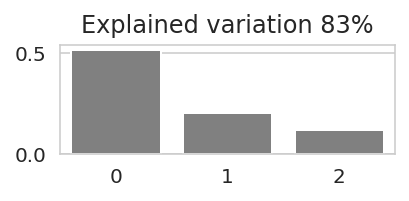

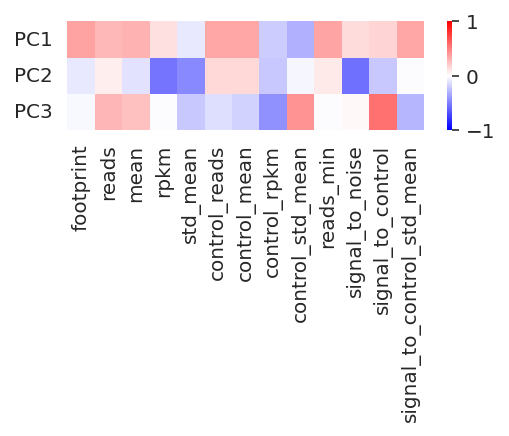

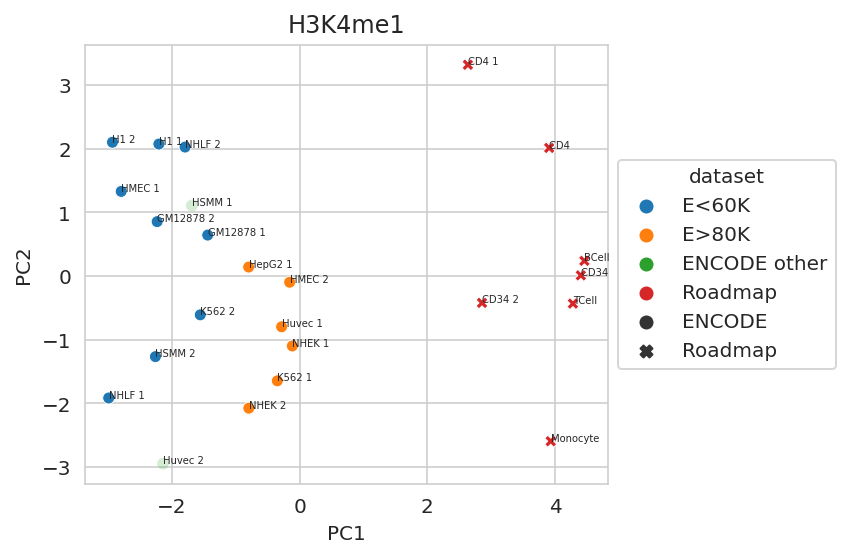

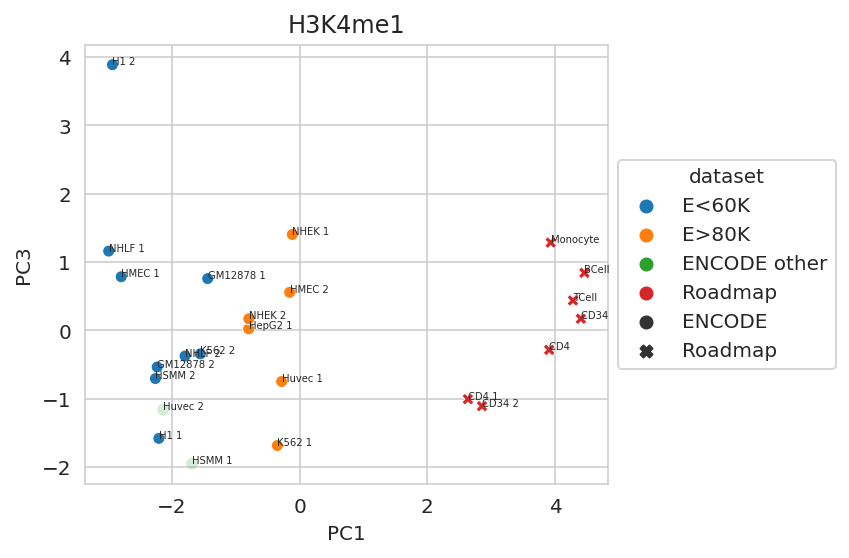

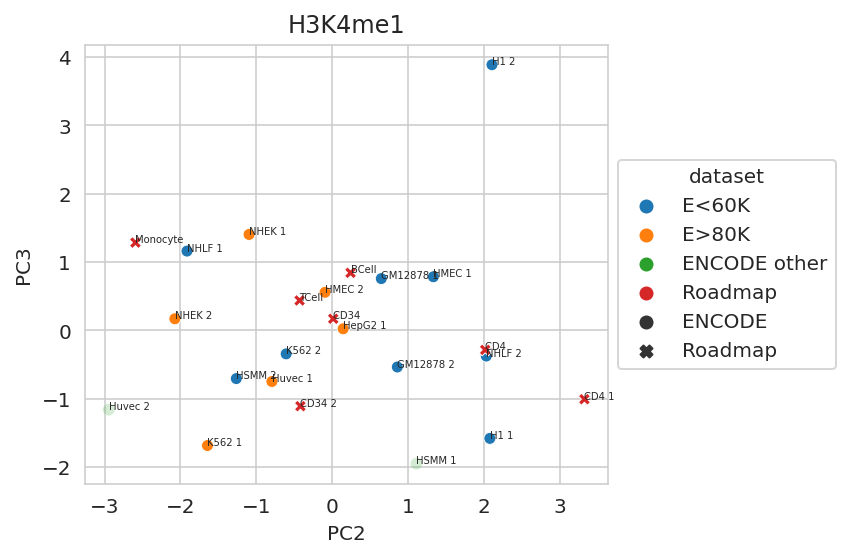

In [610]:
print('PCA of aggregated datasets')
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

tt = df_aggr[(df_aggr['modification'] == 'H3K4me1') & (df_aggr['tool'] == TOOL)].copy()
tt['ds_c_r'] = tt['dataset'] + ' ' + tt['cell'] + ' ' + tt['replicate']

# n = 'mle'
n = 3
pca = PCA(n_components=n)
# pca_features = [f for f in features if f not in ['peaks', 'length', 'reads', 'mean', 'control_mean']]
pca_features = [f for f in features if f not in ['peaks', 'length']]
ttn = StandardScaler().fit_transform(tt[pca_features]) # (n_samples x n_features)
result_pca = pca.fit_transform(ttn)

plt.figure(figsize=(3, 1))
plt.title(f'Explained variation {int(np.sum(pca.explained_variance_ratio_) * 100)}%')
sns.barplot(x=list(range(pca.n_components_)), y=pca.explained_variance_ratio_, color='gray')
plt.show()

rdgn = sns.diverging_palette(h_neg=130, h_pos=10, s=99, l=55, sep=3, as_cmap=True)

plt.figure(figsize=(4, 1))
sns.heatmap(pca.components_,
            cmap='bwr', vmin=-1, vmax=1,
            yticklabels=[f'PC{i + 1}' for i in range(pca.n_components_)],
            xticklabels=pca_features)
plt.show()

for c1, c2 in [(0, 1), (0, 2), (1, 2)]:
    xs = result_pca[:, c1]
    ys = result_pca[:, c2]
    plt.figure(figsize=(6, 4))
    ax = plt.axes()
    sns.scatterplot(
        tt, x=xs, y=ys,
        style='dataset',
        hue=['E<60K' if dscr in g1_ds_c_r else 'E>80K' if dscr in g2_ds_c_r else
        'ENCODE other' if 'ENCODE' in dscr else 'Roadmap' for dscr in tt['ds_c_r']],
        alpha=[1 if dscr in g1_ds_c_r or dscr in g2_ds_c_r or 'Roadmap' in dscr else 0.2 for dscr in tt['ds_c_r']],
        ax = ax)
    for xv, yv, cell, rep in zip(xs, ys, tt['cell'], tt['replicate']):
        rep = '1' if rep == 'rep1' else '2' if rep == 'rep2' else ''
        ax.text(xv, yv, f'{cell} {rep}', fontsize = 5)
    ax.title.set_text('H3K4me1')
    sns.move_legend(ax, loc='center left', bbox_to_anchor=(1, 0.5))
    ax.set_xlabel(f'PC{c1+1}')
    ax.set_ylabel(f'PC{c2+1}')
    plt.tight_layout()
    plt.show()

dataset modification     cell replicate  signal_to_noise       sum  \
0     ENCODE      H3K27ac  GM12878      rep1        23.033682  12651.25   
1     ENCODE      H3K27ac  GM12878      rep1        23.033682  12651.25   
2     ENCODE      H3K27ac  GM12878      rep1        23.033682  12651.25   
3     ENCODE      H3K27ac  GM12878      rep1        23.033682  12651.25   
4     ENCODE      H3K27ac  GM12878      rep2        20.746462   8428.25   
..       ...          ...      ...       ...              ...       ...   
501  Roadmap      H3K4me3  TCellBB      rep1        11.752838   3364.25   
502  Roadmap      H3K4me3  TCellBB      rep2        16.055701   6125.25   
503  Roadmap      H3K4me3  TCellBB      rep2        16.055701   6125.25   
504  Roadmap      H3K4me3  TCellBB      rep2        16.055701   6125.25   
505  Roadmap      H3K4me3  TCellBB      rep2        16.055701   6125.25   

         mean        std        rpkm  std_mean  ...  control_rpkm  \
0    63.25625  93.388439  169.966557  1.904298  ...     39.601698   
1    63.25625  93.388439  169.966557  1.904298  ...     39.601698   
2    63.25625  93.388439  169.966557  1.904298  ...     39.601698   
3    63.25625  93.388439  169.966557  1.904298  ...     39.601698   
4    42.14125  73.346979  136.774406  2.042367  ...     41.316618   
..        ...        ...         ...       ...  ...           ...   
501  16.82125  39.751421  103.472254  2.594764  ...     36.259759   
502  30.62625  63.508592  143.048395  2.367779  ...     35.234562   
503  30.62625  63.508592  143.048395  2.367779  ...     35.234562   
504  30.62625  63.508592  143.048395  2.367779  ...     35.234562   
505  30.62625  63.508592  143.048395  2.367779  ...     35.234562   

     control_std_mean  signal_to_control_std_mean                ds_c_r  \
0            2.102742                    0.914852   ENCODE GM12878 rep1   
1            2.102742                    0.914852   ENCODE GM12878 rep1   
2            2.102742                    0.914852   ENCODE GM12878 rep1   
3            2.102742                    0.914852   ENCODE GM12878 rep1   
4            2.079342                    0.994874   ENCODE GM12878 rep2   
..                ...                         ...                   ...   
501          2.048642                    1.301780  Roadmap TCellBB rep1   
502          2.079317                    1.166915  Roadmap TCellBB rep2   
503          2.079317                    1.166915  Roadmap TCellBB rep2   
504          2.079317                    1.166915  Roadmap TCellBB rep2   
505          2.079317                    1.166915  Roadmap TCellBB rep2   

            tool  peaks    reads     length    footprint    reads_min  
0          MACS2  47290  7049058   892.0439   41890163.0  6192916.312  
1    MACS2 broad  41044  7049058  1240.3551   50273069.0  6192916.312  
2          SICER  32861  7049058  3820.8600  124120539.0  6192916.312  
3           SPAN  35376  7049058  2731.6123   96393002.0  6192916.312  
4          MACS2  43917  5783112   871.6886   38095017.0  5783112.000  
..           ...    ...      ...        ...          ...          ...  
501         SPAN  20034  2963533  1437.6956   28869988.0  2963533.000  
502        MACS2  35225  3902197   886.4609   31412710.0  3902197.000  
503  MACS2 broad  36439  3902197  1051.5120   38651696.0  3902197.000  
504        SICER  29667  3902197  2266.4200   67583133.0  3902197.000  
505         SPAN  24019  3902197  1695.2720   40361603.0  3902197.000  

[506 rows x 25 columns]

# All modifications / tools

MACS2


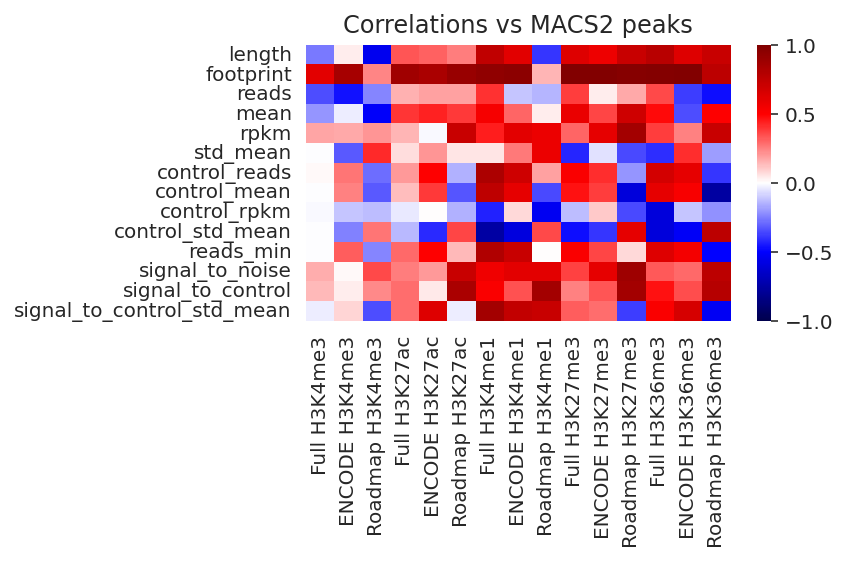

MACS2 broad


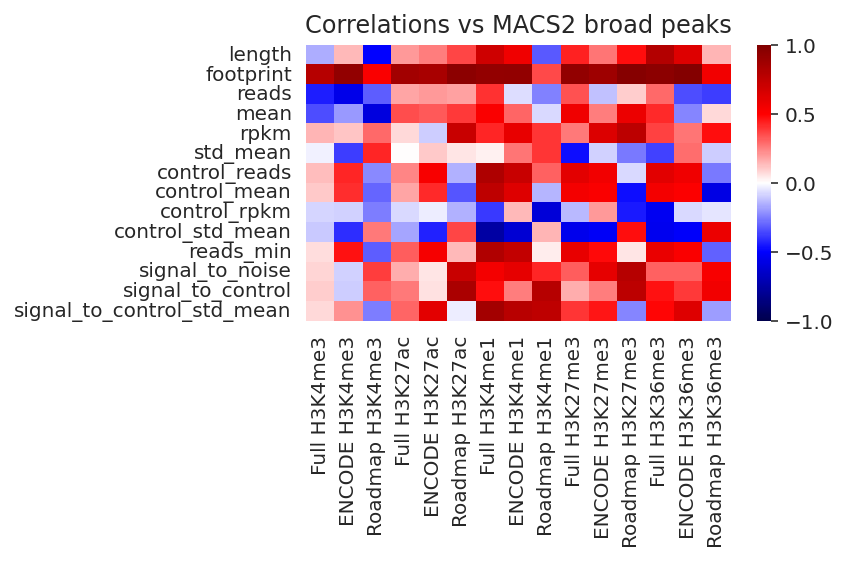

SPAN


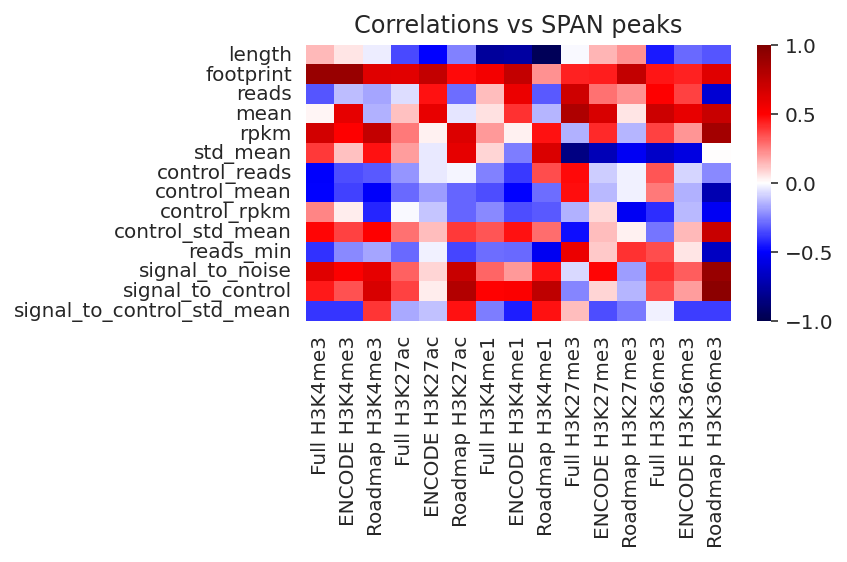

SICER


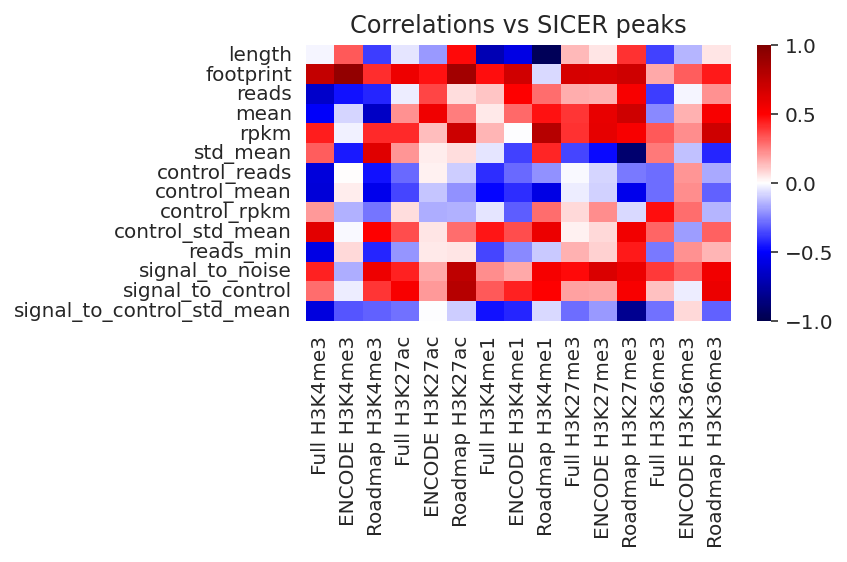

MACS2


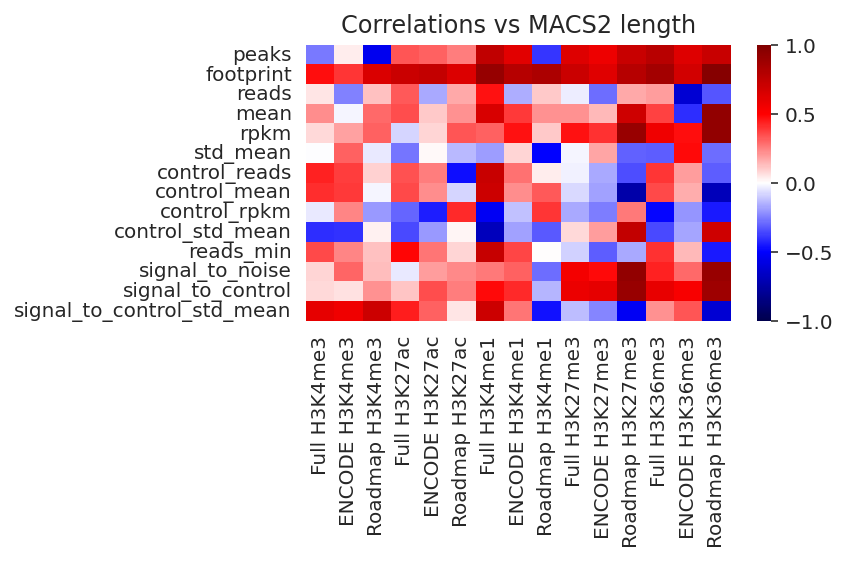

MACS2 broad


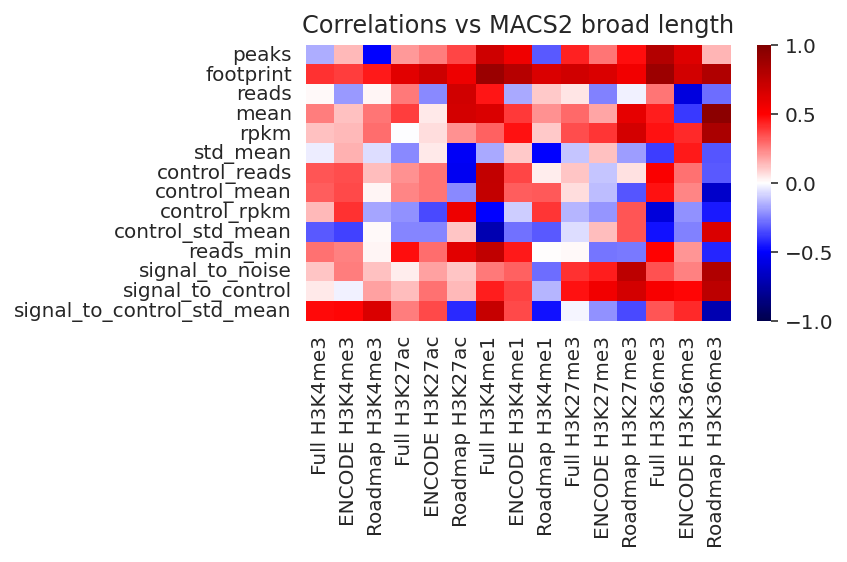

SPAN


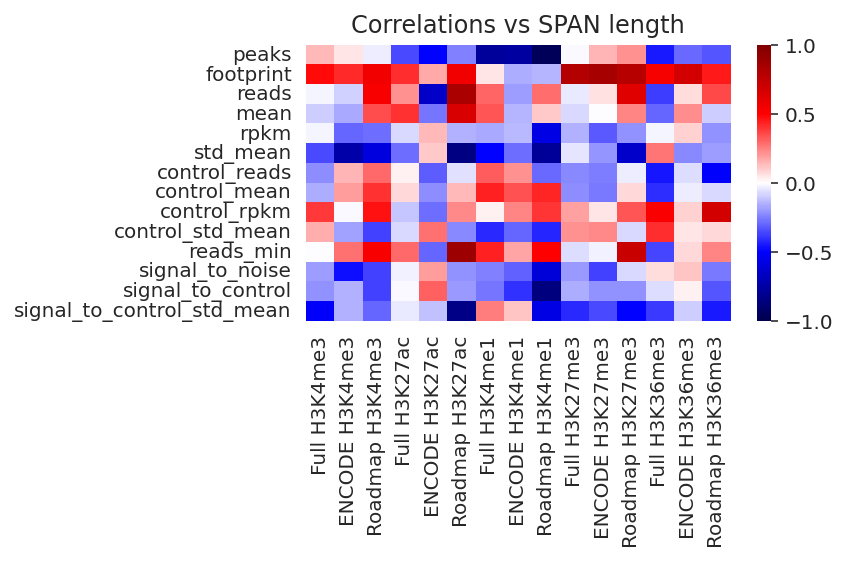

SICER


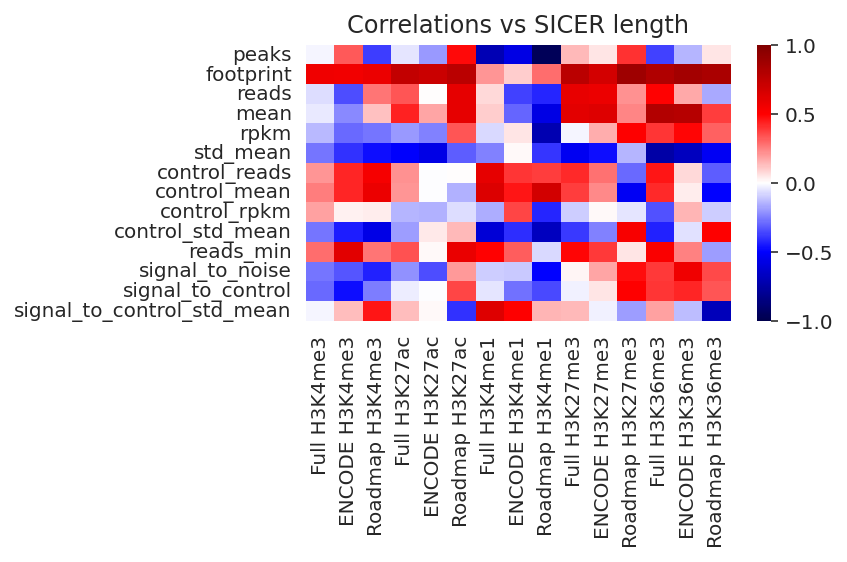

In [613]:
features = ['peaks', 'length', 'footprint',
            'reads', 'mean', 'rpkm', 'std_mean',
            'control_reads', 'control_mean', 'control_rpkm', 'control_std_mean',
            'reads_min',
            'signal_to_noise', 'signal_to_control', 'signal_to_control_std_mean']
for f in ['peaks', 'length']:
    for tool in TOOLS:
        print(tool)
        ts = []
        for m in MODIFICATIONS:
            tt = df_aggr[(df_aggr['modification'] == m) & (df_aggr['tool'] == tool)]
            ts.append(pd.DataFrame({f'Full {m}': tt[features].corr(method='spearman')[f],
                                f'ENCODE {m}': tt[tt['dataset'] == 'ENCODE'][features].corr(method='spearman')[f],
                                f'Roadmap {m}': tt[tt['dataset'] == 'Roadmap'][features].corr(method='spearman')[f]}))
        tt = pd.concat(ts, axis=1)
        tt.drop(f, axis=0, inplace=True)
        plt.figure(figsize=(6, 4))
        ax = plt.axes()
        sns.heatmap(tt, cmap=plt.cm.seismic, vmin=-1, vmax=1, ax=ax)
        ax.xaxis.set_tick_params(rotation=90)
        ax.set_title(f'Correlations vs {tool} {f}')
        plt.tight_layout()
        plt.show()

# Predict number of peaks

MACS2 H3K4me3 R2: train 0.81 validate: -2.3
MACS2 H3K27ac R2: train 0.88 validate: 0.62
MACS2 H3K4me1 R2: train 0.91 validate: 0.81
MACS2 H3K27me3 R2: train 0.78 validate: -0.098
MACS2 H3K36me3 R2: train 0.95 validate: -0.12


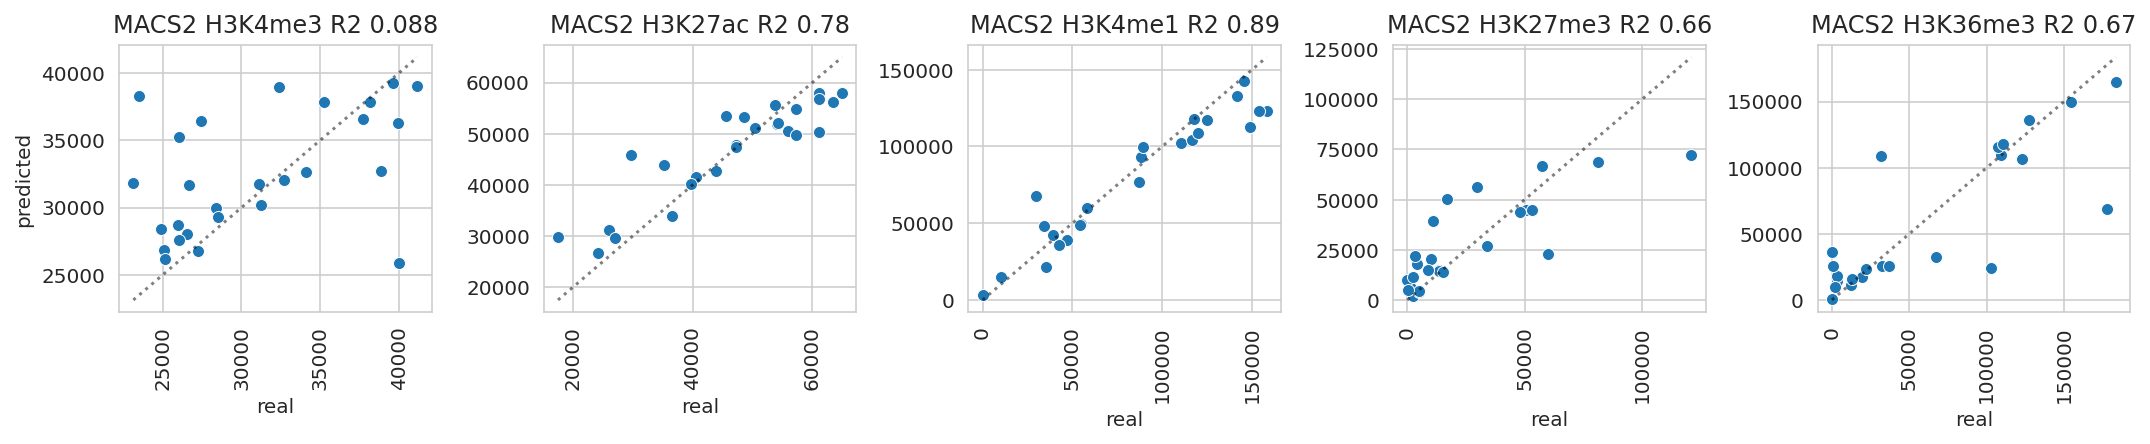

MACS2 broad H3K4me3 R2: train 0.76 validate: -0.14
MACS2 broad H3K27ac R2: train 0.37 validate: -0.072
MACS2 broad H3K4me1 R2: train 0.92 validate: 0.54
MACS2 broad H3K27me3 R2: train 0.84 validate: 0.011
MACS2 broad H3K36me3 R2: train 0.88 validate: 0.43


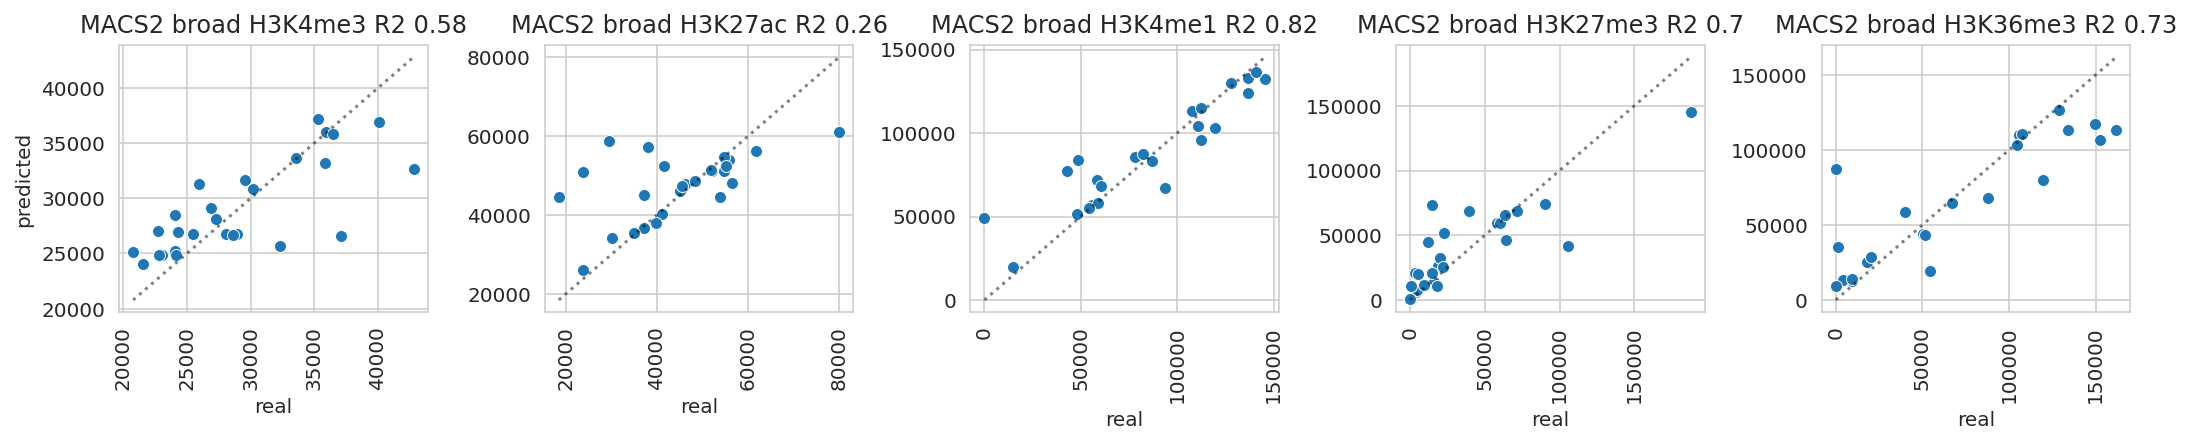

SPAN H3K4me3 R2: train 0.85 validate: -0.44
SPAN H3K27ac R2: train 0.74 validate: -0.88
SPAN H3K4me1 R2: train 0.88 validate: -0.36
SPAN H3K27me3 R2: train 0.78 validate: 0.36
SPAN H3K36me3 R2: train 0.9 validate: 0.024


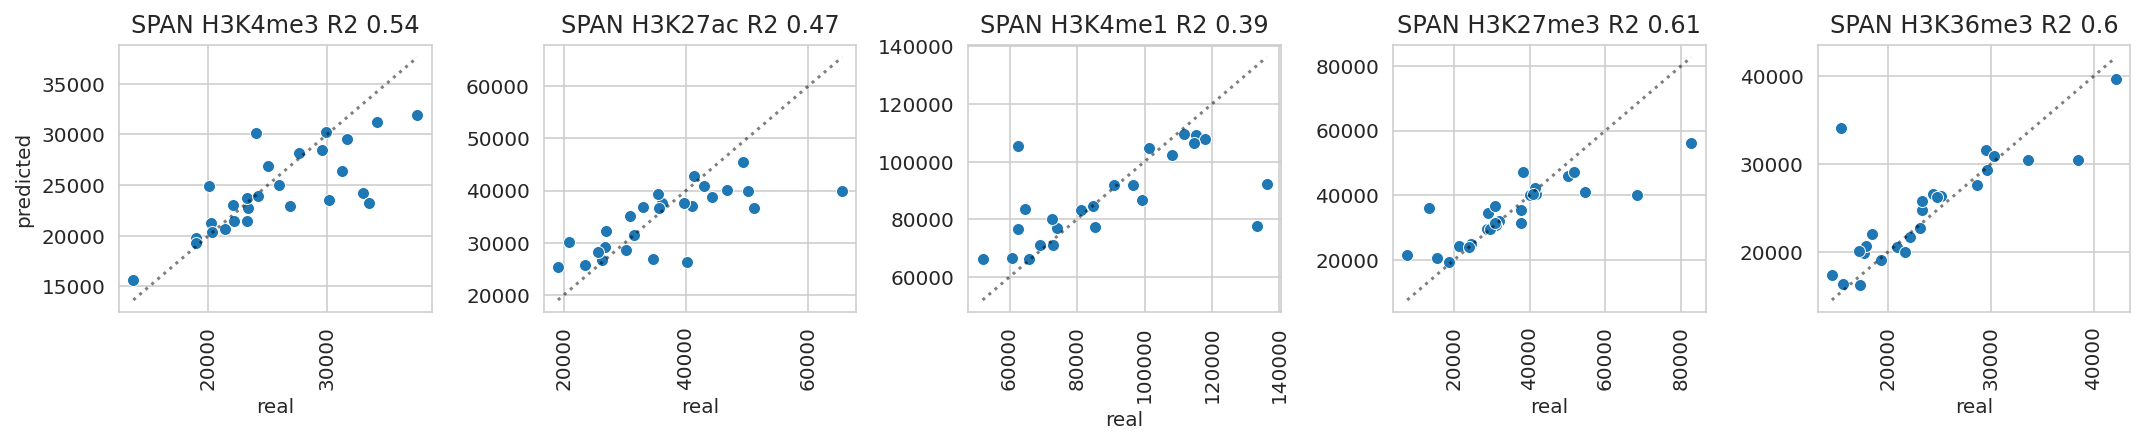

SICER H3K4me3 R2: train 0.91 validate: 0.27
SICER H3K27ac R2: train 0.81 validate: -0.49
SICER H3K4me1 R2: train 0.88 validate: -0.85
SICER H3K27me3 R2: train 0.8 validate: -0.022
SICER H3K36me3 R2: train 0.79 validate: -0.26


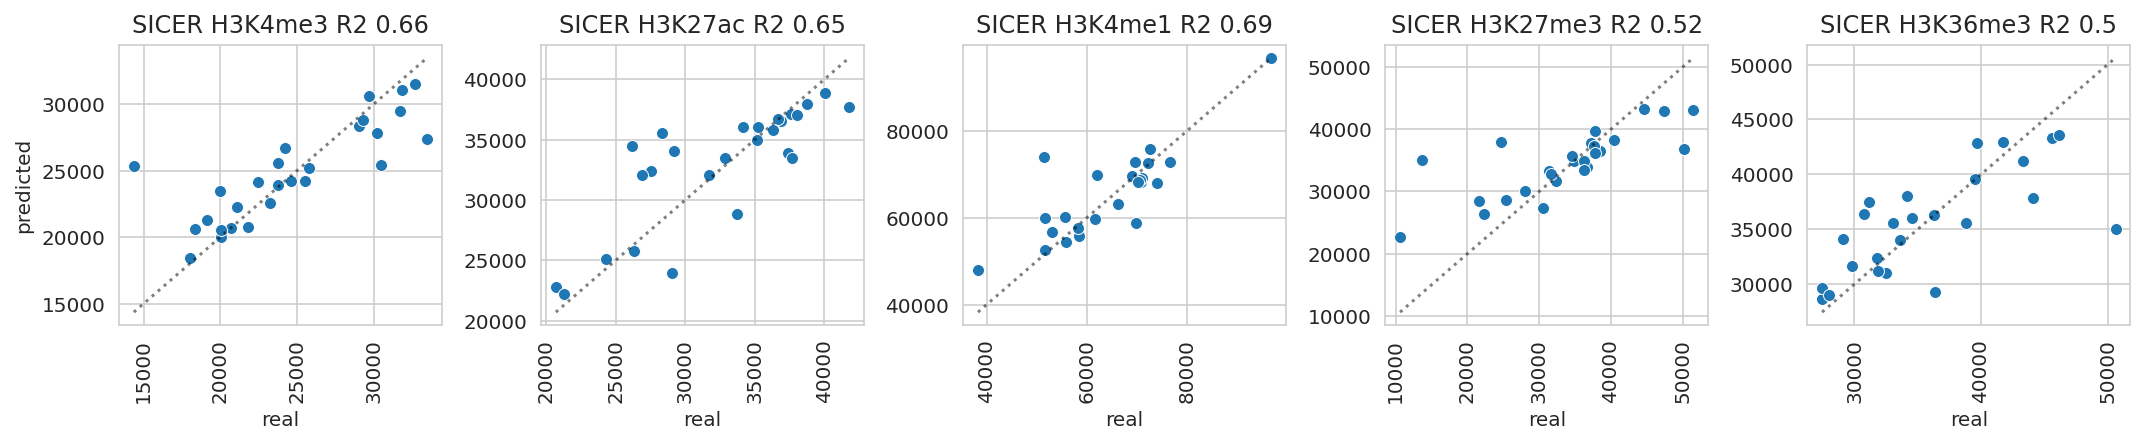

In [387]:
from sklearn.metrics import mean_squared_error as mse
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split

for tool in TOOLS:
    plt.figure(figsize=(15, 3.2))
    axs = [plt.subplot(1, 5, i + 1) for i in range(5)]
    for i, m in enumerate(MODIFICATIONS):
        ax = axs[i]
        tt = df_aggr[(df_aggr['modification'] == m) & (df_aggr['tool'] == tool)].copy()
        tt.fillna(0, inplace=True)
        features_predict = [f for f in features if f not in ['peaks', 'length', 'footprint']]
        # features_predict = [f for f in features if 'control' in features or f == 'reads_min']
        x_all = tt[features_predict]
        y_all = tt['peaks']
        X, X_val, y, y_val = train_test_split(x_all, y_all)
        Rf = RandomForestRegressor(n_estimators=10, n_jobs=-1)
        Rf.fit(X, y)
        print(f'{tool} {m} R2: train {Rf.score(X, y):.2} validate: {Rf.score(X_val, y_val):.2}')
        ax.title.set_text(f'{tool} {m} R2 {Rf.score(x_all, y_all):.2}')
        # plot the model
        y_pred = Rf.predict(x_all)
        sns.scatterplot(x=y_all, y=y_pred, ax=ax)
        ax.set_xlabel('real')
        if i > 0:
            ax.set_ylabel(None)
        else:
            ax.set_ylabel('predicted')
        # generate and graph y = x line
        maxxy = max(np.max(y_pred), np.max(y_all))
        minxy = min(np.min(y_pred), np.min(y_all))
        sns.lineplot(x=[minxy, maxxy], y=[minxy, maxxy], color='black', ax=ax, alpha=0.5, linestyle='dotted')
        ax.xaxis.set_tick_params(rotation=90)

    plt.tight_layout()
    plt.show()

# Difference

In [238]:
def compute_diffs(df, modifications, cells, replicates):
    tools = df['tool'].unique()
    rows = []    
    tf = tempfile.mktemp()
    for m, c, r in tqdm(list(product(modifications, cells, replicates))):
        print(m, c, r)
        t = df[(df['modification'] == m) & (df['cell'] == c) & (df['replicate'] == r) & (df['tool'] == 'SPAN')]
        if len(t) == 0:
            continue
        span_file = sorted_file(t['file'].values[0])
        # Processing single tools information
        for tool in tools:
            if tool == 'SPAN':
                continue
            t = df[(df['modification'] == m) & (df['cell'] == c) & (df['replicate'] == r) & (df['tool'] == tool)]
            if len(t) == 0:
                continue
            peaks_file = sorted_file(t['file'].values[0])
            for name, args in [
                (f'SPAN - {tool}', f' -a {span_file} -b {peaks_file} '),
                (f'{tool} - SPAN', f' -b {span_file} -a {peaks_file} ')]:
                !bedtools intersect {args} -wa -v > {tf}
                peaks = lines(tf)
                rows.append((m, c, r, name, peaks))

    return pd.DataFrame(rows, columns=['modification', 'cell', 'replicate', 'name', 'peaks'])

## ENCODE

In [239]:
df_encode_diff = compute_diffs(df_encode_peaks, MODIFICATIONS, GSE26320_CELLS, GSE26320_REPS)
df_encode_diff.sample(5)

  0%|          | 0/90 [00:00<?, ?it/s]

H3K4me3 GM12878 rep1
H3K4me3 GM12878 rep2
H3K4me3 HMEC rep1
H3K4me3 HMEC rep2
H3K4me3 HSMM rep1
H3K4me3 HSMM rep2
H3K4me3 K562 rep1
H3K4me3 K562 rep2
H3K4me3 NHEK rep1
H3K4me3 NHEK rep2
H3K4me3 NHLF rep1
H3K4me3 NHLF rep2
H3K4me3 H1 rep1
H3K4me3 H1 rep2
H3K4me3 Huvec rep1
H3K4me3 Huvec rep2
H3K4me3 HepG2 rep1
H3K4me3 HepG2 rep2
H3K27ac GM12878 rep1
H3K27ac GM12878 rep2
H3K27ac HMEC rep1
H3K27ac HMEC rep2
H3K27ac HSMM rep1
H3K27ac HSMM rep2
H3K27ac K562 rep1
H3K27ac K562 rep2
H3K27ac NHEK rep1
H3K27ac NHEK rep2
H3K27ac NHLF rep1
H3K27ac NHLF rep2
H3K27ac H1 rep1
H3K27ac H1 rep2
H3K27ac Huvec rep1
H3K27ac Huvec rep2
H3K27ac HepG2 rep1
H3K27ac HepG2 rep2
H3K4me1 GM12878 rep1
H3K4me1 GM12878 rep2
H3K4me1 HMEC rep1
H3K4me1 HMEC rep2
H3K4me1 HSMM rep1
H3K4me1 HSMM rep2
H3K4me1 K562 rep1
H3K4me1 K562 rep2
H3K4me1 NHEK rep1
H3K4me1 NHEK rep2
H3K4me1 NHLF rep1
H3K4me1 NHLF rep2
H3K4me1 H1 rep1
H3K4me1 H1 rep2
H3K4me1 Huvec rep1
H3K4me1 Huvec rep2
H3K4me1 HepG2 rep1
H3K4me1 HepG2 rep2
H3K27me3 G

modification   cell replicate                name  peaks
155      H3K27ac   NHEK      rep2        SICER - SPAN    126
387     H3K27me3  Huvec      rep1  MACS2 broad - SPAN    451
69       H3K4me3     H1      rep1  MACS2 broad - SPAN    876
298      H3K4me1  HepG2      rep1        SPAN - SICER  17528
286      H3K4me1  Huvec      rep1        SPAN - SICER  15228

H3K4me3
H3K27ac
H3K4me1


/home/jetbrains/miniconda3/envs/pubtrends/lib/python3.10/site-packages/seaborn/categorical.py:3544: UserWarning: 17.6% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/jetbrains/miniconda3/envs/pubtrends/lib/python3.10/site-packages/seaborn/categorical.py:3544: UserWarning: 5.9% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


H3K27me3


/home/jetbrains/miniconda3/envs/pubtrends/lib/python3.10/site-packages/seaborn/categorical.py:3544: UserWarning: 17.6% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/jetbrains/miniconda3/envs/pubtrends/lib/python3.10/site-packages/seaborn/categorical.py:3544: UserWarning: 5.9% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/jetbrains/miniconda3/envs/pubtrends/lib/python3.10/site-packages/seaborn/categorical.py:3544: UserWarning: 11.1% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


H3K36me3


/home/jetbrains/miniconda3/envs/pubtrends/lib/python3.10/site-packages/seaborn/categorical.py:3544: UserWarning: 17.6% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/jetbrains/miniconda3/envs/pubtrends/lib/python3.10/site-packages/seaborn/categorical.py:3544: UserWarning: 5.9% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/jetbrains/miniconda3/envs/pubtrends/lib/python3.10/site-packages/seaborn/categorical.py:3544: UserWarning: 11.1% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/jetbrains/miniconda3/envs/pubtrends/lib/python3.10/site-packages/seaborn/categorical.py:3544: UserWarning: 23.5% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWa

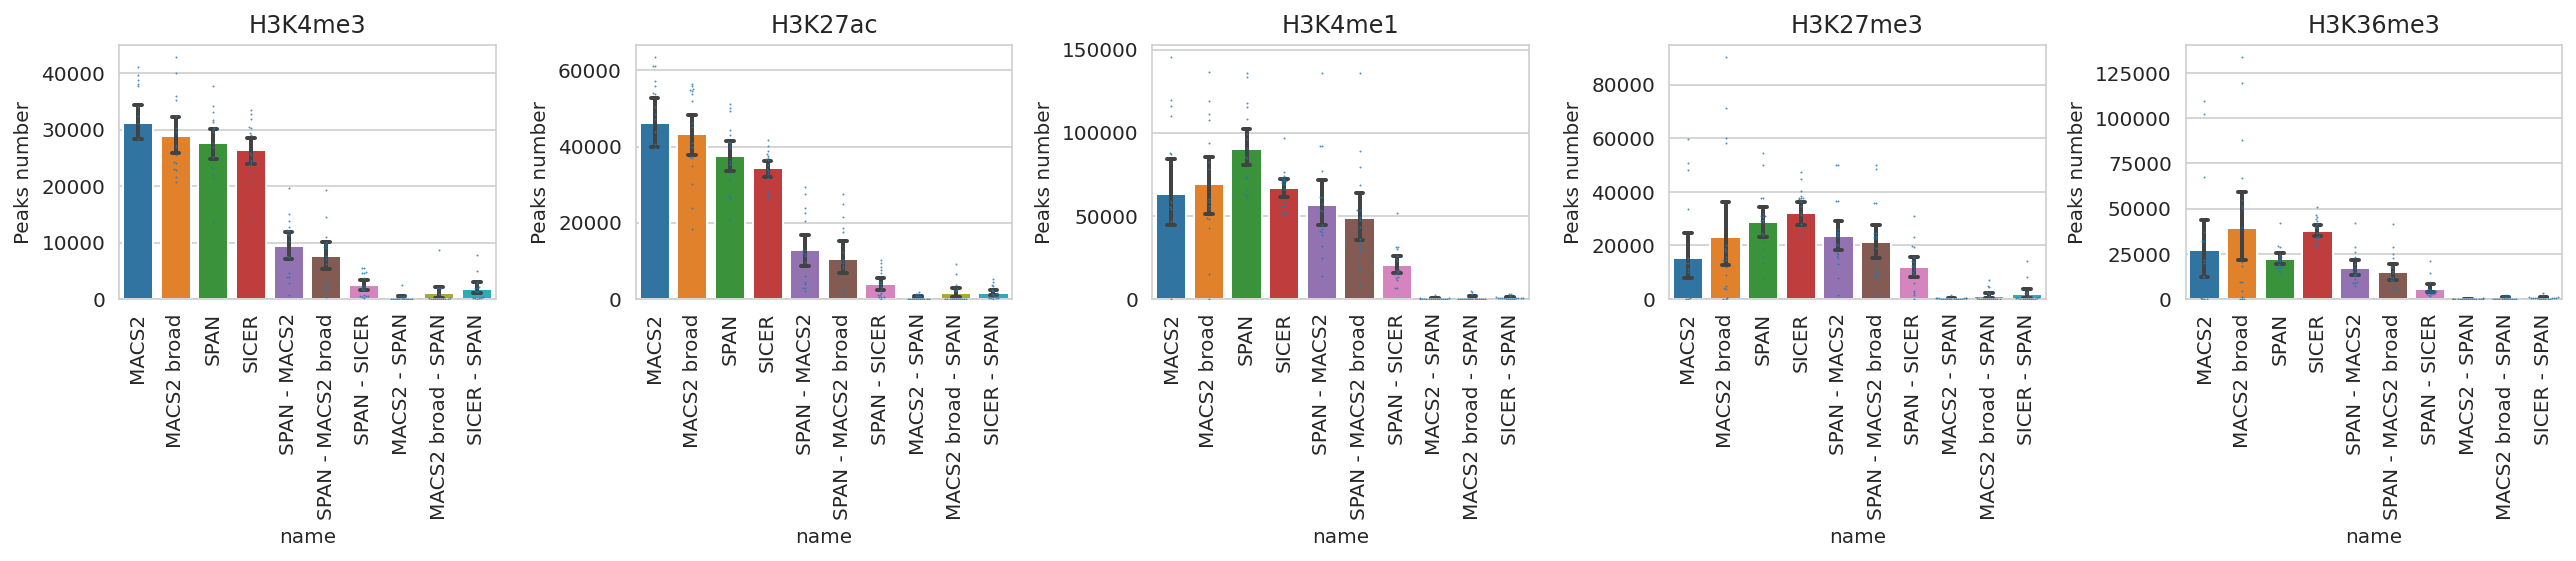

In [240]:
t = df_encode_peaks[['modification', 'cell', 'replicate', 'tool', 'peaks']].copy()
t.rename({'tool': 'name'}, axis=1, inplace=True)
t = pd.concat([t, df_encode_diff]).reset_index(drop=True)

plt.figure(figsize=(18, 4))
axs = [plt.subplot(1, 5, i + 1) for i in range(5)]

for i, m in enumerate(MODIFICATIONS):
    ax = axs[i]
    print(m)
    ax.title.set_text(m)
    sns.barplot(data=t[t['modification'] == m], x='name', y='peaks',                           
                capsize=.2, errwidth=2,
                order=['MACS2', 'MACS2 broad', 'SPAN', 'SICER',
                       'SPAN - MACS2', 'SPAN - MACS2 broad', 'SPAN - SICER',
                       'MACS2 - SPAN', 'MACS2 broad - SPAN', 'SICER - SPAN',
                       ],
                ax=ax)
    sns.swarmplot(data=t[t['modification'] == m], x='name', y='peaks',
                  dodge=True, size=1, alpha=0.8,
                  order=['MACS2', 'MACS2 broad', 'SPAN', 'SICER',
                         'SPAN - MACS2', 'SPAN - MACS2 broad', 'SPAN - SICER',
                         'MACS2 - SPAN', 'MACS2 broad - SPAN', 'SICER - SPAN',
                         ],
                  ax=ax)
    ax.xaxis.set_tick_params(rotation=90)
    ax.set_ylabel('Peaks number')
plt.tight_layout()
plt.show()

## Roadmap

In [241]:
df_immune_diff = compute_diffs(df_immune_peaks, MODIFICATIONS, IMMUNE_CELLS, IMMUNE_REPS)
df_immune_diff.sample(5)

  0%|          | 0/180 [00:00<?, ?it/s]

H3K4me3 CD4ABT rep1
H3K4me3 CD4ABT rep2
H3K4me3 CD4ABT rep3
H3K4me3 CD4ABT 
H3K4me3 TCellBB rep1
H3K4me3 TCellBB rep2
H3K4me3 TCellBB rep3
H3K4me3 TCellBB 
H3K4me3 BCell rep1
H3K4me3 BCell rep2
H3K4me3 BCell rep3
H3K4me3 BCell 
H3K4me3 TCell rep1
H3K4me3 TCell rep2
H3K4me3 TCell rep3
H3K4me3 TCell 
H3K4me3 Monocyte rep1
H3K4me3 Monocyte rep2
H3K4me3 Monocyte rep3
H3K4me3 Monocyte 
H3K4me3 PBMC rep1
H3K4me3 PBMC rep2
H3K4me3 PBMC rep3
H3K4me3 PBMC 
H3K4me3 NK rep1
H3K4me3 NK rep2
H3K4me3 NK rep3
H3K4me3 NK 
H3K4me3 CD34 rep1
H3K4me3 CD34 rep2
H3K4me3 CD34 rep3
H3K4me3 CD34 
H3K4me3 CD4 rep1
H3K4me3 CD4 rep2
H3K4me3 CD4 rep3
H3K4me3 CD4 
H3K27ac CD4ABT rep1
H3K27ac CD4ABT rep2
H3K27ac CD4ABT rep3
H3K27ac CD4ABT 
H3K27ac TCellBB rep1
H3K27ac TCellBB rep2
H3K27ac TCellBB rep3
H3K27ac TCellBB 
H3K27ac BCell rep1
H3K27ac BCell rep2
H3K27ac BCell rep3
H3K27ac BCell 
H3K27ac TCell rep1
H3K27ac TCell rep2
H3K27ac TCell rep3
H3K27ac TCell 
H3K27ac Monocyte rep1
H3K27ac Monocyte rep2
H3K27ac Mono

modification    cell replicate                name  peaks
5        H3K4me3  CD4ABT      rep1        SICER - SPAN     71
217     H3K27me3     CD4      rep2        MACS2 - SPAN      3
114      H3K27ac     CD4      rep1        SPAN - MACS2   2812
124      H3K27ac     CD4                  SPAN - SICER  10097
68       H3K4me3     CD4            SPAN - MACS2 broad   2192

H3K4me3
H3K27ac
H3K4me1
H3K27me3
H3K36me3


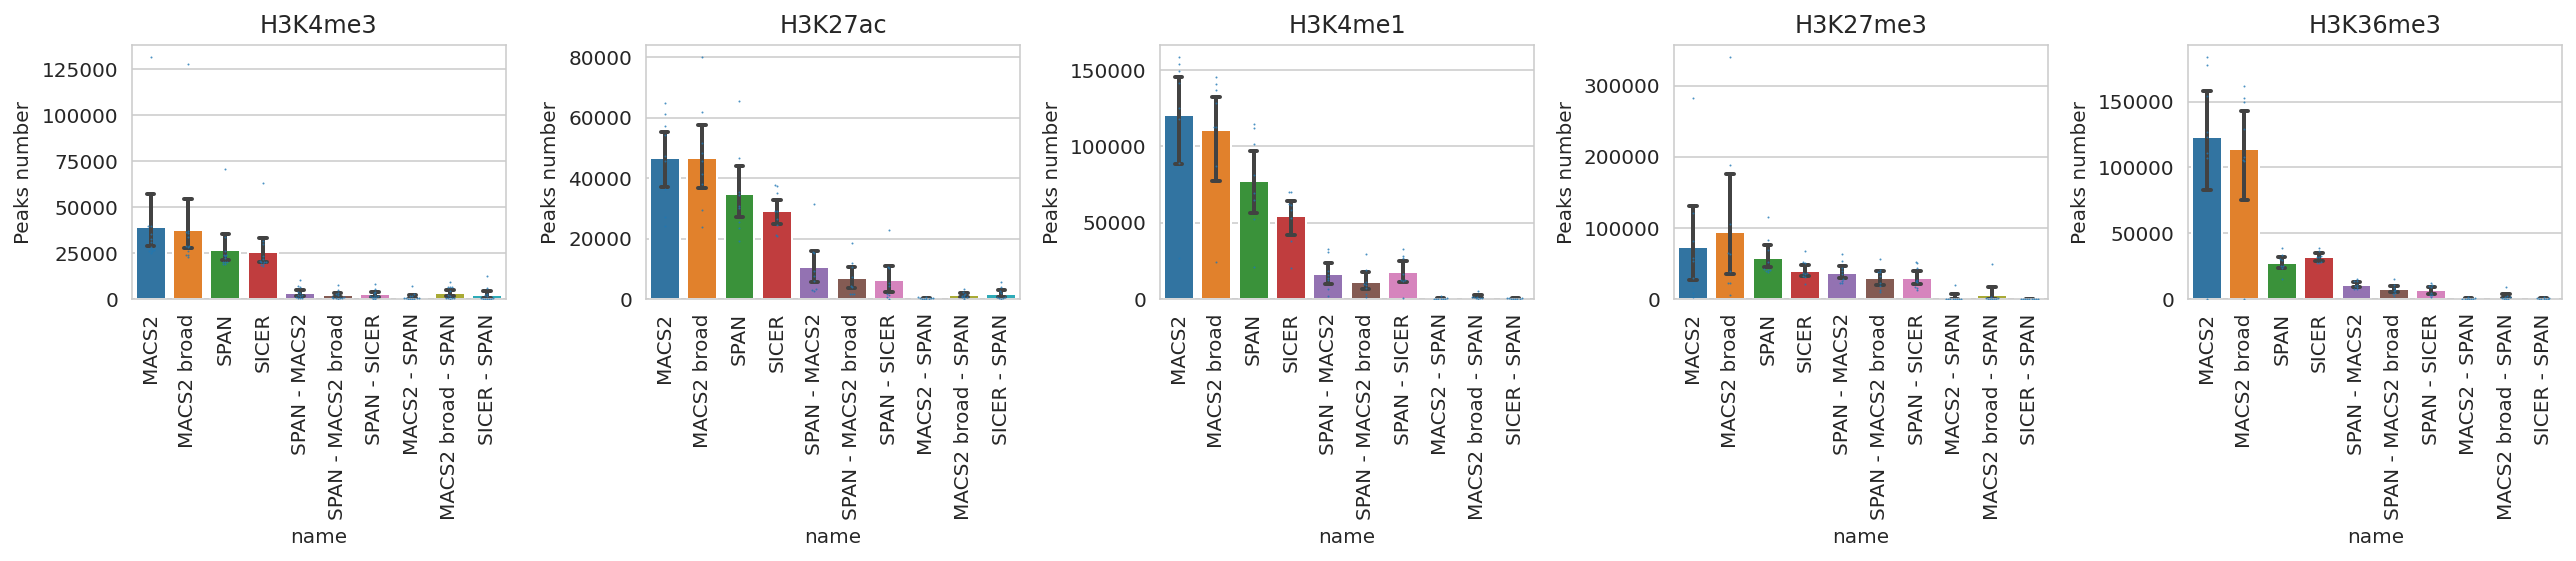

In [242]:
t = df_immune_peaks[['modification', 'cell', 'replicate', 'tool', 'peaks']].copy()
t.rename({'tool': 'name'}, axis=1, inplace=True)
t = pd.concat([t, df_immune_diff]).reset_index(drop=True)

plt.figure(figsize=(18, 4))
axs = [plt.subplot(1, 5, i + 1) for i in range(5)]

for i, m in enumerate(MODIFICATIONS):
    print(m)
    ax = axs[i]
    ax.title.set_text(m)
    sns.barplot(data=t[t['modification'] == m], x='name', y='peaks',
                capsize=.2, errwidth=2,
                order=['MACS2', 'MACS2 broad', 'SPAN', 'SICER',
                       'SPAN - MACS2', 'SPAN - MACS2 broad', 'SPAN - SICER',
                       'MACS2 - SPAN', 'MACS2 broad - SPAN', 'SICER - SPAN',
                       ],
                ax=ax)
    sns.swarmplot(data=t[t['modification'] == m], x='name', y='peaks',
                  dodge=True, size=1, alpha=0.8,
                  order=['MACS2', 'MACS2 broad', 'SPAN', 'SICER',
                         'SPAN - MACS2', 'SPAN - MACS2 broad', 'SPAN - SICER',
                         'MACS2 - SPAN', 'MACS2 broad - SPAN', 'SICER - SPAN',
                         ],
                  ax=ax)
    ax.xaxis.set_tick_params(rotation=90)
    ax.set_ylabel('Peaks number')
plt.tight_layout()
plt.show()

# Jaccard & Overlap

In [243]:
def compute_reps_overlap(df_peaks, modifications, cells):
    reps_overlap = pd.DataFrame(columns=['modification', 'cell', 'tool', 'rep1', 'rep2',
                                     'peaks1', 'peaks1_len', 'peaks2', 'peaks2_len',
                                     'peaks1_overlap', 'peaks2_overlap', 'peaks_overlap_len'], dtype=object)

    tf = tempfile.mktemp()

    tools = list(sorted(set(df_peaks['tool'])))
    for m, c in tqdm(product(modifications, cells)):
        print(m, c)
        tm = df_peaks[(df_peaks['modification'] == m) & (df_peaks['cell'] == c)]
        reps = list(sorted(set(tm['replicate'])))
        for tool in tools:
            for i in range(len(reps)):
                for j in range(i + 1, len(reps)):
                    rep1, rep2 = reps[i], reps[j]
                    t1 = tm[(tm['tool'] == tool) & (tm['replicate'] == rep1)]
                    t2 = tm[(tm['tool'] == tool) & (tm['replicate'] == rep2)]
                    if len(t1) == 0 or len(t2) == 0:
                        continue
                    file1 = sorted_file(t1['file'].values[0])
                    file2 = sorted_file(t2['file'].values[0])
                    peaks1 = t1['peaks'].values[0]
                    peaks1_len = int(bedl(file1).sum())
                    peaks2 = t2['peaks'].values[0]
                    peaks2_len = int(bedl(file2).sum())
                    !bedtools intersect -a {file1} -b {file2} -wa -u > {tf}
                    overlap1 = lines(tf)
                    !bedtools intersect -b {file1} -a {file2} -wa -u > {tf}
                    overlap2 = lines(tf)
                    !bedtools intersect -a {file1} -b {file2} -wo > {tf}
                    overlap_len = int(last_col(tf).sum())

                    reps_overlap.loc[len(reps_overlap)] = \
                        (m, c, tool, rep1, rep2, peaks1, peaks1_len, peaks2, peaks2_len,
                        overlap1, overlap2, overlap_len)
    reps_overlap['jaccard'] = [
        d(lo, l1 + l2 - lo)
        for l1, l2, lo in zip(reps_overlap['peaks1_len'], reps_overlap['peaks2_len'], reps_overlap['peaks_overlap_len'])
    ]                    
    return reps_overlap

## Jaccard ENCODE 

In [244]:
t = df_encode_peaks.loc[[(m, c, r) not in OUTLIERS 
                         for _, (m, c, r) in df_encode_peaks[['modification', 'cell', 'replicate']].iterrows()]]
# t = df_encode_peaks
df_encode_reps = compute_reps_overlap(t, MODIFICATIONS, GSE26320_CELLS)
df_encode_reps.sample(5)

0it [00:00, ?it/s]

H3K4me3 GM12878
H3K4me3 HMEC
H3K4me3 HSMM
H3K4me3 K562
H3K4me3 NHEK
H3K4me3 NHLF
H3K4me3 H1
H3K4me3 Huvec
H3K4me3 HepG2
H3K27ac GM12878
H3K27ac HMEC
H3K27ac HSMM
H3K27ac K562
H3K27ac NHEK
H3K27ac NHLF
H3K27ac H1
H3K27ac Huvec
H3K27ac HepG2
H3K4me1 GM12878
H3K4me1 HMEC
H3K4me1 HSMM
H3K4me1 K562
H3K4me1 NHEK
H3K4me1 NHLF
H3K4me1 H1
H3K4me1 Huvec
H3K4me1 HepG2
H3K27me3 GM12878
H3K27me3 HMEC
H3K27me3 HSMM
H3K27me3 K562
H3K27me3 NHEK
H3K27me3 NHLF
H3K27me3 H1
H3K27me3 Huvec
H3K27me3 HepG2
H3K36me3 GM12878
H3K36me3 HMEC
H3K36me3 HSMM
H3K36me3 K562
H3K36me3 NHEK
H3K36me3 NHLF
H3K36me3 H1
H3K36me3 Huvec
H3K36me3 HepG2


modification   cell   tool  rep1  rep2  peaks1  peaks1_len  peaks2  \
127     H3K27me3  HepG2   SPAN  rep1  rep2   18790    63402975   24590   
135     H3K36me3   HMEC   SPAN  rep1  rep2   15662   392641860   23302   
50       H3K27ac   NHLF  SICER  rep1  rep2   38037   146324163   37580   
140     H3K36me3   K562  MACS2  rep1  rep2   67417    26091123   12897   
151     H3K36me3     H1   SPAN  rep1  rep2   21672   174020347   17676   

     peaks2_len  peaks1_overlap  peaks2_overlap  peaks_overlap_len   jaccard  
127   540257433           17333            6961           60582801  0.111555  
135   360076702           12200           17644          307205360  0.689554  
50    120154020           29343           30362           92063159  0.527840  
140     5543136            8296            7937            2541578  0.087361  
151   178651044           15363           13701          136200397  0.629185

ENCODE


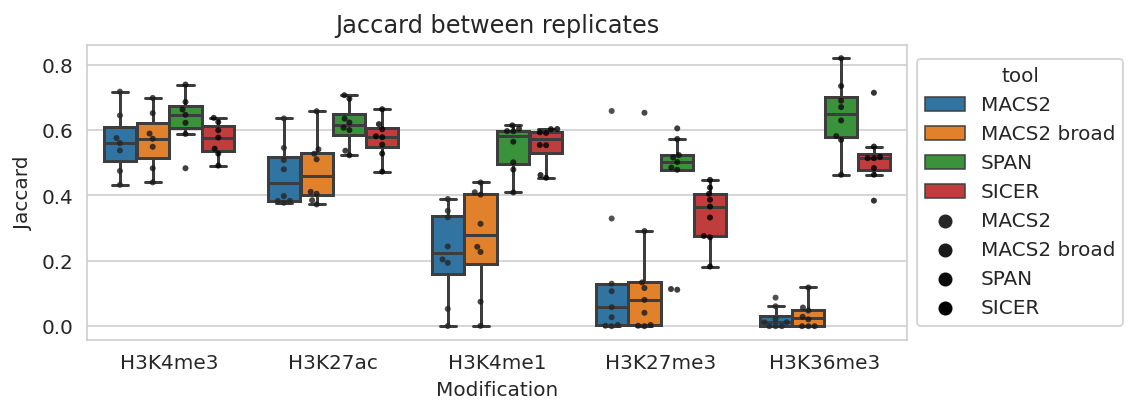

In [245]:
print('ENCODE')
plt.figure(figsize=(8, 3))
ax = plt.axes()
sns.boxplot(data=df_encode_reps, x='modification', hue='tool', y='jaccard',
            palette=TOOLS_PALETTE,
            hue_order=['MACS2', 'MACS2 broad', 'SPAN', 'SICER'],
            showfliers=False,
            ax=ax)
sns.swarmplot(data=df_encode_reps, x='modification', hue='tool', y='jaccard',
              dodge=True, size=3, palette='dark:black', alpha=0.8,
              hue_order=['MACS2', 'MACS2 broad', 'SPAN', 'SICER'],
              ax=ax)
ax.set_title('Jaccard between replicates')
ax.set_ylabel('Jaccard')
ax.set_xlabel('Modification')
sns.move_legend(ax, loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.show()

H3K4me3
H3K27ac
H3K4me1
H3K27me3
H3K36me3


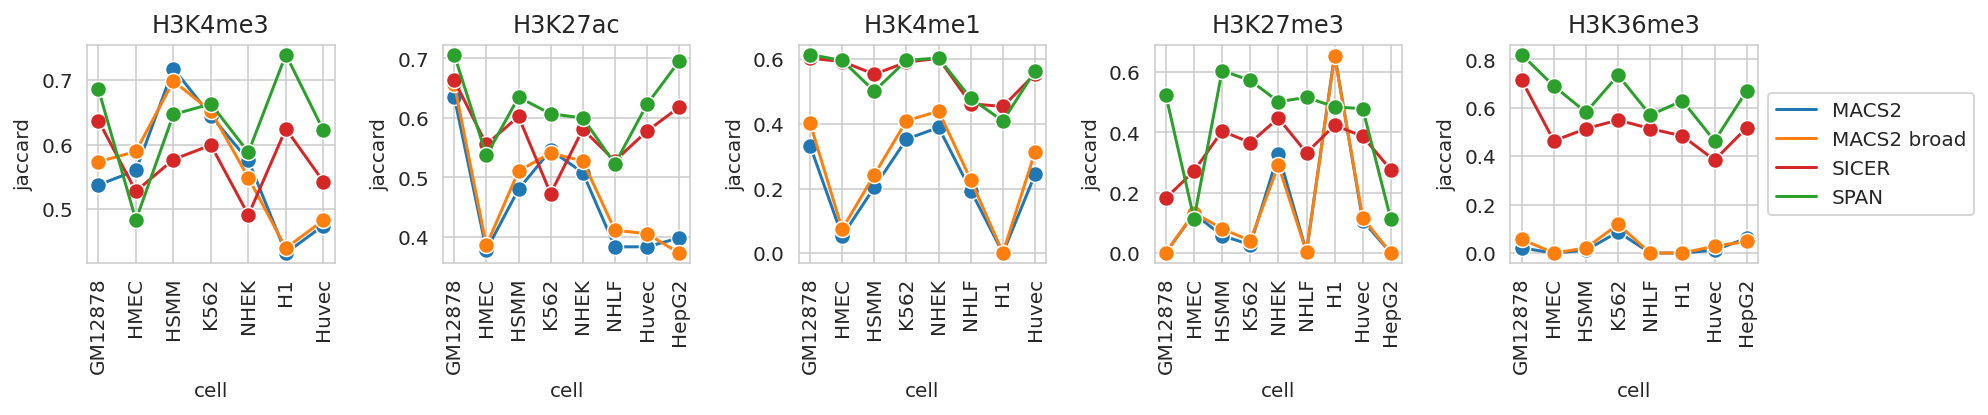

In [246]:
plt.figure(figsize=(14, 3))
axs = [plt.subplot(1, 5, i + 1) for i in range(5)]
for i, m in enumerate(MODIFICATIONS):
    print(m)
    ax = axs[i]
    g_results = sns.lineplot(data=df_encode_reps[df_encode_reps['modification'] == m],
                             x='cell', y='jaccard', hue='tool',
                             hue_order=['MACS2', 'MACS2 broad', 'SICER', 'SPAN'],
                             palette=TOOLS_PALETTE,
                             errorbar='se', marker='o', markersize=8,
                             ax=ax)
    g_results.axes.title.set_text(f'{m}')
    ax.set_title(m)
    if i != 4:
        ax.legend().set_visible(False)
    else:
        # Put a legend to the right of the current axis
        g_results.axes.legend(loc='center left', bbox_to_anchor=(1, 0.5))

    ax.xaxis.set_tick_params(rotation=90)

plt.tight_layout()
plt.show()

ENCODE


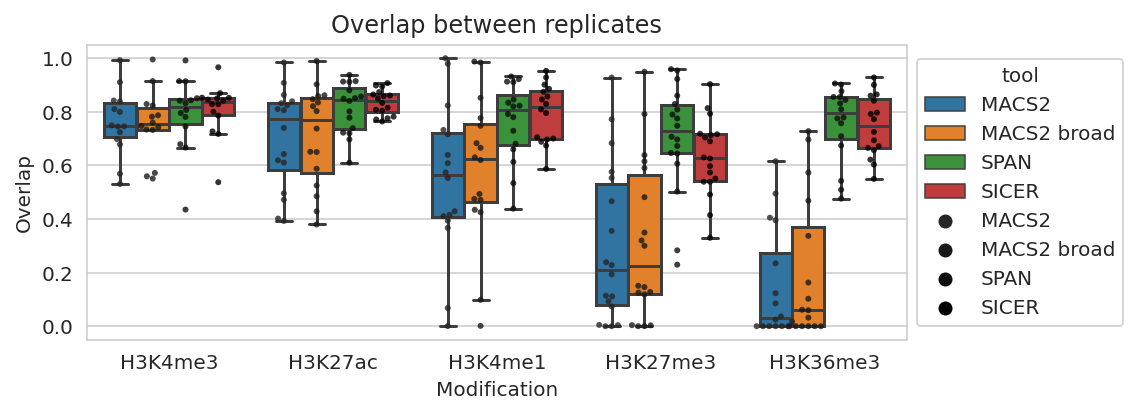

In [247]:
t = pd.concat([df_encode_reps[['modification', 'cell', 'tool']], 
               df_encode_reps[['modification', 'cell', 'tool']]]).reset_index(drop=True)
overlaps = [d(o, p) for o, p in zip(df_encode_reps['peaks1_overlap'], df_encode_reps['peaks1'])] + \
           [d(o, p) for o, p in zip(df_encode_reps['peaks2_overlap'], df_encode_reps['peaks2'])]
t['overlap'] = overlaps
print('ENCODE')
plt.figure(figsize=(8, 3))
ax = plt.axes()
sns.boxplot(data=t, x='modification', hue='tool', y='overlap',
            palette=TOOLS_PALETTE,
            hue_order=['MACS2', 'MACS2 broad', 'SPAN', 'SICER'],
            showfliers=False
            )
sns.swarmplot(data=t, x='modification', hue='tool', y='overlap',
              dodge=True, size=3, palette='dark:black', alpha=0.8,
              hue_order=['MACS2', 'MACS2 broad', 'SPAN', 'SICER'],
              ax=ax)

ax.set_title('Overlap between replicates')
ax.set_ylabel('Overlap')
ax.set_xlabel('Modification')
sns.move_legend(ax, loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.show()

ENCODE
H3K4me3
H3K27ac
H3K4me1
H3K27me3
H3K36me3


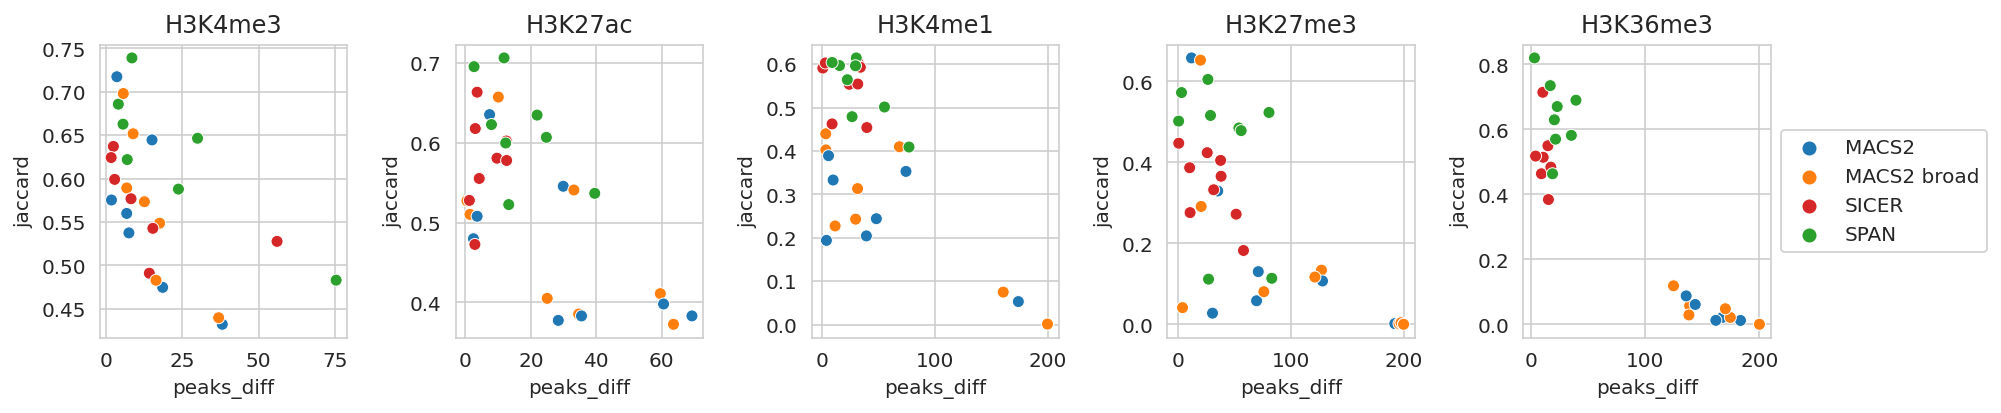

In [248]:
print('ENCODE')
df_encode_reps['peaks_diff'] = np.fabs((df_encode_reps['peaks1'] - df_encode_reps['peaks2']) /
                                       (df_encode_reps['peaks1'] + df_encode_reps['peaks2']) * 200)
plt.figure(figsize=(14, 3))
axs = [plt.subplot(1, 5, i + 1) for i in range(5)]
for i, m in enumerate(MODIFICATIONS):
    print(m)
    ax = axs[i]
    g_results = sns.scatterplot(data=df_encode_reps[df_encode_reps['modification'] == m],
                             x='peaks_diff', y='jaccard', hue='tool',
                             hue_order=['MACS2', 'MACS2 broad', 'SICER', 'SPAN'],
                             palette=TOOLS_PALETTE,
                             ax=ax)
    g_results.axes.title.set_text(f'{m}')
    ax.set_title(m)
    if i != 4:
        ax.legend().set_visible(False)
    else:
        # Put a legend to the right of the current axis
        g_results.axes.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.tight_layout()
plt.show()

ENCODE


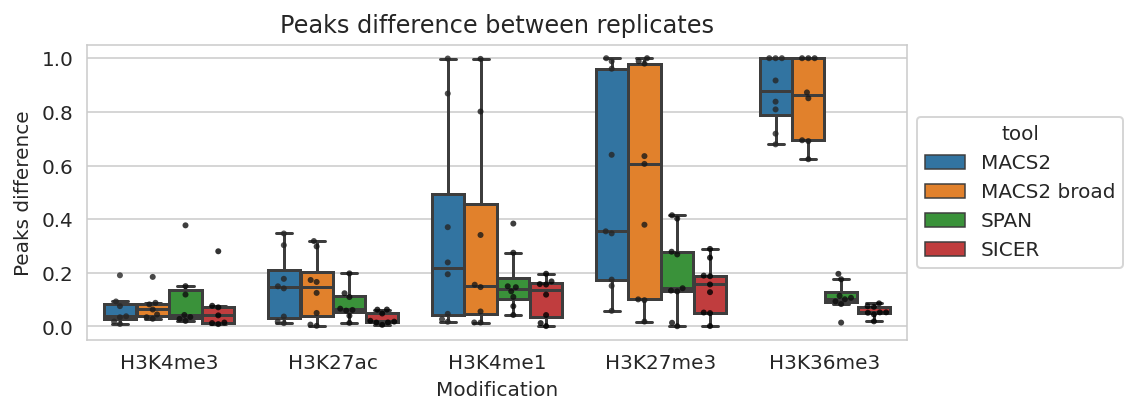

In [483]:
print('ENCODE')
df_encode_reps['reps_peaks_diff'] = np.fabs((df_encode_reps['peaks1'] - df_encode_reps['peaks2']) /
                                            (df_encode_reps['peaks1'] + df_encode_reps['peaks2']))

plt.figure(figsize=(8, 3))
ax = plt.axes()
sns.boxplot(data=df_encode_reps, x='modification', hue='tool', y='reps_peaks_diff',
            palette=TOOLS_PALETTE,
            hue_order=['MACS2', 'MACS2 broad', 'SPAN', 'SICER'],
            showfliers=False,
            ax=ax)
sns.swarmplot(data=df_encode_reps, x='modification', hue='tool', y='reps_peaks_diff',
              dodge=True, size=3, palette='dark:black', alpha=0.8,
              hue_order=['MACS2', 'MACS2 broad', 'SPAN', 'SICER'], legend=False,
              ax=ax)
ax.set_title('Peaks difference between replicates')
ax.set_ylabel('Peaks difference')
ax.set_xlabel('Modification')
sns.move_legend(ax, loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.show()

In [249]:
rows = []
for _, (modification, tool, jaccard, p1, p2, l1, l2) in df_encode_reps[
    ['modification', 'tool', 'jaccard', 'peaks1', 'peaks2', 'peaks1_len', 'peaks2_len']].iterrows():
    rows.append((modification, tool, jaccard, d(l1, p1)))
    rows.append((modification, tool, jaccard, d(l2, p2)))
df_jaccard_avg_len_encode = pd.DataFrame(rows, columns=['modification', 'tool', 'jaccard', 'average_len'])
del rows

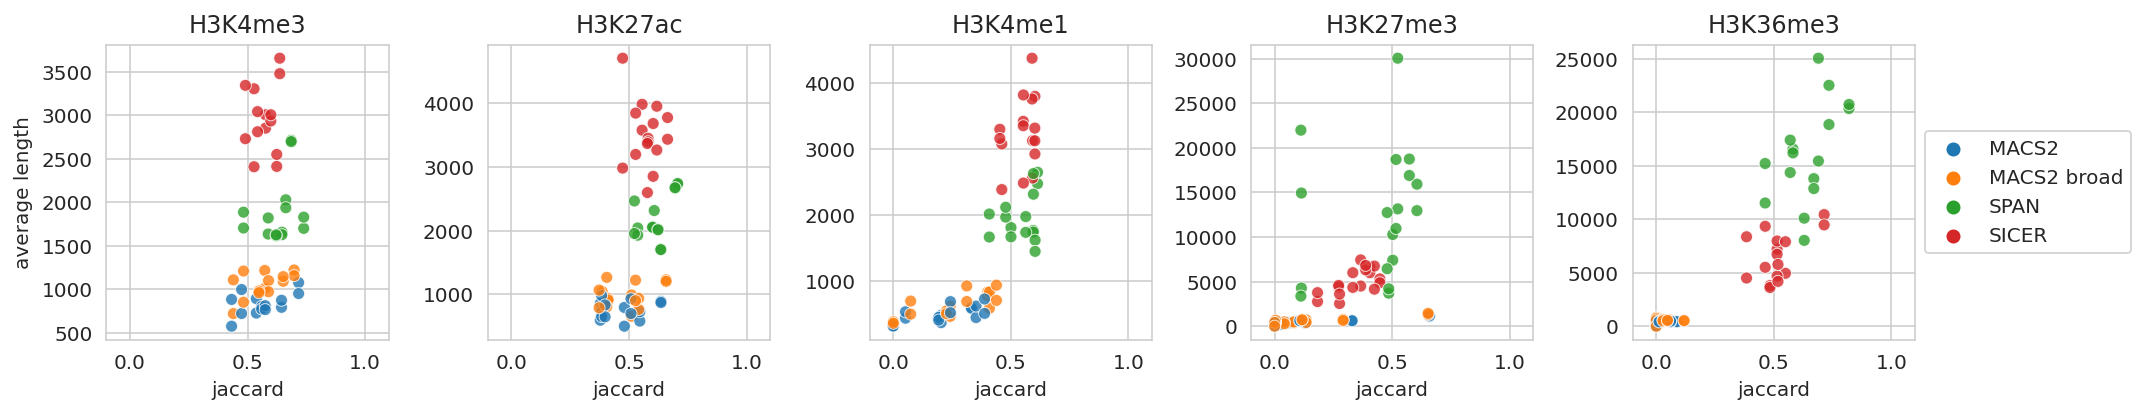

In [250]:
plt.figure(figsize=(15, 3))
axs = [plt.subplot(1, 5, i + 1) for i in range(5)]
for i, m in enumerate(MODIFICATIONS):
    ax = axs[i]
    sns.scatterplot(
        df_jaccard_avg_len_encode[df_jaccard_avg_len_encode['modification'] == m],
        palette=TOOLS_PALETTE,
        hue_order=TOOLS,
        x='jaccard', y='average_len', hue='tool', alpha=0.8,
        ax = ax,
        # fill=True
    )
    ax.set_title(m)
    ax.set_xlim(-0.1, 1.1)
    ax.set_title(m)
    if i > 0:
        ax.set_ylabel(None)
    else:
        ax.set_ylabel('average length')
    if i < len(axs) - 1:
        ax.legend().set_visible(False)
    else:
        # Put a legend to the right of the current axis
        ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.show()

H3K27ac


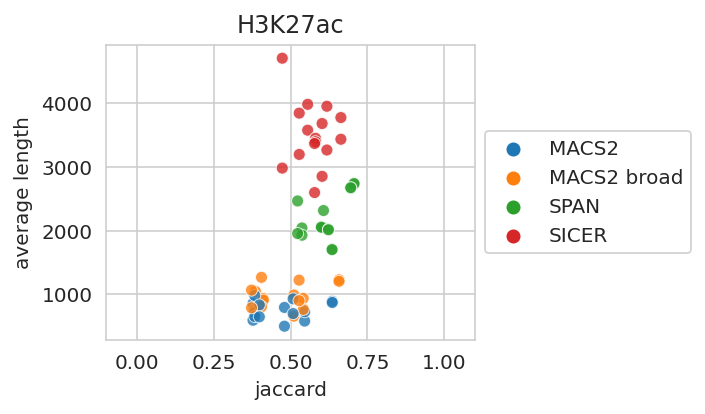

H3K4me1


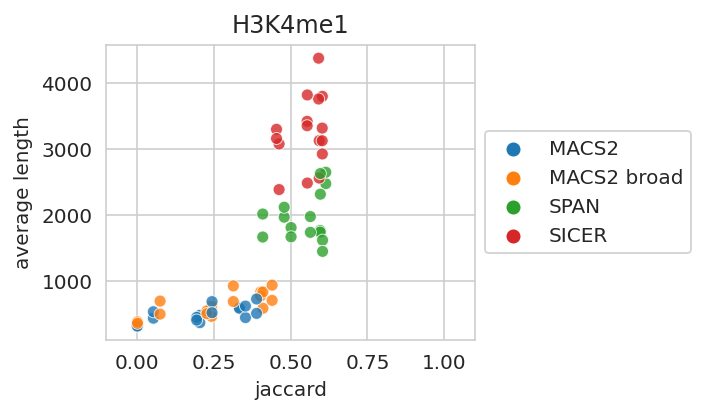

In [251]:
for m in ['H3K27ac', 'H3K4me1']:
    print(m)
    plt.figure(figsize=(5, 3))
    ax = plt.axes()
    sns.scatterplot(
        df_jaccard_avg_len_encode[df_jaccard_avg_len_encode['modification'] == m],
        palette=TOOLS_PALETTE,
        hue_order=TOOLS,
        x='jaccard', y='average_len', hue='tool', alpha=0.8,
        ax = ax,
        # fill=True
    )
    ax.set_title(m)
    ax.set_xlim(-0.1, 1.1)
    ax.set_title(m)
    ax.set_ylabel('average length')
    # Put a legend to the right of the current axis
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.tight_layout()
    plt.show()

## Jaccard Roadmap

In [252]:
t = df_immune_peaks.loc[[(m, c, r) not in OUTLIERS 
                         for _, (m, c, r) in df_immune_peaks[['modification', 'cell', 'replicate']].iterrows()]]
# t = df_immune_peaks
df_immune_reps = compute_reps_overlap(t, MODIFICATIONS, IMMUNE_CELLS)
df_immune_reps.sample(5)

0it [00:00, ?it/s]

H3K4me3 CD4ABT
H3K4me3 TCellBB
H3K4me3 BCell
H3K4me3 TCell
H3K4me3 Monocyte
H3K4me3 PBMC
H3K4me3 NK
H3K4me3 CD34
H3K4me3 CD4
H3K27ac CD4ABT
H3K27ac TCellBB
H3K27ac BCell
H3K27ac TCell
H3K27ac Monocyte
H3K27ac PBMC
H3K27ac NK
H3K27ac CD34
H3K27ac CD4
H3K4me1 CD4ABT
H3K4me1 TCellBB
H3K4me1 BCell
H3K4me1 TCell
H3K4me1 Monocyte
H3K4me1 PBMC
H3K4me1 NK
H3K4me1 CD34
H3K4me1 CD4
H3K27me3 CD4ABT
H3K27me3 TCellBB
H3K27me3 BCell
H3K27me3 TCell
H3K27me3 Monocyte
H3K27me3 PBMC
H3K27me3 NK
H3K27me3 CD34
H3K27me3 CD4
H3K36me3 CD4ABT
H3K36me3 TCellBB
H3K36me3 BCell
H3K36me3 TCell
H3K36me3 Monocyte
H3K36me3 PBMC
H3K36me3 NK
H3K36me3 CD34
H3K36me3 CD4


modification     cell         tool  rep1  rep2  peaks1  peaks1_len  peaks2  \
24      H3K4me1      CD4        MACS2        rep1  117825   127357230   89320   
15      H3K27ac     CD34         SPAN        rep2   65548   125209219   34514   
12      H3K27ac     CD34        MACS2        rep2   64970    49974826   27004   
5       H3K4me3  TCellBB  MACS2 broad  rep1  rep2   35951    30695557   36439   
28     H3K27me3     CD34        MACS2        rep2   53084    29118068   81061   

    peaks2_len  peaks1_overlap  peaks2_overlap  peaks_overlap_len   jaccard  
24    75329904           63532           83837           69474989  0.521536  
15    28330714           19445           26292           26165232  0.205419  
12    17488610           19041           24400           16233325  0.316871  
5     38651696           27719           24228           25760763  0.591026  
28    70038383           44248           25802           24998814  0.337104

Immune


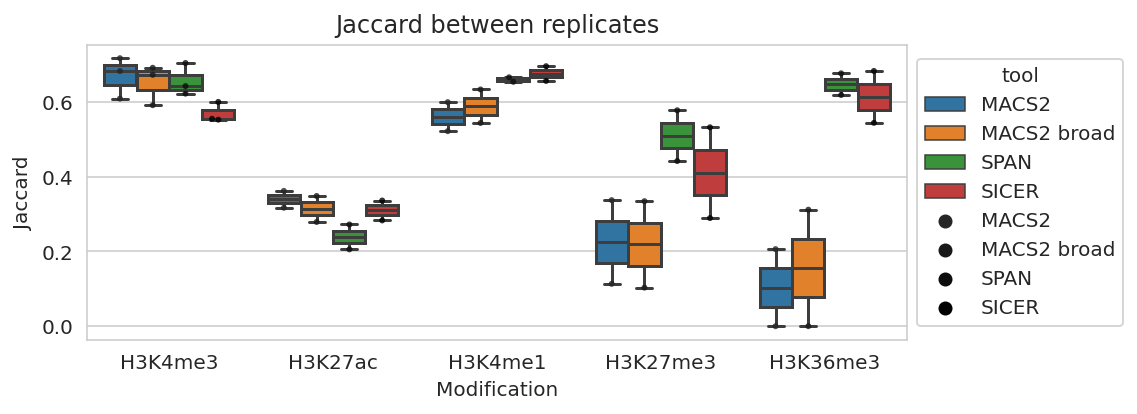

In [253]:
print('Immune')
plt.figure(figsize=(8, 3))
ax = plt.axes()
sns.boxplot(data=df_immune_reps, x='modification', hue='tool', y='jaccard',
            palette=TOOLS_PALETTE,
            hue_order=['MACS2', 'MACS2 broad', 'SPAN', 'SICER'],
            ax=ax)
sns.swarmplot(data=df_immune_reps, x='modification', hue='tool', y='jaccard',
              dodge=True, size=3, palette='dark:black', alpha=0.8,
              hue_order=['MACS2', 'MACS2 broad', 'SPAN', 'SICER'],
              ax=ax)
ax.set_title('Jaccard between replicates')
ax.set_ylabel('Jaccard')
ax.set_xlabel('Modification')
sns.move_legend(ax, loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.show()

H3K4me3
H3K27ac
H3K4me1
H3K27me3
H3K36me3


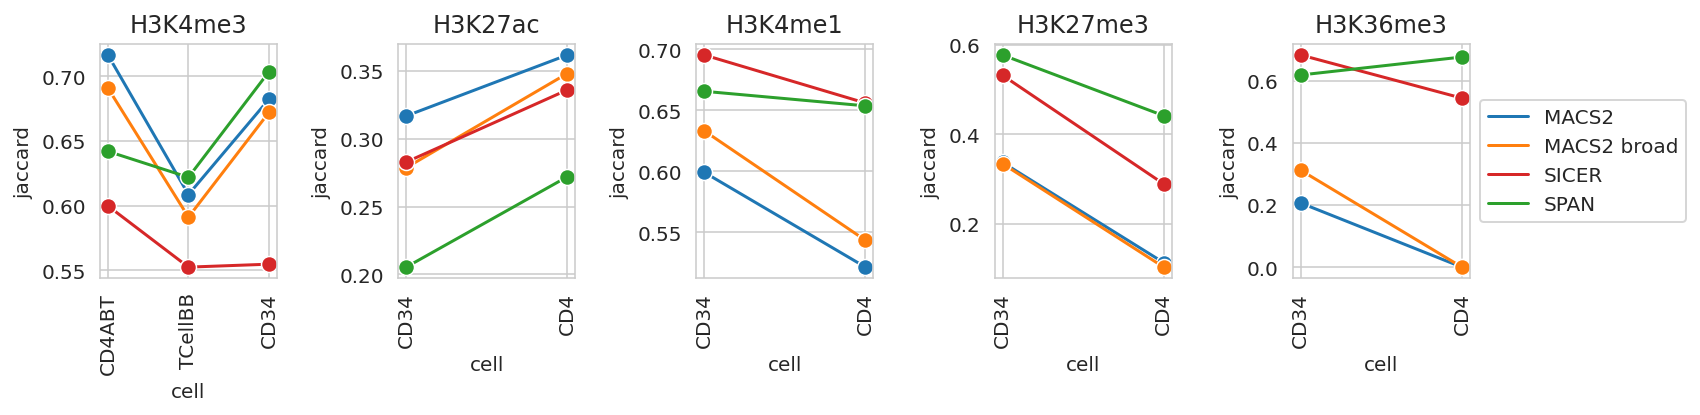

In [254]:
plt.figure(figsize=(12, 3))
axs = [plt.subplot(1, 5, i + 1) for i in range(5)]
for i, m in enumerate(MODIFICATIONS):
    print(m)
    ax = axs[i]
    g_results = sns.lineplot(data=df_immune_reps[df_immune_reps['modification'] == m],
                             x='cell', y='jaccard', hue='tool',
                             hue_order=['MACS2', 'MACS2 broad', 'SICER', 'SPAN'],
                             palette=TOOLS_PALETTE,
                             errorbar='se', marker='o', markersize=8,
                             ax=ax)
    g_results.axes.title.set_text(f'{m}')
    ax.set_title(m)
    if i != 4:
        ax.legend().set_visible(False)
    else:
        # Put a legend to the right of the current axis
        g_results.axes.legend(loc='center left', bbox_to_anchor=(1, 0.5))

    ax.xaxis.set_tick_params(rotation=90)

plt.tight_layout()
plt.show()

Immune


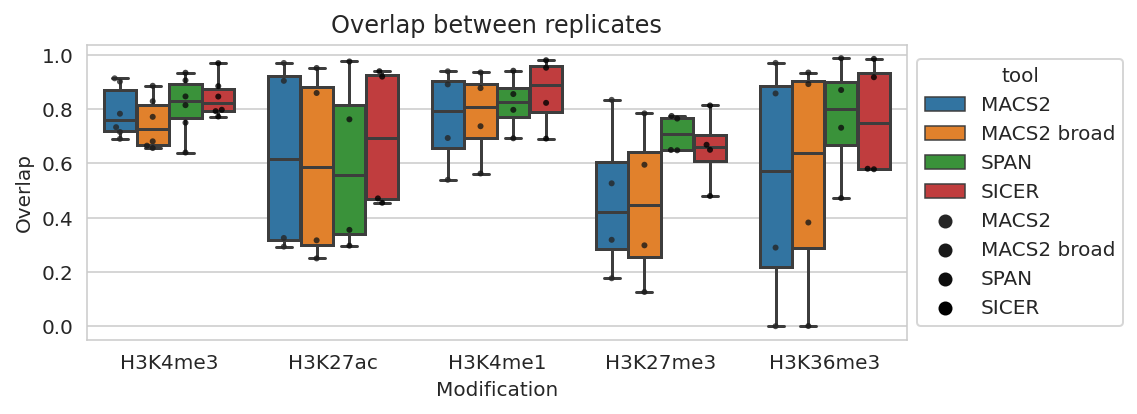

In [255]:
print('Immune')
t = pd.concat([df_immune_reps[['modification', 'cell', 'tool']],
               df_immune_reps[['modification', 'cell', 'tool']]]).reset_index(drop=True)
overlaps = [d(o, p) for o, p in zip(df_immune_reps['peaks1_overlap'], df_immune_reps['peaks1'])] + \
           [d(o, p) for o, p in zip(df_immune_reps['peaks2_overlap'], df_immune_reps['peaks2'])]
t['overlap'] = overlaps
plt.figure(figsize=(8, 3))
ax = plt.axes()
sns.boxplot(data=t, x='modification', hue='tool', y='overlap',
            palette=TOOLS_PALETTE,
            hue_order=['MACS2', 'MACS2 broad', 'SPAN', 'SICER'],
            ax=ax)
sns.swarmplot(data=t, x='modification', hue='tool', y='overlap',
              dodge=True, size=3, palette='dark:black', alpha=0.8,
              hue_order=['MACS2', 'MACS2 broad', 'SPAN', 'SICER'],
              ax=ax)

ax.set_title('Overlap between replicates')
ax.set_ylabel('Overlap')
ax.set_xlabel('Modification')
sns.move_legend(ax, loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.show()

H3K4me3
H3K27ac
H3K4me1
H3K27me3
H3K36me3


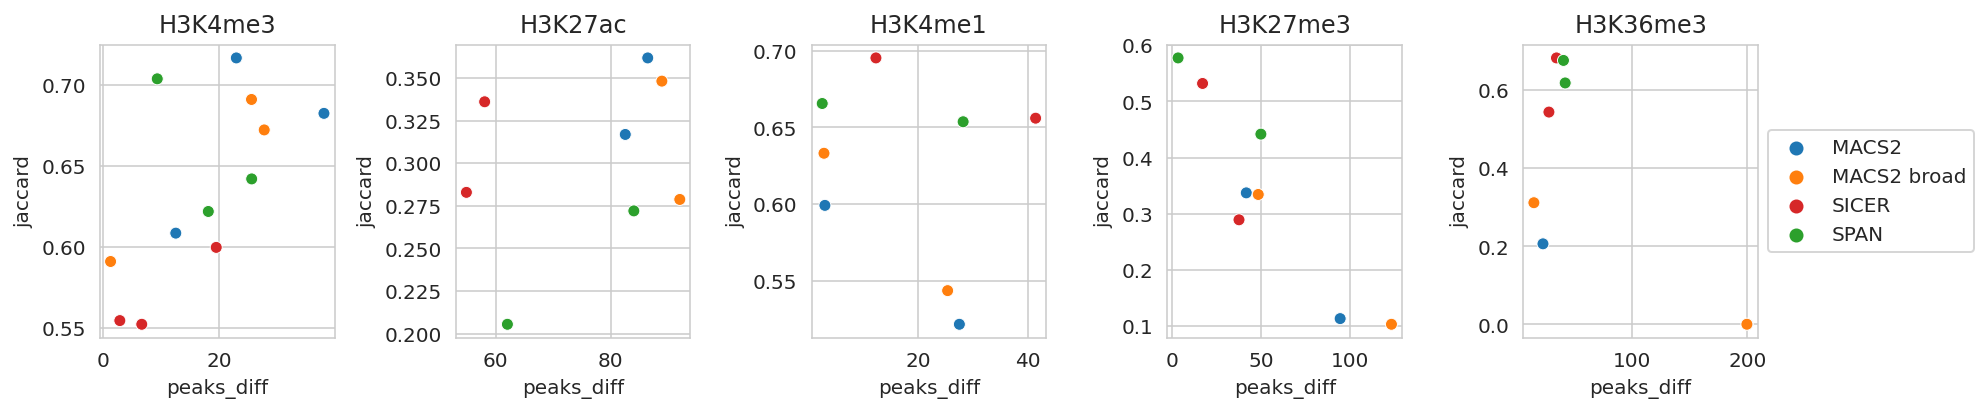

In [256]:
df_immune_reps['peaks_diff'] = np.fabs((df_immune_reps['peaks1'] - df_immune_reps['peaks2']) / 
                                       (df_immune_reps['peaks1'] + df_immune_reps['peaks2']) * 200)

plt.figure(figsize=(14, 3))
axs = [plt.subplot(1, 5, i + 1) for i in range(5)]
for i, m in enumerate(MODIFICATIONS):
    print(m)
    ax = axs[i]
    g_results = sns.scatterplot(data=df_immune_reps[df_immune_reps['modification'] == m],
                                x='peaks_diff', y='jaccard', hue='tool',
                                hue_order=['MACS2', 'MACS2 broad', 'SICER', 'SPAN'],
                                palette=TOOLS_PALETTE,
                                ax=ax)
    g_results.axes.title.set_text(f'{m}')
    ax.set_title(m)
    if i != 4:
        ax.legend().set_visible(False)
    else:
        # Put a legend to the right of the current axis
        g_results.axes.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.tight_layout()
plt.show()

Immune


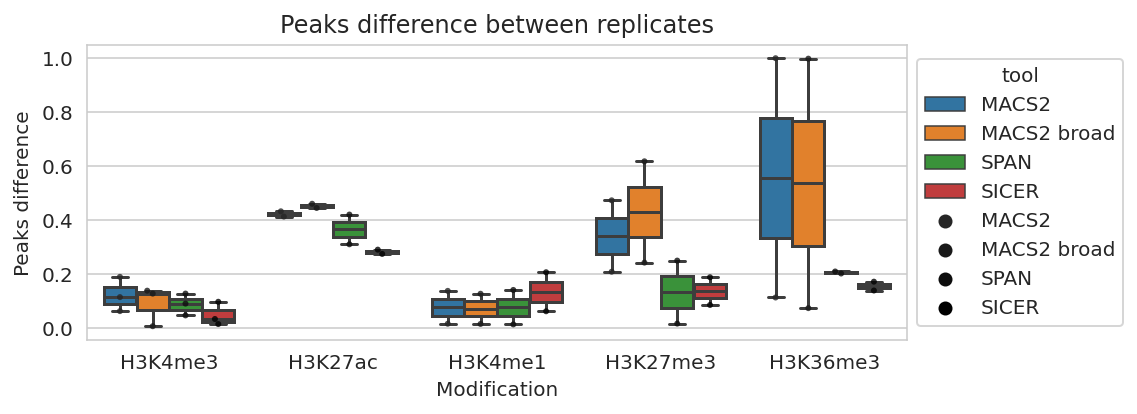

In [280]:
print('Immune')
df_immune_reps['peaks_diff'] = np.fabs((df_immune_reps['peaks1'] - df_immune_reps['peaks2']) /
                                       (df_immune_reps['peaks1'] + df_immune_reps['peaks2']))

plt.figure(figsize=(8, 3))
ax = plt.axes()
sns.boxplot(data=df_immune_reps, x='modification', hue='tool', y='peaks_diff',
            palette=TOOLS_PALETTE,
            hue_order=['MACS2', 'MACS2 broad', 'SPAN', 'SICER'],
            showfliers=False,
            ax=ax)
sns.swarmplot(data=df_immune_reps, x='modification', hue='tool', y='peaks_diff',
              dodge=True, size=3, palette='dark:black', alpha=0.8,
              hue_order=['MACS2', 'MACS2 broad', 'SPAN', 'SICER'],
              ax=ax)
ax.set_title('Peaks difference between replicates')
ax.set_ylabel('Peaks difference')
ax.set_xlabel('Modification')
sns.move_legend(ax, loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.show()

In [257]:
rows = []
for _, (modification, tool, jaccard, p1, p2, l1, l2) in df_immune_reps[
    ['modification', 'tool', 'jaccard', 'peaks1', 'peaks2', 'peaks1_len', 'peaks2_len']].iterrows():
    rows.append((modification, tool, jaccard, d(l1, p1)))
    rows.append((modification, tool, jaccard, d(l2, p2)))
df_jaccard_avg_len_immune = pd.DataFrame(rows, columns=['modification', 'tool', 'jaccard', 'average_len'])
del rows

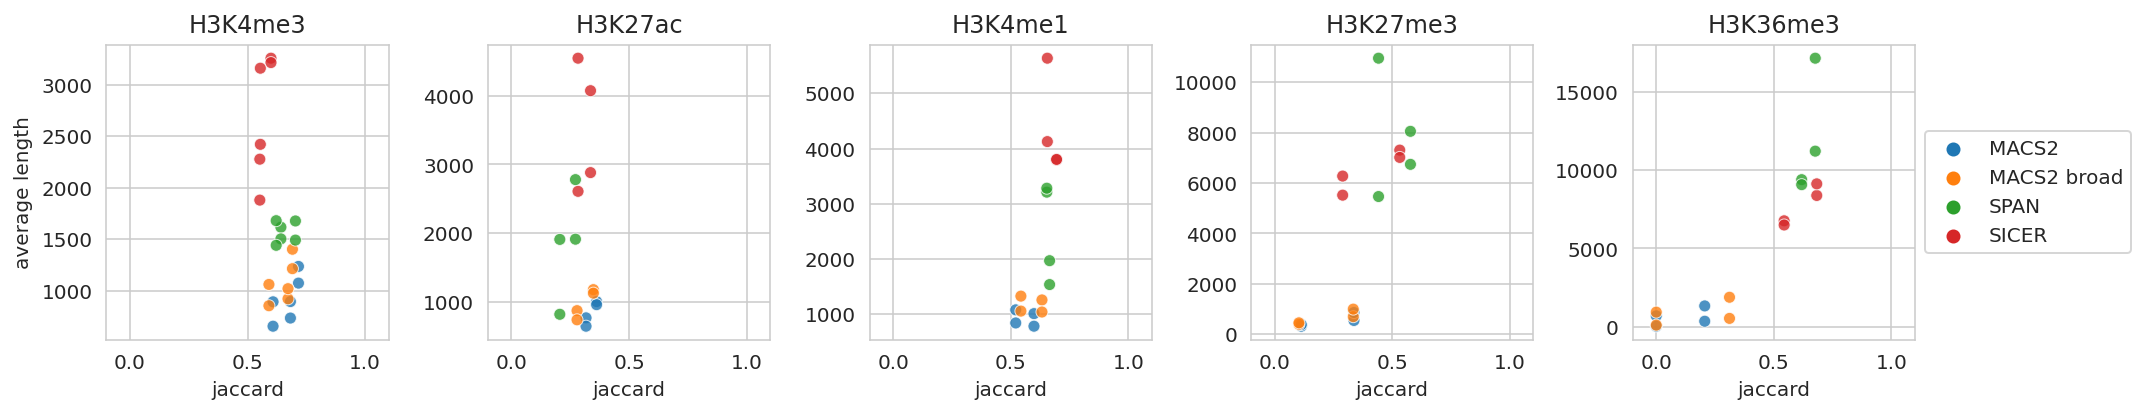

In [258]:
plt.figure(figsize=(15, 3))
axs = [plt.subplot(1, 5, i + 1) for i in range(5)]
for i, m in enumerate(MODIFICATIONS):
    ax = axs[i]
    sns.scatterplot(
        df_jaccard_avg_len_immune[df_jaccard_avg_len_immune['modification'] == m],
        palette=TOOLS_PALETTE,
        hue_order=TOOLS,
        x='jaccard', y='average_len', hue='tool', alpha=0.8,
        ax = ax,
    )
    ax.set_title(m)
    ax.set_xlim(-0.1, 1.1)
    ax.set_title(m)
    if i > 0:
        ax.set_ylabel(None)
    else:
        ax.set_ylabel('average length')
    if i < len(axs) - 1:
        ax.legend().set_visible(False)
    else:
    #     Put a legend to the right of the current axis
        ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.show()

In [ ]:
STOP

# IDR

In [ ]:
def compute_reps_idr(df_peaks, modifications, cells):
    reps_idr = pd.DataFrame(columns=['modification', 'cell', 'tool', 'rep1', 'rep2', 'peaks1', 'peaks2', 
                                     'idr_loaded_peaks1', 'idr_loaded_peaks2', 'idr_peaks', 'idr_loaded_peaks', 'idr_percentage'
                                     ], dtype=object)

    tf = tempfile.mktemp()
    tf1 = tempfile.mktemp()
    tf2 = tempfile.mktemp()

    tools = list(sorted(set(df_peaks['tool'])))
    for m, c in tqdm(list(product(modifications, cells))):
        print(m, c)
        tm = df_peaks[(df_peaks['modification'] == m) & (df_peaks['cell'] == c)]
        reps = list(sorted(set(tm['replicate'])))
        for tool in tools:
            for i in range(len(reps)):
                for j in range(i + 1, len(reps)):
                    rep1, rep2 = reps[i], reps[j]
                    t1 = tm[(tm['tool'] == tool) & (tm['replicate'] == rep1)]
                    t2 = tm[(tm['tool'] == tool) & (tm['replicate'] == rep2)]
                    if len(t1) == 0 or len(t2) == 0:
                        continue
                    try:
                        file1 = t1['file'].values[0]
                        file2 = t2['file'].values[0]
                        print(tool, file1, file2)
                        peaks1 = t1['peaks'].values[0]
                        peaks2 = t2['peaks'].values[0]
                        # Process SICER peaks, add missing 8th column, as -log10 qvalue
                        if tool == 'SICER':
                            sf1 = pd.read_csv(file1, sep='\t', header=None)
                            sf1[8] = -np.log10(sf1[7])
                            sf1.to_csv(tf1, sep='\t', index=None, header=False)
                            file1 = tf1
                            sf2 = pd.read_csv(file2, sep='\t', header=None)
                            sf2[8] = -np.log10(sf2[7])
                            sf2.to_csv(tf2, sep='\t', index=None, header=False)
                            file2 = tf2
                        ! idr --input-file-type bed --rank 8 --samples {file1} {file2} 2>&1 | tee {tf}
                        with open(tf) as f:
                            idr_out = f.read()
                        # print('IDR OUT', tf, idr_out)
                        lp1, lp2 = re.findall('Number of reported peaks - (\\d+)/(\\d+)', idr_out)[0]
                        lp1, lp2 = int(lp1), int(lp2)
                        ip, ilp, iperc = re.findall('Number of peaks passing IDR cutoff of 0.05 - (\\d+)/(\\d+) \\(([\\d\\.]+)', idr_out)[0]
                        ip, ilp, iperc = int(ip), int(ilp), float(iperc)
                        print(m, c, tool, rep1, rep2, peaks1, peaks2, lp1, lp2, ip, ilp, iperc)
                        reps_idr.loc[len(reps_idr)] = \
                            (m, c, tool, rep1, rep2, peaks1, peaks2, lp1, lp2, ip, ilp, iperc)
                    except Exception as e:
                        # raise e
                        # print(e)
                        pass  # Ignore errors for now
    return reps_idr

## IDR ENCODE

In [ ]:
# t = df_encode_peaks.loc[[(m, c, r) not in OUTLIERS for _, (m, c, r) in df_encode_peaks[['modification', 'cell', 'replicate']].iterrows()]]
t = df_encode_peaks
df_encode_idr_reps = compute_reps_idr(t, MODIFICATIONS, GSE26320_CELLS)
df_encode_idr_reps.sample(5)

In [ ]:
print('ENCODE')
plt.figure(figsize=(8, 3))
g_result = sns.boxplot(data=df_encode_idr_reps, x='modification', hue='tool', y='idr_percentage',
                       palette=TOOLS_PALETTE,
                       hue_order=['MACS2', 'MACS2 broad', 'SPAN', 'SICER'],
                       )
ax = g_result.axes
ax.set_title('IDR between replicates')
ax.set_ylabel('IDR %')
ax.set_xlabel('Modification')
sns.move_legend(ax, loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.show()

In [ ]:
plt.figure(figsize=(8, 3))
g_result = sns.boxplot(data=df_encode_idr_reps, x='modification', hue='tool', y='idr_peaks',
                       palette=TOOLS_PALETTE,
                       hue_order=['MACS2', 'MACS2 broad', 'SPAN', 'SICER'],
                       )
ax = g_result.axes
ax.set_title('IDR between replicates')
ax.set_ylabel('IDR peaks')
ax.set_xlabel('Modification')
sns.move_legend(ax, loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.show()

In [ ]:
plt.figure(figsize=(8, 3))
g_result = sns.boxplot(data=df_encode_idr_reps, x='modification', hue='tool', y='idr_loaded_peaks',
                       palette=TOOLS_PALETTE,
                       hue_order=['MACS2', 'MACS2 broad', 'SPAN', 'SICER'],
                       )
ax = g_result.axes
ax.set_title('IDR between replicates')
ax.set_ylabel('IDR loaded peaks')
ax.set_xlabel('Modification')
sns.move_legend(ax, loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.show()

In [ ]:
for m in MODIFICATIONS:
    plt.figure(figsize=(6, 2))
    g_result = sns.boxplot(data=df_encode_idr_reps[df_encode_idr_reps['modification'] == m], 
                           x='idr_peaks', y = 'tool',
                           palette=TOOLS_PALETTE,
                           order=['MACS2', 'MACS2 broad', 'SPAN', 'SICER'],
                           )
    ax = g_result.axes
    ax.set_title(f'IDR between {m} replicates')
    ax.set_ylabel('Tool')
    ax.set_xlabel('IDR peaks')
    plt.tight_layout()
    plt.show()

In [ ]:
plt.figure(figsize=(10, 2))
axs = [plt.subplot(1, 5, i + 1) for i in range(5)]
for i, m in enumerate(MODIFICATIONS):
    ax = axs[i]
    t = df_encode_idr_reps[df_encode_idr_reps['modification'] == m]
    g_results = sns.scatterplot(data=t,
                                x='idr_peaks', y='idr_percentage',
                                hue='tool',
                                palette=TOOLS_PALETTE,
                                alpha=0.8,
                                ax=ax,
                                )
    for x, y, cell in zip(t['idr_peaks'], t['idr_percentage'], t['cell']):
        ax.text(x, y, cell, fontsize = 4)
    ax.title.set_text(m)
    if i != 0:
        ax.set_ylabel(None)
    if i != 4:
        ax.legend().set_visible(False)
    else:
        # Put a legend to the right of the current axis
        g_results.axes.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.tight_layout()
plt.show()

## IDR Roadmap

In [ ]:
# t = df_immune_peaks.loc[[(m, c, r) not in OUTLIERS for _, (m, c, r) in df_immune_peaks[['modification', 'cell', 'replicate']].iterrows()]]
t = df_immune_peaks
df_immune_idr_reps = compute_reps_idr(t, MODIFICATIONS, IMMUNE_CELLS)
df_immune_idr_reps.sample(5)

In [ ]:
print('Immune')
plt.figure(figsize=(8, 3))
g_result = sns.boxplot(data=df_immune_idr_reps, x='modification', hue='tool', y='idr_percentage',
                       palette=TOOLS_PALETTE,
                       hue_order=['MACS2', 'MACS2 broad', 'SPAN', 'SICER'],
                       )
ax = g_result.axes
ax.set_title('IDR between replicates')
ax.set_ylabel('IDR %')
ax.set_xlabel('Modification')
sns.move_legend(ax, loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.show()

In [ ]:
print('Immune')
plt.figure(figsize=(8, 3))
g_result = sns.boxplot(data=df_immune_idr_reps, x='modification', hue='tool', y='idr_peaks',
                       palette=TOOLS_PALETTE,
                       hue_order=['MACS2', 'MACS2 broad', 'SPAN', 'SICER'],
                       )
ax = g_result.axes
ax.set_title('IDR between replicates')
ax.set_ylabel('IDR peaks')
ax.set_xlabel('Modification')
sns.move_legend(ax, loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.show()

In [ ]:
plt.figure(figsize=(8, 3))
g_result = sns.boxplot(data=df_immune_idr_reps, x='modification', hue='tool', y='idr_loaded_peaks',
                       palette=TOOLS_PALETTE,
                       hue_order=['MACS2', 'MACS2 broad', 'SPAN', 'SICER'],
                       )
ax = g_result.axes
ax.set_title('IDR between replicates')
ax.set_ylabel('IDR loaded peaks')
ax.set_xlabel('Modification')
sns.move_legend(ax, loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.show()

In [ ]:
for m in MODIFICATIONS:
    plt.figure(figsize=(6, 2))
    g_result = sns.boxplot(data=df_immune_idr_reps[df_immune_idr_reps['modification'] == m],
                           x='idr_peaks', y = 'tool',
                           palette=TOOLS_PALETTE,
                           order=['MACS2', 'MACS2 broad', 'SPAN', 'SICER'],
                           )
    ax = g_result.axes
    ax.set_title(f'IDR between {m} replicates')
    ax.set_ylabel('Tool')
    ax.set_xlabel('IDR peaks')
    plt.tight_layout()
    plt.show()

In [ ]:
plt.figure(figsize=(10, 2))
axs = [plt.subplot(1, 5, i + 1) for i in range(5)]
for i, m in enumerate(MODIFICATIONS):
    ax = axs[i]
    t = df_immune_idr_reps[df_immune_idr_reps['modification'] == m]
    g_results = sns.scatterplot(data=t,
                    x='idr_peaks', y='idr_percentage',
                    hue='tool',
                    palette=TOOLS_PALETTE,
                    alpha=0.8,
                    ax=ax,
                    )
    for x, y, cell in zip(t['idr_peaks'], t['idr_percentage'], t['cell']):
        ax.text(x, y, cell, fontsize = 4)    
    ax.title.set_text(m)
    if i != 0:
        ax.set_ylabel(None)
    if i != 4:
        ax.legend().set_visible(False)
    else:
        # Put a legend to the right of the current axis
        g_results.axes.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.tight_layout()
plt.show()